In [1]:
import os
import json
import glob
import copy
import copy
import time
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.classifications import experiment_classes as util
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils
from pipeline.python import utils as putils

from pipeline.python.classifications import decode_by_ncells as dc
from pipeline.python.classifications import decode_utils as decutils
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.classifications import test_responsivity as resp
from pipeline.python.retinotopy import segment_retinotopy as seg

from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib import ticker

In [2]:
%matplotlib notebook

In [3]:
# Set colors
visual_areas, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()


In [5]:
n_iterations=100
overlap_thr=None #0.5
n_processes=1
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'
C_value=None

options=['-E', experiment, '-R', responsive_test, '-n', n_processes, '-N', n_iterations, '-o', overlap_thr, '-C', C_value]

opts = dc.extract_options(options)
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

traceid = opts.traceid #'traces001'
response_type = opts.response_type #'dff'
responsive_test = opts.responsive_test #'nstds' # 'nstds' #'ROC' #None
responsive_thr = float(opts.responsive_thr) #10

# CV stuff
m0=int(opts.class_a) #0
m100=int(opts.class_b) #106
n_iterations=int(opts.n_iterations) #100 
n_processes=int(opts.n_processes) #2
overlap_thr = None if opts.overlap_thr in ['None', None] else float(opts.overlap_thr)

stim_filterby = None #'first'
has_gratings = experiment!='blobs'
g_str = 'hasgratings' if has_gratings else 'blobsonly'
has_rfs = overlap_thr is not None

do_cv = C_value is None
C_value = None if do_cv else float(opts.C_value)
print('Classify Morph %i v %i\nN=%i iterations (%i proc), overlap=%s, C=%s' \
      % (m0, m100, n_iterations, n_processes, str(overlap_thr), str(C_value)))


Classify Morph 0 v 106
N=100 iterations (1 proc), overlap=None, C=None


In [6]:
train_str = 'traintest_by-ncells_iter-%i' % (n_iterations)

# Set colors
visual_area, area_colors = putils.set_threecolor_palette(soft=True)
dpi = putils.set_plot_params()

#### Responsive params
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 

#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')
decoding_dir = os.path.join(aggregate_dir, 'decoding')

# Create data ID for labeling figures with data-types
stimfilter_str = 'filter_%s_%s' % (stim_filterby, g_str)
data_id = '|'.join([traceid, stimfilter_str, response_str])
print(data_id)


traces001|filter_None_blobsonly|dff_ROC-thr-10.00


# Set output dir

In [7]:
analysis_type = 'split_pupil'

dst_dir = os.path.join(aggregate_dir, 'decoding', analysis_type)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
    print("...making dir")
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil


In [8]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05

print("............................................")
print("Responsive test: %s (thr=%.2f)" % (responsive_test, responsive_thr))
print("............................................")

curr_visual_area=None #'V1'
curr_datakey = None# '20190617_JC097_fov1'


#### Load neural responses
trial_epoch='plushalf'
response_type='dff'
stack_neuraldf = analysis_type in ['by_ncells']

#### Check for equal trial counts
visual_areas=['V1', 'Lm', 'Li'] #, 'Ll']
_, all_cells, MEANS, SDF = aggr.get_source_data(experiment,
                        equalize_now=True, zscore_now=True,
                        response_type=response_type, responsive_test=responsive_test,
                        responsive_thr=responsive_thr, trial_epoch=trial_epoch, #use_all=False,
                        visual_area=curr_visual_area,
                        datakey=curr_datakey,
                        check_configs=True, return_configs=True, return_missing=False,
                        images_only=analysis_type=='by_ncells')

all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
all_cells.groupby(['visual_area']).count()

............................................
Responsive test: ROC (thr=0.05)
............................................
Segmentation: missing 9 dsets
...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_ROC-thr-0.05_dff_plushalf.pkl
*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]
(skipping 20190314_JC070_fov1)
---equalizing now---
Segmentation: missing 9 dsets
SDF, images_only=False (excluding dsetes: [])
Segmentation: missing 3 dsets


cell   fov  animalid  session  datakey  fovnum  global_ix
visual_area                                                           
Li            585   585       585      585      585     585        585
Lm           1127  1127      1127     1127     1127    1127       1127
V1           1251  1251      1251     1251     1251    1251       1251

In [9]:
#### Get metadata for experiment type
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
dsets, keys_by_area = aggr.experiment_datakeys(experiment=experiment, experiment_only=False,
                                  has_gratings=has_gratings, stim_filterby=stim_filterby, has_rfs=has_rfs)
stim_datakeys = dsets['datakey'].unique()


Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
Segmentation: missing 9 dsets


In [10]:
threshold_dff=False
# THRESHOLD
min_dff=0
max_dff=1.0
if threshold_dff:
    print("TMP: loading thresholded cells")
    all_cells = dc.filter_cells_by_dff(all_cells, MEANS, traceid=traceid, response_type=response_type,
                   minv=min_dff, maxv=max_dff)
    all_cells = all_cells[all_cells['visual_area'].isin(visual_areas)]
    

In [11]:
##### Get global cells
remove_too_few=False
min_ncells=5
has_retino=False

NEURALDATA, CELLS = dc.get_cells_and_data(all_cells, MEANS, traceid=traceid, response_type=response_type, 
                                stack_neuraldf=True, overlap_thr=overlap_thr, has_retino=has_retino, 
                                threshold_snr=False, remove_too_few=remove_too_few) 
                                
print("------------------------------------")
print("Final cell counts:")
CELLS[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

cell_counts = dict(CELLS.groupby(['visual_area'])['cell'].count())

print("@@@@@@@@ cell counts @@@@@@@@@@@")
print(cell_counts)

Segmentation: missing 9 dsets
Segmentation: missing 9 dsets
~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~
Assigned visual areas: [u'Li' u'Lm' u'V1']
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}
------------------------------------
------------------------------------
Final cell counts:
@@@@@@@@ cell counts @@@@@@@@@@@
{u'V1': 1251, u'Lm': 1127, u'Li': 585}


In [12]:
#### Setup output dirs
results_prefix = analysis_type #set_results_prefix(analysis_type=analysis_type)
overlap_str = 'noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr
#data_info='%s%s_%s_%s_iter-%i' \
#    % (match_str, response_type, responsive_test, overlap_str, n_iterations)

print('... Classify %i v %i (C=%s)' % (m0, m100, str(C_value)))
print('... N=%i iters (%i proc), %s' % (n_iterations, n_processes, overlap_str))

... Classify 0 v 106 (C=None)
... N=100 iters (1 proc), noRF


In [13]:
### Stimulus info
images_only=analysis_type=='by_ncells'
sdf_master = aggr.get_master_sdf(images_only=images_only)
sdf = sdf_master.copy() #SDF[SDF.keys()[-1]].copy()

In [14]:
sdf.shape

(50, 8)

# Decode
decode_vs_ncells(rfs_and_blobs, curr_datakeys, MEANS, sdf, train_str=train_str,
                n_iterations=n_iterations, overlap_thr=overlap_thr, 
                n_processes=n_processes, 
                test_split=test_split, cv_nfolds=cv_nfolds, C_value=C_value,# cv=cv, 
                class_a=m0, class_b=m100, data_id='%s|%s' % (traceid, fig_str), #data_id,
                dst_dir=decoding_dir)


In [15]:
# n_iterations=100, overlap_thr=0.8, n_processes=1 # these are set above
test_split=0.2
cv_nfolds=5
C_value=None

class_a=0
class_b=106

In [16]:
min_cells_total = min(cell_counts.values())
print("fewest N cells: %i" % min_cells_total)
reasonable_range = [2**i for i in np.arange(0, 10)]
incl_range = [i for i in reasonable_range if i<min_cells_total]
incl_range.append(min_cells_total)
NCELLS = incl_range
print("Testing NCELLS: %s" % str(NCELLS))

fewest N cells: 585
Testing NCELLS: [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 585]


# Filter by single_cells pass

In [17]:
# def load_single_cells_pass(responsive_test='ROC', aggregate_dir='/n/coxfs01/julianarhee/aggregate-visual-areas'):
#     #tmp_out = os.path.join(aggregate_dir, 'decoding', 'single_cells', 'single_cells_pass_thr.pkl')
#     tmp_out = os.path.join(aggregate_dir, 'decoding', 'single_cells', 
#                            'single_cells_percentiles_%s.pkl' % responsive_test)
    
#     with open(tmp_out, 'rb') as f:
#         pass_single = pkl.load(f) 
        
#     # Turn into global 
#     pass_single['dset_roi'] = pass_single['cell']
#     pass_single['roi'] = 0
#     for v, g in pass_single.groupby(['visual_area']):
#         # pass_single.loc[g.index]['roi'] = np.arange(0, g.shape[0])
#         pass_single['roi'].loc[g.index] = np.arange(0, g.shape[0])

#     return pass_single

In [18]:
score_percentiles = dc.load_single_cells_pass(responsive_test=responsive_test)
score_percentiles.groupby(['visual_area']).count()['cell']

visual_area
Li     562
Lm    1105
V1    1251
Name: cell, dtype: int64

In [19]:
p_thr=0.1
# Filter
#excl=['20190314_JC070_fov1', '20190327_JC073_fov1'] if analysis_type=='by_ncells' else []
excl=[]
pass_single = score_percentiles[(score_percentiles['percentile']<=p_thr)
                               & ~(score_percentiles['datakey'].isin(excl))].copy()
pass_single['mean_score'] = pass_single['mean_score'].astype(float)
pass_single.groupby(['visual_area']).count()['cell']

visual_area
Li     83
Lm    165
V1    359
Name: cell, dtype: int64

In [20]:
analysis_type

'by_fov'

In [21]:
excl=['20190314_JC070_fov1', '20190327_JC073_fov1'] if analysis_type=='by_ncells' else []
print("Excluding:", excl)
NDATA = aggr.get_neuraldata(pass_single, MEANS, stack=True)
cells = aggr.cells_in_experiment_df(pass_single, NDATA)
cells = cells[~cells['datakey'].isin(excl)]
cells.groupby(['visual_area'])['cell'].count()

('Excluding:', [])


visual_area
Li     83
Lm    165
V1    359
Name: cell, dtype: int64

In [22]:
cell_counts = dict(cells.groupby(['visual_area'])['cell'].count())
cell_counts

{u'Li': 83, u'Lm': 165, u'V1': 359}

In [23]:
# sdf = aggr.get_master_sdf(images_only=True)

In [480]:
curr_datakey='20190522_JC084_fov1'
curr_visual_area='V1'

neuraldf = aggr.get_neuraldf_for_cells_in_area(CELLS, MEANS,
                                        datakey=curr_datakey, visual_area=curr_visual_area)
neuraldf.shape
sdf=SDF[curr_datakey].copy()

In [481]:
import time

## First test on 1 iteration

In [560]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [561]:
##### 
iter_num = 0

# test_type=='morph_single'
# ----------------------------------------------
# iterdf = decutils.train_test_morph_single(iter_num, curr_data=neuraldf, sdf=sdf, verbose=False,
#                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, class_a=0, class_b=106,
#                     do_shuffle=True)

# # test_type=='morph'
# # ----------------------------------------------
# iterdf = decutils.train_test_morph(iter_num, curr_data=neuraldf, sdf=sdf, verbose=False,
#                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, class_a=0, class_b=106,
#                     do_shuffle=True)

# test_type=='size_subset' 
# ----------------------------------------------
# iterdf = decutils.train_test_size_subset(iter_num, curr_data=neuraldf, sdf=sdf, verbose=False,
#                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, class_a=0, class_b=106,
#                     do_shuffle=True, n_train_configs=4)

# test_type=='size_single' 
# ----------------------------------------------
iterdf = decutils.train_test_size_single(iter_num, curr_data=neuraldf, sdf=sdf, verbose=False,
                    C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, class_a=0, class_b=106,
                    do_shuffle=True)


In [558]:
# 'morph' in test_type:
iterdf.groupby(['condition', 'train_transform', 'test_transform', 'morphlevel'])\
        .mean()[['heldout_test_score', 'p_chooseB', 'n_trials']]

# 'size'
iterdf.groupby(['condition', 'train_transform', 'test_transform'])\
          .mean()[[metric, 'n_cells', 'n_trials']]

In [562]:
iterdf.groupby(['condition', 'train_transform', 'test_transform'])\
          .mean()[[metric, 'n_cells', 'n_trials']]

heldout_test_score  n_cells  \
condition train_transform test_transform                                
data      10.0            10.0                      0.583333      107   
          20.0            20.0                      1.000000      107   
          30.0            30.0                      0.916667      107   
          40.0            40.0                      0.750000      107   
          50.0            50.0                      0.833333      107   
shuffled  10.0            10.0                      0.500000      107   
          20.0            20.0                      0.666667      107   
          30.0            30.0                      0.250000      107   
          40.0            40.0                      0.833333      107   
          50.0            50.0                      0.500000      107   

                                          n_trials  
condition train_transform test_transform            
data      10.0            10.0                  60  
          20.0            20.0                  60  
          30.0            30.0                  60  
          40.0            40.0                  60  
          50.0            50.0                  60  
shuffled  10.0            10.0                  60  
          20.0            20.0                  60  
          30.0            30.0                  60  
          40.0            40.0                  60  
          50.0            50.0                  60

In [ ]:
iterdf.groupby(['condition', 'morphlevel']).mean()

## Test a handful of iterations

In [532]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.py'>

In [533]:
start_t = time.time()
idf = decutils.pool_bootstrap(neuraldf, sdf, n_iterations=5, n_processes=1, C_value=C_value, #,
                       test_type='morph_single', n_train_configs=4, verbose=False)
end_t = time.time() - start_t
print("--> Elapsed time: {0:.2f}sec".format(end_t))

[morph_single]... n: 107 (1 procs)
--> Elapsed time: 4.50sec


In [534]:
print(idf.shape)
idf.head()

(300, 19)


C condition  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
0  0.001      data  0.000605    0.056633     0.013406        0.081704   
1  0.001      data  0.000605    0.056633     0.013406        0.081704   
2  0.010  shuffled  0.000730    0.135656     0.135079        0.195710   
3  0.010  shuffled  0.000730    0.135656     0.135079        0.195710   
4    NaN      data       NaN         NaN          NaN             NaN   

   heldout_test_score  morphlevel  n_split  n_trials  p_chooseB   randi  \
0            0.333333           0        6        12   0.666667  3175.0   
1            0.333333         106        6        12   0.333333  3175.0   
2            0.250000           0        6        12   0.666667  3175.0   
3            0.250000         106        6        12   0.166667  3175.0   
4                 NaN          -1       30        30   0.466667     NaN   

   score_time  size  test_score  test_transform  train_score  train_transform  \
0    0.000558  10.0       0.545            10.0     0.833684             10.0   
1    0.000558  10.0       0.545            10.0     0.833684             10.0   
2    0.000245  10.0       0.545            10.0     0.921316             10.0   
3    0.000245  10.0       0.545            10.0     0.921316             10.0   
4         NaN  10.0         NaN            10.0          NaN             10.0   

   iteration  
0          0  
1          0  
2          0  
3          0  
4          0

(10, 19)


<IPython.core.display.Javascript object>


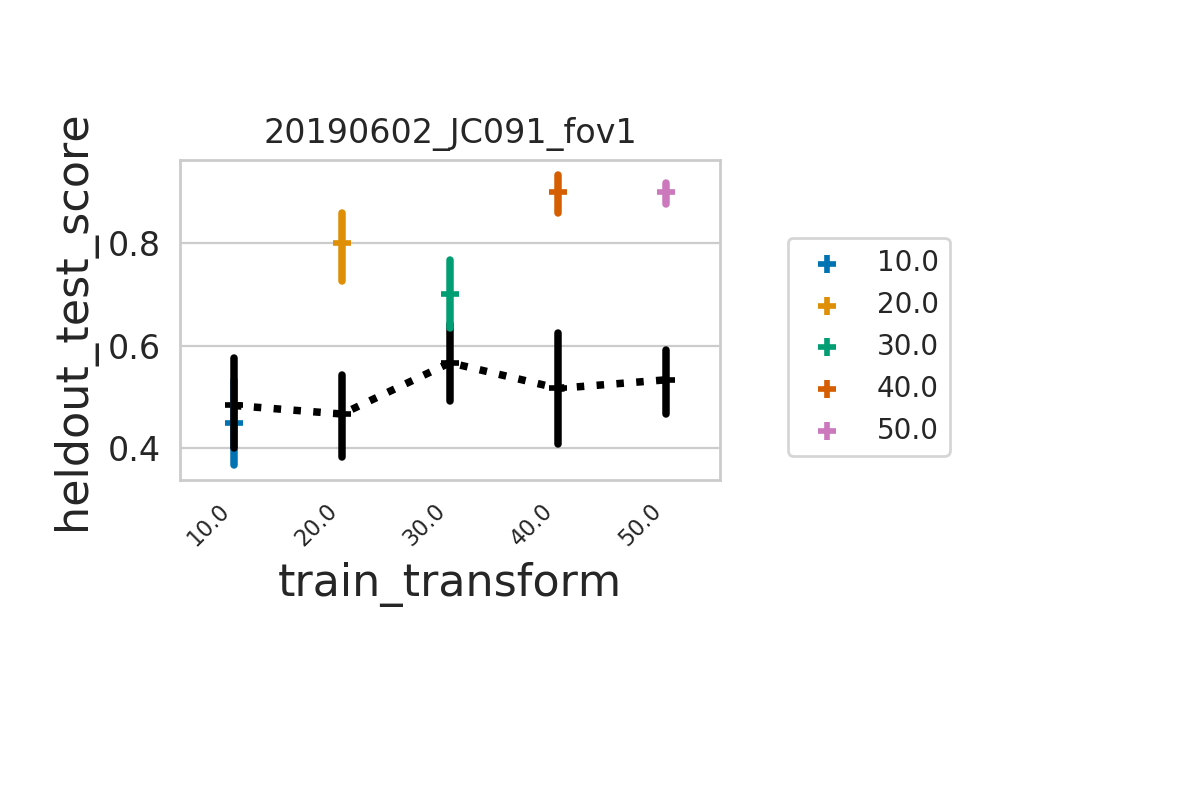

Text(0.5,1,u'20190602_JC091_fov1')

In [537]:
meandf = idf.groupby(['condition', 'train_transform', 'test_transform']).mean().reset_index()
print(meandf.shape)

fig, ax = pl.subplots(figsize=(6,4))

sns.pointplot(x='train_transform', y='heldout_test_score', data=idf[idf.condition=='data'], ax=ax,
             hue='train_transform', linestyles='-', alpha=0.5, markers='+', palette='colorblind')
sns.pointplot(x='train_transform', y='heldout_test_score', data=idf[idf.condition=='shuffled'], ax=ax,
             hue=None, linestyles=':', alpha=0.5, markers='+', color='k')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

ax.legend(bbox_to_anchor=(1.1, 0.8))
pl.subplots_adjust(left=0.15, bottom=0.4, right=0.6, top=0.8)
ax.set_title('%s' % datakey)

(12, 19)


<IPython.core.display.Javascript object>


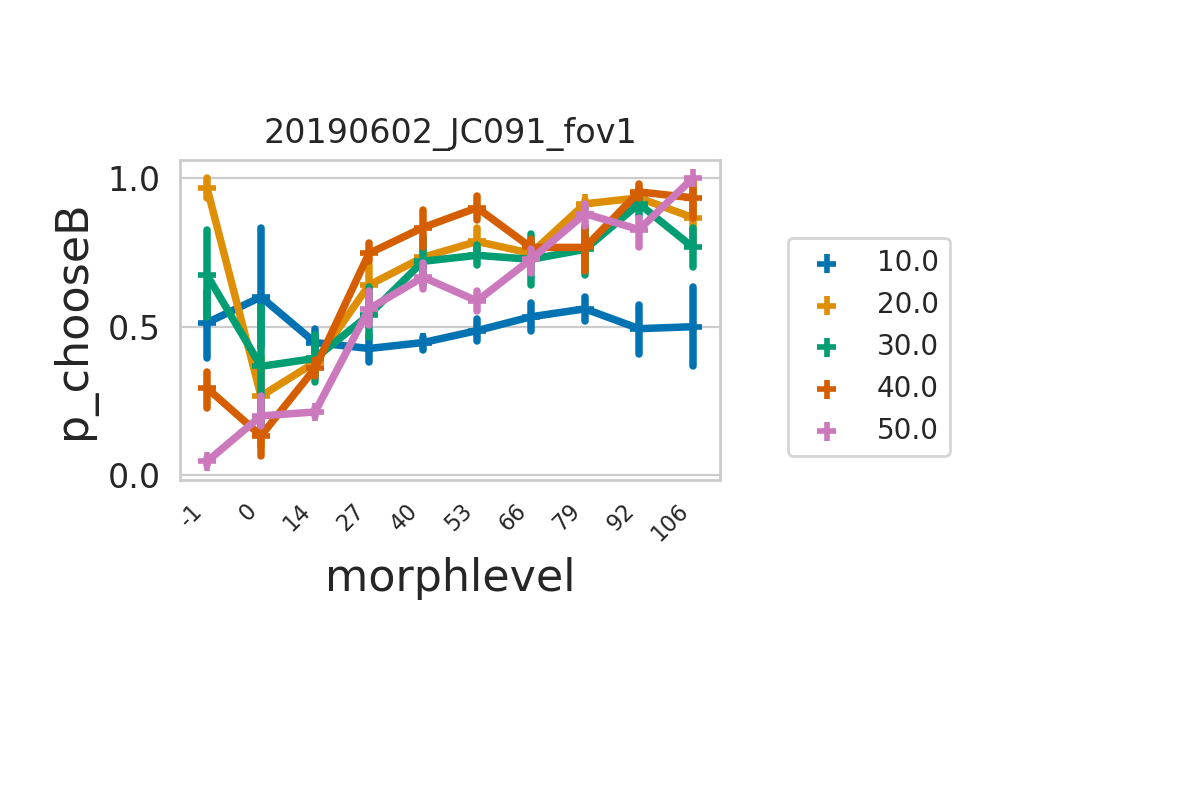

Text(0.5,1,u'20190602_JC091_fov1')

In [536]:
meandf = idf.groupby(['condition', 'morphlevel']).mean().reset_index()
print(meandf.shape)

fig, ax = pl.subplots(figsize=(6,4))

sns.pointplot(x='morphlevel', y='p_chooseB', data=idf[idf.condition=='data'], ax=ax,
             hue='train_transform', linestyles='-', alpha=0.5, markers='+', palette='colorblind')
# sns.pointplot(x='train_transform', y='heldout_test_score', data=idf[idf.condition=='shuffled'], ax=ax,
#              hue=None, linestyles=':', alpha=0.5, markers='+', color='k')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)

ax.legend(bbox_to_anchor=(1.1, 0.8))
pl.subplots_adjust(left=0.15, bottom=0.4, right=0.6, top=0.8)
ax.set_title('%s' % datakey)

In [ ]:
reload(decutils)

In [ ]:
start_t = time.time()
i_chunks = decutils.fit_svm_mp(neuraldf, sdf,
                n_iterations=6, n_processes=2,
                C_value=C_value, cv_nfolds=5, test_split=0.2,
                class_a=class_a, class_b=class_b)
end_t = time.time() - start_t
print("--> Elapsed time: {0:.2f}sec".format(end_t))

In [ ]:
len(i_chunks)

In [ ]:
idf2 = pd.concat(i_chunks, axis=0)
idf2.groupby(['condition']).mean()



In [ ]:
len(i_chunks)

In [ ]:
[i.shape for i in i_chunks]

In [ ]:
iterdf.groupby(['condition', 'train_transform', 'test_transform']).mean()

# Test loading

In [ ]:
reload(decutils)

In [ ]:
reload(dc)

In [ ]:
visual_area ='Li'
datakey = '20190315_JC070_fov1' #'20190507JC083_fov1'
session, animalid, fovnum = putils.split_datakey_str(datakey)
fov='FOV%i_zoom2p0x' % fovnum

i_df, res_id = dc.load_fov_results(animalid, session, fov, traceid=traceid,
                     visual_area=visual_area, C_value=None, response_type=response_type,
                    responsive_test=responsive_test, trial_epoch=trial_epoch,
                    overlap_thr=None, has_retino=False, threshold_dff=False,
                    test_type='size_single')
print(res_id)
print(i_df.shape)

In [ ]:
meandf = i_df.groupby(['condition', 'train_transform', 'test_transform']).mean().reset_index()
print(meandf.shape)

fig, ax = pl.subplots(figsize=(5,3))

sns.pointplot(x='test_transform', y='heldout_test_score', data=i_df[i_df.condition=='data'], ax=ax,
             hue='train_transform', linestyles='-', alpha=0.5, markers='+', palette='colorblind')
sns.pointplot(x='test_transform', y='heldout_test_score', data=i_df[i_df.condition=='shuffled'], ax=ax,
             hue=None, linestyles=':', alpha=0.5, markers='+', color='k')

ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.7)
ax.set_title('%s' % datakey)

# Unique datasets

In [181]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

In [26]:
#### Get unique datasets
filter_by='most_fits'
blob_dsets = aggr.get_blob_datasets(filter_by=filter_by, as_dict=False, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)
all_dkeys = sdata[(sdata['experiment']==experiment)]['datakey'].unique()
unique_dkeys = blob_dsets['datakey'].unique()

n_drop = len(all_dkeys) - len(unique_dkeys)
print("Dropping %i dkeys (%i of %i dkeys unique)" % (n_drop, len(unique_dkeys), len(all_dkeys)))

Segmentation: missing 9 dsets
Segmentation: missing 3 dsets
[AL] Animalid does not exist: JC099 
[Ll] Animalid does not exist: JC067 
[Ll] Animalid does not exist: JC099 
[POR] Animalid does not exist: JC076 
[V1] Animalid does not exist: JC078 
Dropping 12 dkeys (30 of 42 dkeys unique)


# Load aggregate

In [27]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil'

In [46]:
test_type='size_subset' #'morph_single'
responsive_test='ROC'

responsive_thr=10.0 if responsive_test=='nstds' else 0.05
response_str = '%s_%s-thr-%.2f' % (response_type, responsive_test, responsive_thr) 
data_id = '|'.join([traceid, stimfilter_str, response_str])
print(data_id)

metric = 'heldout_test_score'

#### Create output dir
curr_dst_dir = os.path.join(dst_dir, 'generalization', test_type, responsive_test)
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

#### Load results
i_=[]
for (visual_area, datakey), g in CELLS.groupby(['visual_area', 'datakey']):
    session, animalid, fovnum = putils.split_datakey_str(datakey)
    fov='FOV%i_zoom2p0x' % fovnum

    i_df, res_id = dc.load_fov_results(animalid, session, fov, traceid=traceid,
                         visual_area=visual_area, C_value=C_value, response_type=response_type,
                        responsive_test=responsive_test, trial_epoch=trial_epoch,
                        overlap_thr=None, has_retino=False, threshold_dff=False,
                        test_type=test_type, analysis_type=analysis_type)
    if i_df is None:
        print("No results: (%s, %s)" % (visual_area, datakey))
    i_.append(i_df)
    
iterdf = pd.concat(i_, axis=0)


traces001|filter_None_blobsonly|dff_ROC-thr-0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/split_pupil/generalization/size_subset/ROC
No results: (Li, 20190314_JC070_fov1)
No results: (Li, 20190315_JC070_fov1)
No results: (Li, 20190316_JC070_fov1)
No results: (Li, 20190319_JC067_fov1)
No results: (Li, 20190320_JC067_fov1)
No results: (Li, 20190321_JC070_fov1)
No results: (Li, 20190322_JC073_fov1)
No results: (Li, 20190327_JC073_fov1)
No results: (Li, 20190422_JC076_fov1)
No results: (Li, 20191018_JC113_fov1)
No results: (Lm, 20190306_JC061_fov3)
No results: (Lm, 20190322_JC073_fov1)
No results: (Lm, 20190327_JC073_fov1)
No results: (Lm, 20190422_JC076_fov1)


In [49]:
# iterdf['condition'][~(iterdf.condition.isin(['data', 'shuffled']))] = 'data'
iterdf['novel'] = iterdf['train_transform'] != iterdf['test_transform']
if all([np.isnan(i) for i in iterdf[iterdf.condition=='shuffled']['novel'].values]):   
    iterdf['novel'].loc[iterdf.condition=='shuffled'] = False
    
group_cols = ['visual_area', 'datakey', 'condition', 'train_transform', 'test_transform', 'novel']
if analysis_type=='split_pupil':
    group_cols.extend(['arousal'])
    
meandf = iterdf.groupby(group_cols).mean().reset_index()
meandf.head()

visual_area              datakey condition train_transform test_transform  \
0          Li  20190602_JC091_fov1      data     10_20_30_40             50   
1          Li  20190602_JC091_fov1      data     10_20_30_40             50   
2          Li  20190602_JC091_fov1      data     10_20_30_40             50   
3          Li  20190602_JC091_fov1      data     10_20_30_40    10_20_30_40   
4          Li  20190602_JC091_fov1      data     10_20_30_40    10_20_30_40   

   novel arousal        C  heldout_MI  heldout_aMI  heldout_log2MI  \
0   True     all  0.05410    0.183113     0.254578        0.264176   
1   True    high  0.03331    0.115163     0.091183        0.166145   
2   True     low  0.05851    0.149199     0.146012        0.215249   
3  False     all  0.05410    0.166072     0.227403        0.239591   
4  False    high  0.03331    0.103186     0.003749        0.148866   

   heldout_test_score  n_trials    randi  iteration  n_cells  
0            0.755690    1450.0  4920.89       49.5     87.0  
1            0.721250     222.0  5649.89       49.5     87.0  
2            0.757273     222.0  5198.73       49.5     87.0  
3            0.770426    1450.0  4920.89       49.5     87.0  
4            0.620000     222.0  5649.89       49.5     87.0

# Exclude garbage

In [50]:
traindf = iterdf[(iterdf.train_transform==iterdf.test_transform) & (iterdf.arousal=='all')]\
            .dropna().drop_duplicates()
d_ = traindf[(traindf.visual_area=='V1') & (traindf.datakey=='20190616_JC097_fov1')].copy()

In [51]:
metric = 'heldout_test_score'
# all_df = iterdf[iterdf.arousal=='all'].copy()
percentiles = decutils.get_percentile_shuffled(traindf, metric=metric)
percentiles.shape

(185, 15)

<IPython.core.display.Javascript object>


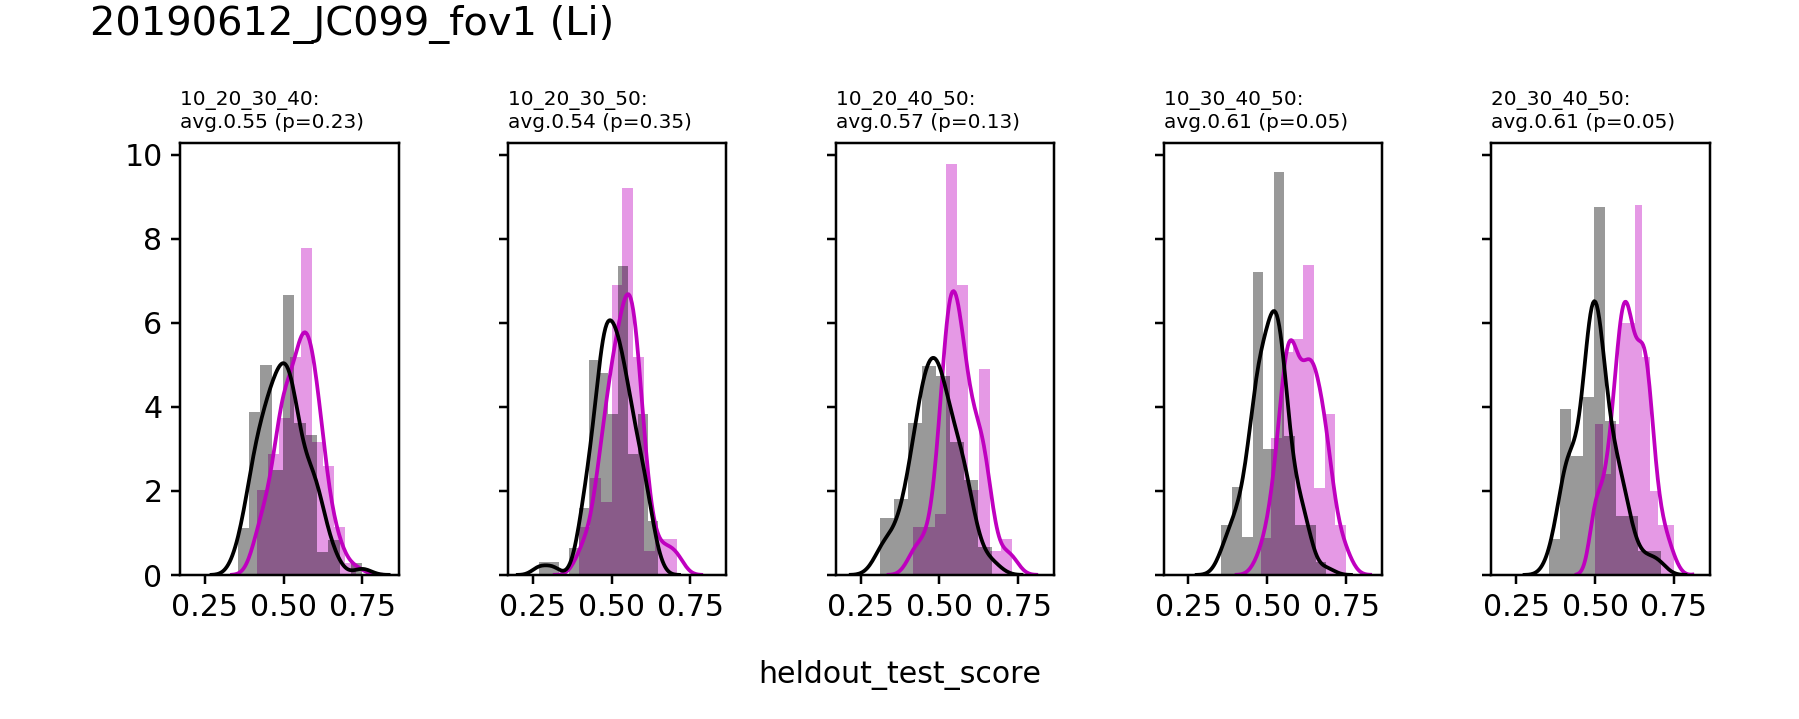

In [53]:
dk = '20190612_JC099_fov1'
va = 'Li'
d_ = traindf[(traindf.visual_area==va) & (traindf.datakey==dk) ].copy()
metric='heldout_test_score'

fig, axn = pl.subplots(1, 5, figsize=(10,4), sharex=True, sharey=True)
for ai, (transf, g) in enumerate(d_.groupby(['train_transform'])):
    ax = axn[ai]

    mean_score = g[g['condition']=='data'][metric].mean()
    percentile = np.mean(mean_score < g[g['condition']=='shuffled'][metric])
    ax.set_title('%s: \navg.%.2f (p=%.2f)' % (str(transf), mean_score, percentile), loc='left', fontsize=8)
    
    sns.distplot(g[g['condition']=='data'][metric], color='m', ax=ax)
    sns.distplot(g[g['condition']=='shuffled'][metric], color='k', ax=ax)
    ax.set_xlabel('')
fig.text(0.5, 0.05, metric, ha='center', fontsize=12)
fig.text(0.05, 0.95, '%s (%s)' % (dk, va), fontsize=16)

pl.subplots_adjust(bottom=0.2, left=0.1, right=0.95, wspace=0.5, top=0.8)

In [537]:
if test_type=='size_subset':
    passdf = pd.concat([g for (v, d), g in meandf.groupby(['visual_area', 'datakey']) \
                       if g[(g.novel==False) & (g.condition=='data')][metric].mean() \
                        > g[(g.novel==False) & (g.condition=='shuffled')][metric].mean() ])
elif test_type=='morph':
    scores = iterdf[iterdf.train_transform==iterdf.test_transform]\
                    .groupby(['visual_area', 'datakey', 'condition', 'train_transform', 'test_transform'])\
                    .mean().reset_index()
    pass_shuffle = [(v, dk) for (v, dk), g in scores.groupby(['visual_area', 'datakey']) \
                   if g[g.condition=='shuffled'][metric].mean() < g[g.condition=='data'][metric].mean()]
    passdf = pd.concat([g for (v, d), g in meandf.groupby(['visual_area', 'datakey']) \
                       if (v, d) in pass_shuffle])
else:
    passdf = pd.concat([g for (v, d), g in meandf.groupby(['visual_area', 'datakey']) \
                       if g[(g.condition=='data')][metric].mean() \
                        > g[(g.condition=='shuffled')][metric].mean() ])

print(meandf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print(passdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

             datakey
visual_area         
Li                16
Lm                16
V1                16
             datakey
visual_area         
Li                13
Lm                15
V1                16


In [550]:
#### Select datasets to plot
filter_pass = True

xdf = passdf.copy() if filter_pass else meandf.copy()
min_ncells = 5
xdf = xdf[(xdf['n_cells']>=min_ncells)] # & (xdf['n_cells']<=max_ncells)]


excl= ['20190507_JC083_fov1', '20190422_JC076_fov1']
dropdf = pd.concat([xdf[(xdf.visual_area==v) & (xdf.datakey==dk) & ~(xdf.datakey.isin(excl))] for (v, dk), g \
            in blob_dsets.groupby(['visual_area', 'datakey'])])

ncells_by_fov_all = xdf[['visual_area', 'datakey', 'n_cells']].drop_duplicates()

# Match N cells
max_ncells = ncells_by_fov_all.groupby(['visual_area']).max().min()['n_cells']
min_ncells = ncells_by_fov_all.groupby(['visual_area']).min().max()['n_cells']
matchdf = xdf[(xdf['n_cells']>=min_ncells) & (xdf['n_cells']<=max_ncells)].copy()
print(max_ncells, min_ncells)


(87.0, 7.0)


In [551]:
# Match nums, then drop those that are repeats
match_dsets = pd.concat([CELLS[(CELLS.visual_area==v) & (CELLS.datakey==dk)] \
           for (v, dk), g in matchdf.groupby(['visual_area', 'datakey'])])\
            .groupby(['visual_area', 'datakey']).count().reset_index()
match_dsets = putils.split_datakey(match_dsets)
match_dsets = aggr.select_best_fovs(match_dsets)
matchdf_drop = pd.concat([matchdf[(matchdf.visual_area==v) & (matchdf.datakey==dk) 
                      & ~(matchdf.datakey.isin(excl))] for (v, dk), g \
                          in match_dsets.groupby(['visual_area', 'datakey'])])

# Drop repeat FOVs, then match equal nums
dropdf_match = dropdf[(dropdf['n_cells']>=min_ncells) & (dropdf['n_cells']<=max_ncells)].copy()

print(max_ncells, min_ncells)

[V1] Animalid does not exist: JC078 
(87.0, 7.0)


In [552]:
match_dsets[match_dsets.visual_area=='V1']

visual_area              datakey  dset_roi  global_ix  roi animalid  \
19          V1  20190501_JC076_fov1        33         33   33    JC076   
20          V1  20190510_JC083_fov1        71         71   71    JC083   
21          V1  20190512_JC083_fov1        28         28   28    JC083   
22          V1  20191006_JC110_fov1        86         86   86    JC110   

     session  fovnum  cell            fov  
19  20190501      33    33  FOV1_zoom2p0x  
20  20190510      71    71  FOV1_zoom2p0x  
21  20190512      28    28  FOV1_zoom2p0x  
22  20191006      86    86  FOV1_zoom2p0x

In [553]:
#### FOVs matched for cell #s
# incl_ddict = {'Li': ['20190315_JC070_fov1', '20190322_JC073_fov1', '20190602_JC091_fov1', '20190609_JC099_fov1', 
#                      '20190614_JC091_fov1','20191018_JC113_fov1', '20191111_JC120_fov1'],
#               'Lm': ['20190306_JC061_fov3', '20190322_JC073_fov1', '20190504_JC078_fov1', '20190512_JC083_fov1', 
#                      '20190517_JC083_fov1', '20190618_JC097_fov1'],
#               'V1': ['20190501_JC076_fov1', '20190504_JC078_fov1', '20190508_JC083_fov1', '20190512_JC083_fov1', 
#                      '20191006_JC110_fov1']}

# passdf = pd.concat([g for (v, d), g in meandf.groupby(['visual_area', 'datakey']) if d in incl_ddict[v]])
# print(passdf.shape, meandf.shape)

In [555]:
equal_nums=True
drop_repeats=True

dset_str = 'drop_repeats' if (drop_repeats is True) else 'all_datasets'
filter_str = 'aboveshuffled' if filter_pass else 'nofilterpass'
x_axis = 'test_transform' if 'single' in test_type else 'train_transform'
sns.set_style("whitegrid")

metric = 'heldout_test_score'

DF=None
if drop_repeats:
    if equal_nums:
        DF = matchdf_drop.copy() # dropdf_match.copy()
    else:
        DF = dropdf.copy()
else:
    if equal_nums:
        DF = matchdf.copy()
    else:
        DF = xdf.copy()

train_sizes = sorted(DF['train_transform'].unique())
n_sizes = len(train_sizes)

dset_str = 'droprepeats' if drop_repeats else 'alldatasets'
pass_str = '%s_matchcounts' % filter_str if equal_nums else '%s_nomatch' % filter_str

morphdf=None
if 'morph' in test_type:
    morphdf = DF[(DF.morphlevel!=-1) & (DF.condition=='data')].copy()

In [556]:
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/generalization/size_subset/ROC


In [557]:
DF[['visual_area', 'datakey', 'n_cells']].drop_duplicates()

visual_area              datakey  n_cells
15           Li  20190315_JC070_fov1     27.0
30           Li  20190316_JC070_fov1      7.0
90           Li  20190322_JC073_fov1     38.0
115          Li  20190602_JC091_fov1     87.0
150          Li  20190609_JC099_fov1     57.0
175          Li  20190614_JC091_fov1     78.0
190          Li  20190617_JC099_fov1      7.0
205          Li  20191111_JC120_fov1     30.0
220          Lm  20190306_JC061_fov3     30.0
235          Lm  20190322_JC073_fov1     30.0
280          Lm  20190504_JC078_fov1     59.0
335          Lm  20190512_JC083_fov1     78.0
350          Lm  20190513_JC078_fov1     73.0
410          Lm  20190618_JC097_fov1     44.0
465          V1  20190501_JC076_fov1     33.0
540          V1  20190510_JC083_fov1     71.0
570          V1  20190512_JC083_fov1     28.0
675          V1  20191006_JC110_fov1     86.0

# Plot size generalization, by visual area

<IPython.core.display.Javascript object>


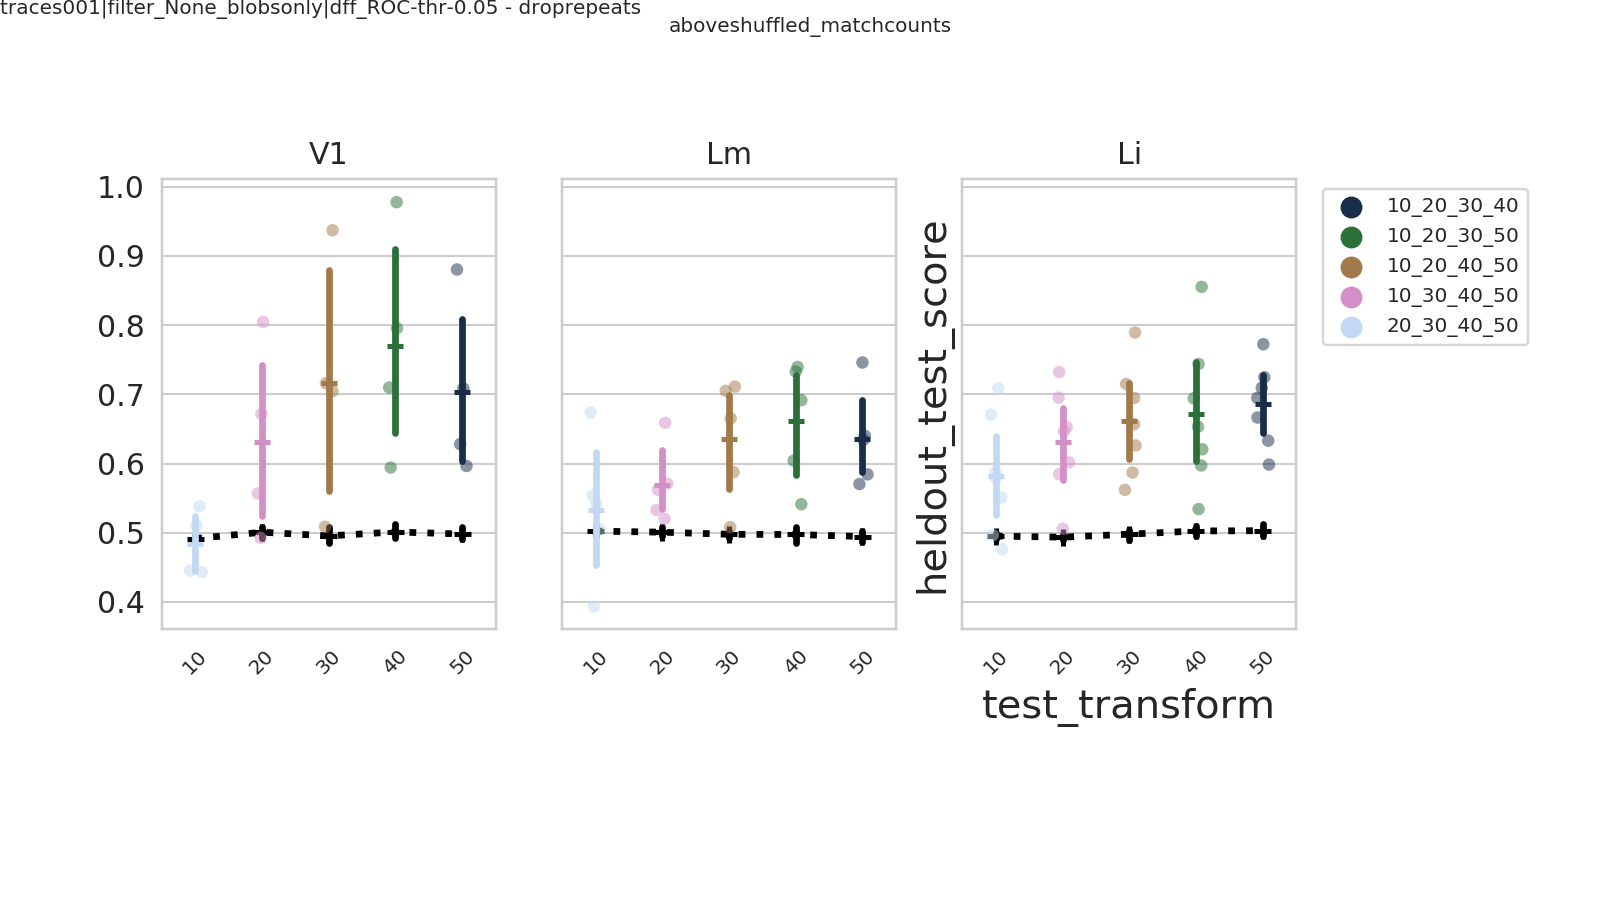

heldout_test_score_by_area__droprepeats_aboveshuffled_matchcounts


In [558]:
# plot--------
x_axis= 'test_transform'
fig, axn = pl.subplots(1, 3, figsize=(9,5), sharey=True, sharex=True)
for ai, (visual_area, d_) in enumerate(DF.groupby(['visual_area'])):
    ax=axn.flat[visual_areas.index(visual_area)]
    if len(d_)==0:
        continue
    
    novel = d_[(d_.condition=='data') & (d_.novel==True)]
    shuff = d_[d_.condition=='shuffled']
    
    sns.stripplot(x=x_axis, y=metric, data=novel, ax=ax,
                 hue='train_transform',alpha=0.5, palette='cubehelix')
    
    sns.pointplot(x=x_axis, y=metric, data=novel, ax=ax,
                 hue='train_transform', linestyles='-', alpha=0.5, markers='+', palette='cubehelix')

    sns.pointplot(x=x_axis, y=metric, data=shuff, ax=ax,
                 hue=None, linestyles=':', alpha=0.5, markers='+', color='k')
    ax.set_title('%s' % visual_area)

    test_sizes = sorted(novel['test_transform'].unique())
    ax.set_xticks(np.arange(0, n_sizes)) #ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xticklabels([i if isinstance(i, str) else int(i) for i in test_sizes],
                      fontsize=8, rotation=45)

    if ai!=0:
        ax.set_ylabel('')
        ax.set_xlabel('')

aggr.crop_legend_labels(axn[-1], n_hues=n_sizes, bbox_to_anchor=(1.2, 1), fontsize=8)
#axn[-1].legend(bbox_to_anchor=(1.2, 1)) 
for ax in axn.flat[0:2]:
    ax.legend_.remove()

pl.subplots_adjust(left=0.1, bottom=0.3, right=0.8, wspace=0.2, top=0.8)
pl.suptitle(pass_str, fontsize=8)

putils.label_figure(fig, '%s - %s' % (data_id, dset_str))
figname = '%s_by_area__%s_%s' % (metric, dset_str, pass_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(figname)

##### Plot per FOV

<IPython.core.display.Javascript object>


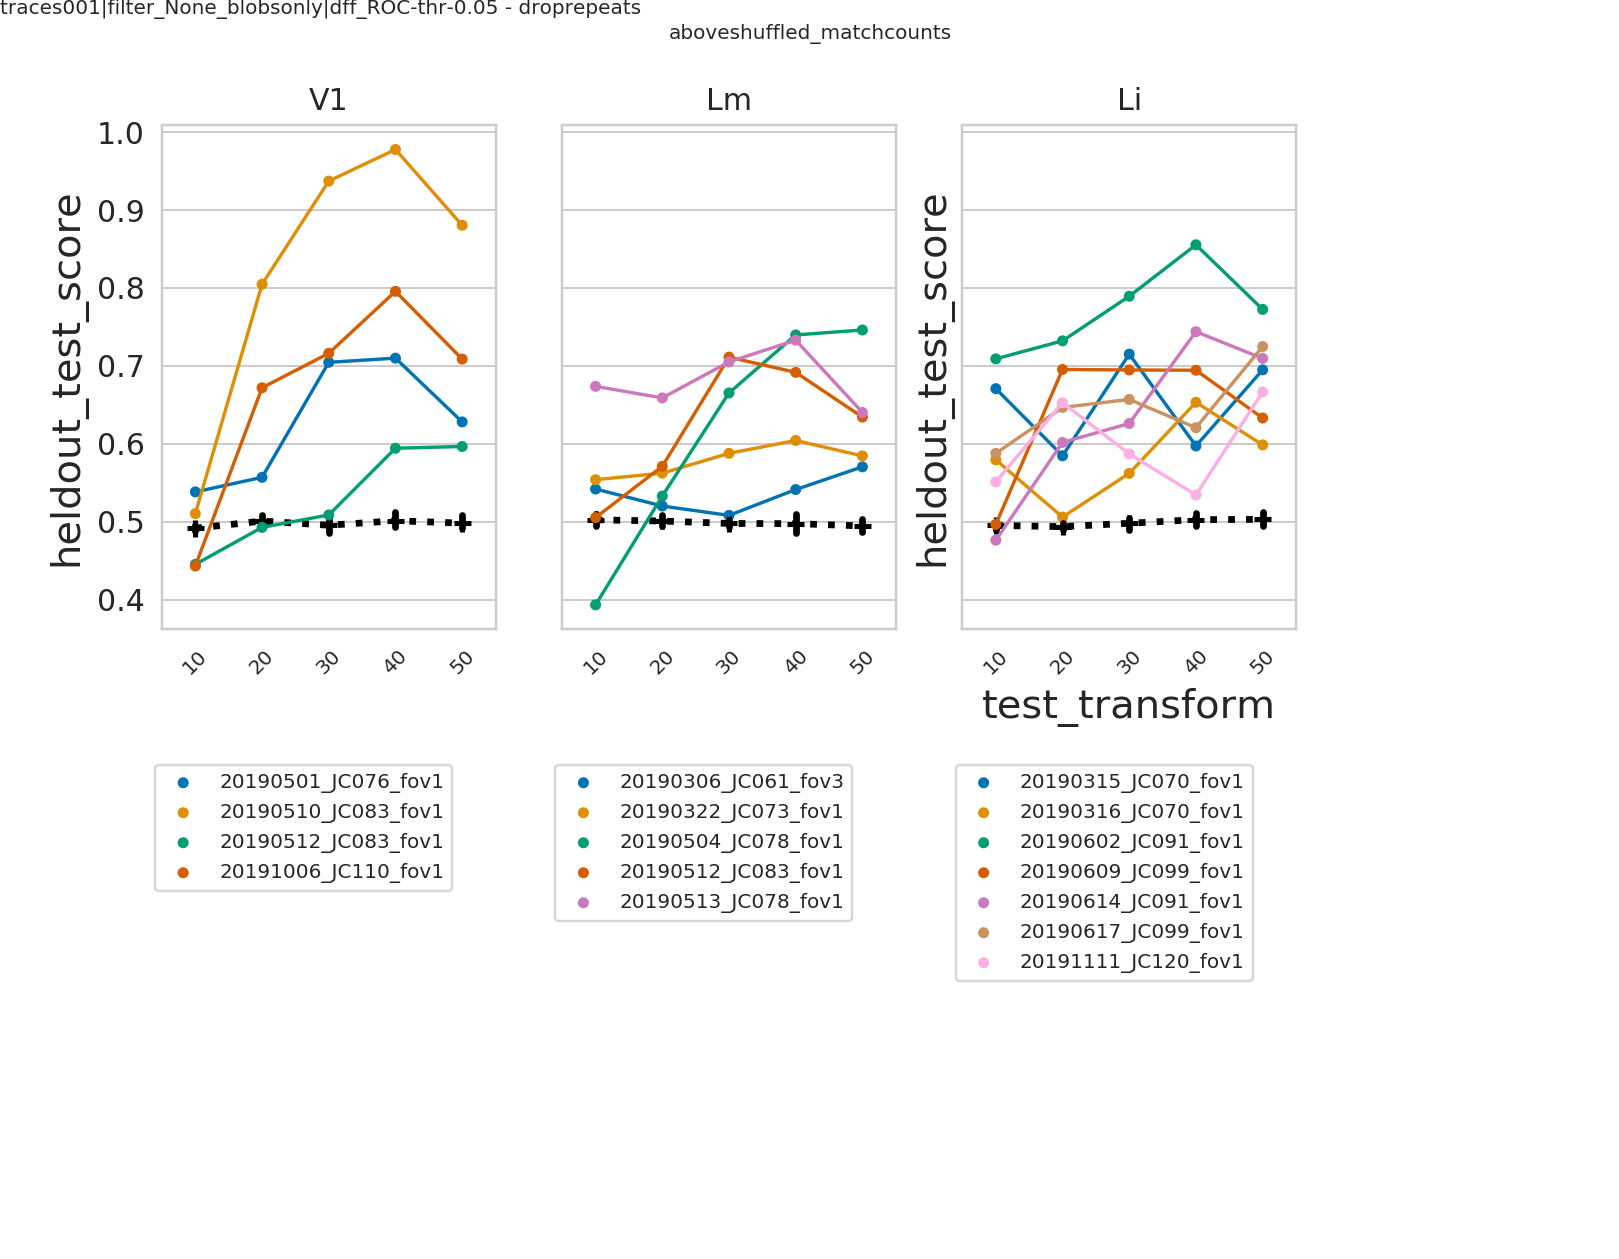

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/generalization/size_subset/ROC', 'heldout_test_score_by_fov__droprepeats_aboveshuffled_matchcounts')


In [546]:
sns.set_palette('colorblind')
fig, axn = pl.subplots(1, 3, figsize=(9,7), sharey=True, sharex=True)
for ai, (visual_area, d_) in enumerate(DF.groupby(['visual_area'])):
    ax=axn.flat[visual_areas.index(visual_area)]
    if len(d_)==0:
        continue

    novel = d_[(d_.novel==True) & (d_.condition=='data')]
    shuff = d_[d_.condition=='shuffled']

    sns.pointplot(x=x_axis, y=metric, data=novel, ax=ax, hue='datakey', 
                 alpha=1, palette='colorblind', join=True, scale=0.5)
    
    sns.pointplot(x=x_axis, y=metric, data=shuff, ax=ax,
                 hue=None, linestyles=':', alpha=0.5, markers='+', color='k')
    ax.set_title('%s' % visual_area)
    
    test_sizes = sorted(d_['test_transform'].unique())
    ax.set_xticks(np.arange(0, n_sizes)) #ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xticklabels([i if isinstance(i, str) else int(i) for i in test_sizes],
                      fontsize=8, rotation=45)
    
    ax.legend(bbox_to_anchor=(0.9, -0.25), fontsize=8)
    if ai!=0:
        ax.set_ylabel('')
        ax.set_xlabel('')
axn[0].set_ylabel(metric)

pl.subplots_adjust(left=0.1, bottom=0.5, right=0.8, wspace=0.2, top=0.9)
pl.suptitle(pass_str, fontsize=8)

putils.label_figure(fig, '%s - %s' % (data_id, dset_str))
figname = '%s_by_fov__%s_%s' % (metric, dset_str, pass_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)

#### Compare N_CELLS

<IPython.core.display.Javascript object>


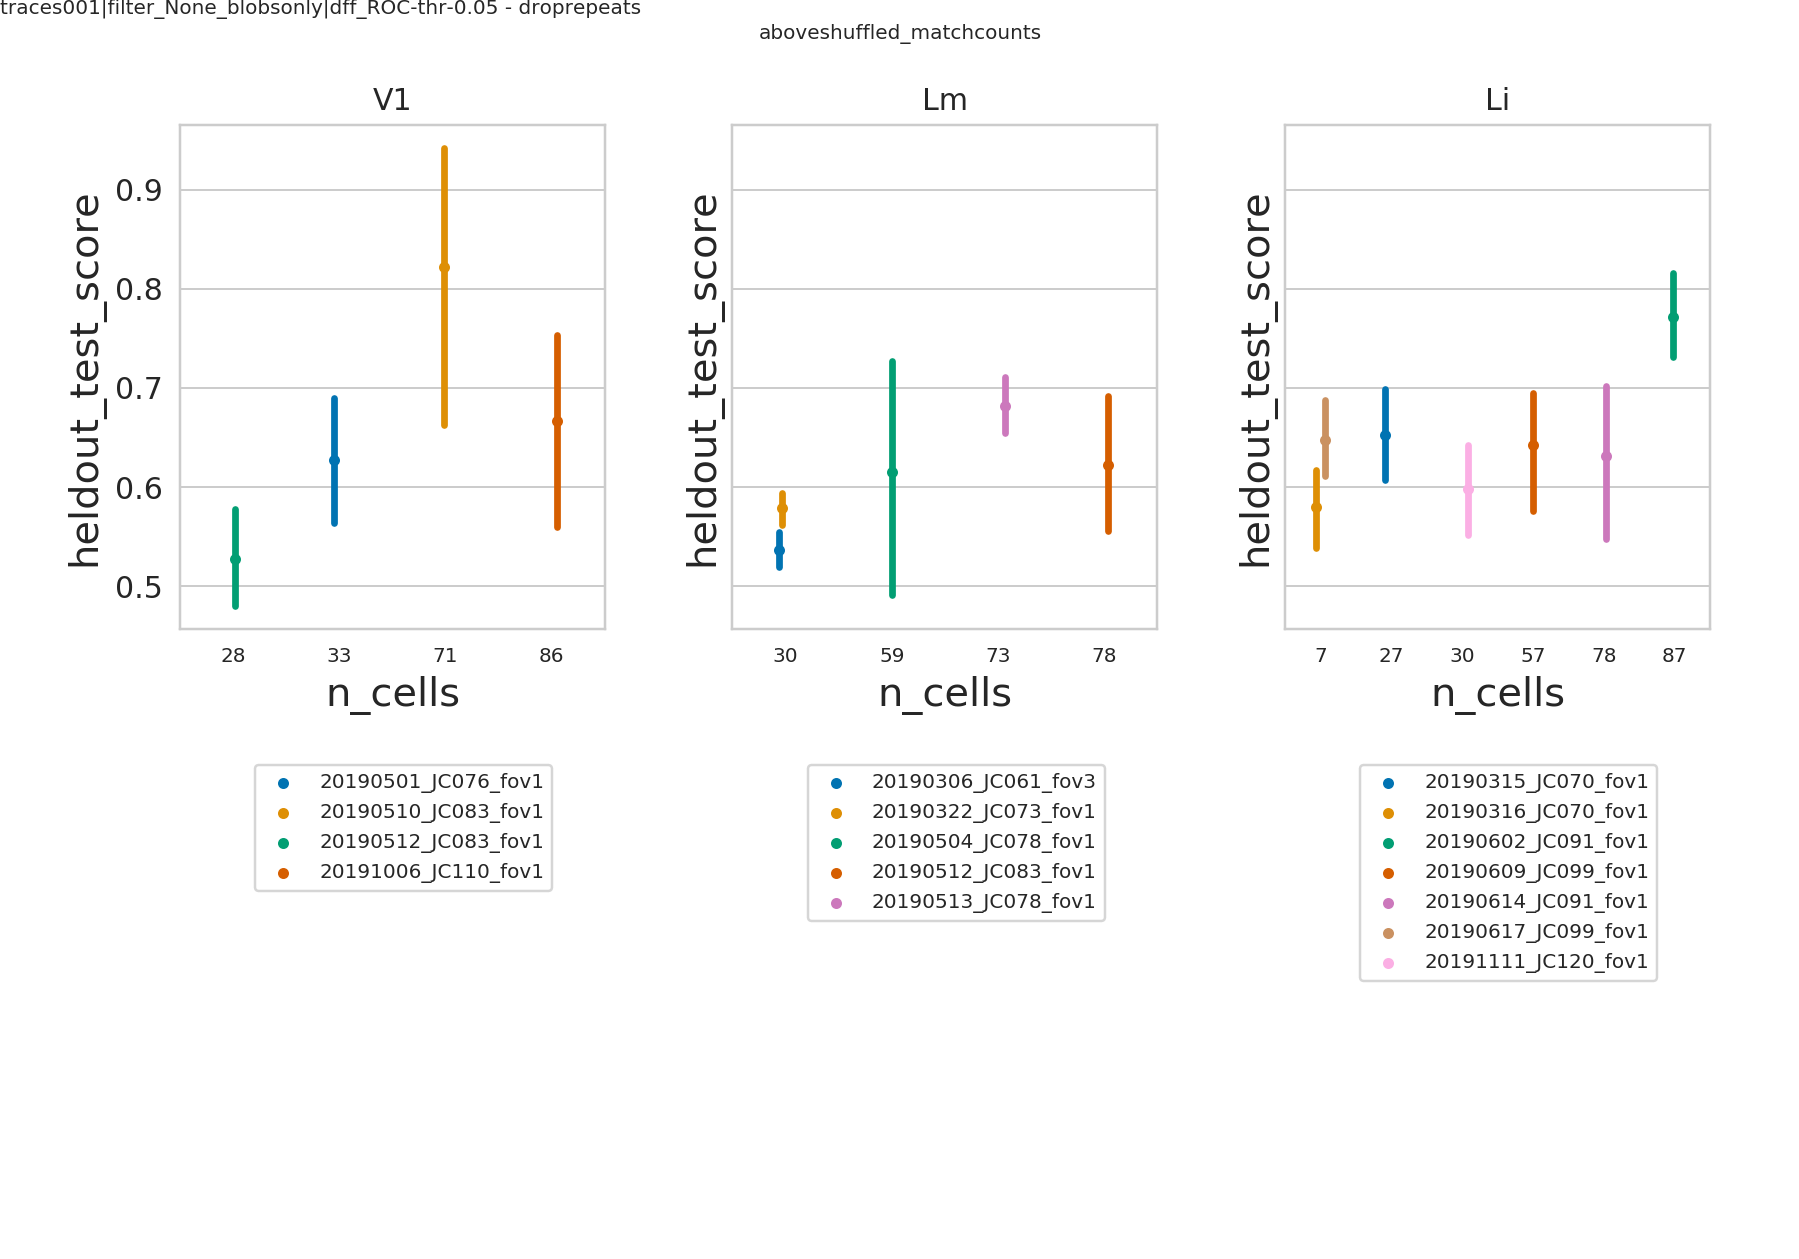

n_cells_heldout_test_score_by_fov__droprepeats_aboveshuffled_matchcounts


In [547]:
testdf = DF[(DF.condition=='data') & (DF.novel==True)].copy()
fig, axn = pl.subplots(1, 3, figsize=(10,7), sharey=True, sharex=False)
for ai, (visual_area, d_) in enumerate(testdf.groupby(['visual_area'])):
    ax=axn.flat[visual_areas.index(visual_area)]
    if len(d_)==0:
        continue

    sns.pointplot(x='n_cells', y=metric, data=d_, hue='datakey', ax=ax,
                 alpha=1, palette='colorblind', dodge=True, join=False, scale=0.5)
    #ax.set_xticks([int(float(t.get_text())) for t in ax.get_xticklabels()])
    ax.set_xticklabels([int(float(t.get_text())) for t in ax.get_xticklabels()], fontsize=8)
    ax.legend(bbox_to_anchor=(0.9, -0.25), fontsize=8)
    ax.set_title(visual_area)

pl.subplots_adjust(left=0.1, bottom=0.5, right=0.95, wspace=0.3, top=0.9)
pl.suptitle(pass_str, fontsize=8)

putils.label_figure(fig, '%s - %s' % (data_id, dset_str))
figname = 'n_cells_%s_by_fov__%s_%s' % (metric, dset_str, pass_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(figname)

## Average accuracy on test, by FOV

In [548]:
testdf = DF[(DF.condition=='data') & (DF.novel==True)].copy()
means_by_fov = testdf[(testdf.novel==True)].groupby(['condition', 'visual_area', 'datakey']).mean().reset_index()

visual_area
Li    0.646222
Lm    0.606957
V1    0.660985
Name: heldout_test_score, dtype: float64


<IPython.core.display.Javascript object>


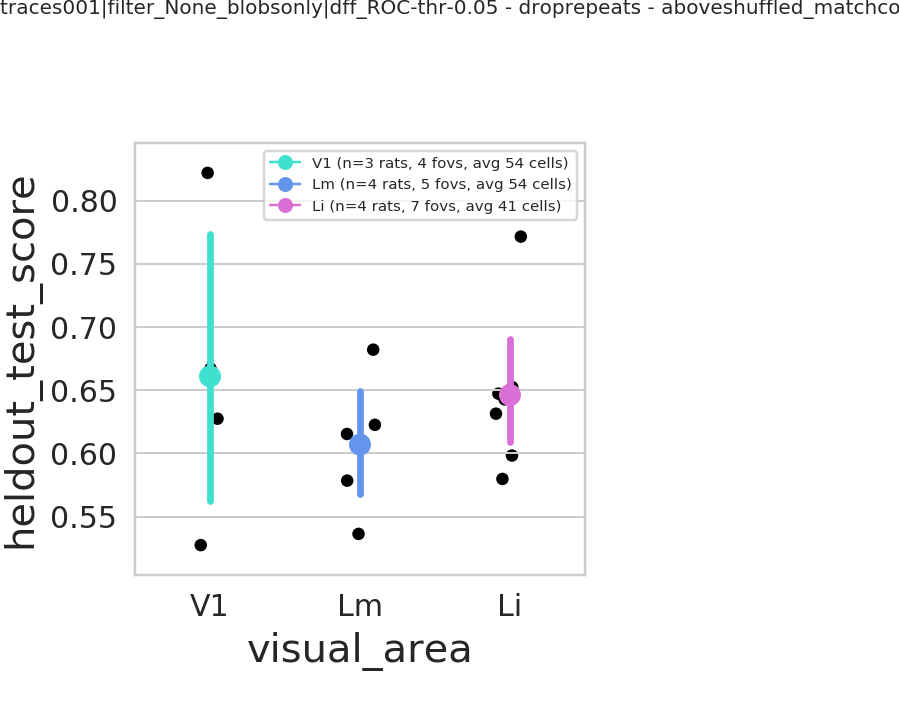

********* [heldout_test_score] Mann-Whitney U test(mc=fdr_bh) **********
[('V1', 'Lm')] p=0.405 (fdr_bh), reject H0=False
[('V1', 'Li')] p=0.462 (fdr_bh), reject H0=False
[('Lm', 'Li')] p=0.383 (fdr_bh), reject H0=False
****************************
heldout_test_score_avg_fovs__droprepeats_aboveshuffled_matchcounts


In [549]:
metric = 'heldout_test_score'
multi_comp_test='fdr_bh'
print(means_by_fov.groupby(['visual_area']).mean()[metric])

fig, ax = pl.subplots(figsize=(5,4))

sns.stripplot(x='visual_area', y=metric, data=means_by_fov, ax=ax, 
             color='k', s=5, marker='o', order=visual_areas,zorder=-1)
sns.pointplot(x='visual_area', y=metric, data=means_by_fov, ax=ax, zorder=-1,
             palette=area_colors, scale=1, markers='o', order=visual_areas)
#### Legend
leg = aggr.get_counts_for_legend(means_by_fov, area_colors=area_colors, marker='o', markersize=5)
ax.legend(handles=leg, bbox_to_anchor=(1., 1), fontsize=6)

#### Stats
statsresults, ax = aggr.plot_mannwhitney(means_by_fov, metric=metric, 
                                         multi_comp_test=multi_comp_test, ax=ax)


pl.subplots_adjust(right=0.65, bottom=0.2, left=0.15, top=0.8)
putils.label_figure(fig, '%s - %s - %s' % (data_id, dset_str, pass_str))
figname = '%s_avg_fovs__%s_%s' % (metric, dset_str, pass_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(figname)

In [169]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_fov/generalization/size_subset/ROC'

## Plot by size 

In [530]:
from matplotlib import ticker #import MaxNLocator


<IPython.core.display.Javascript object>


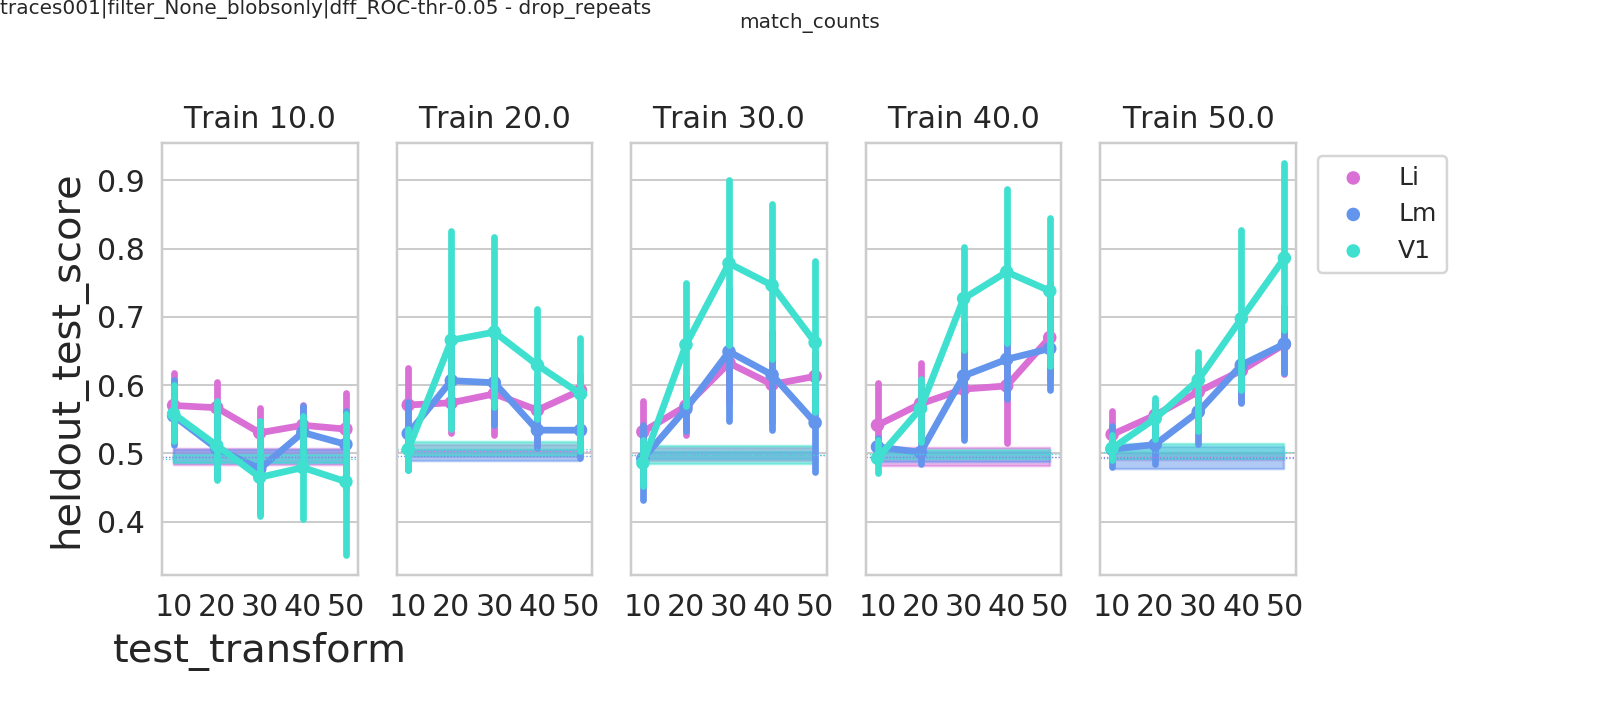

heldout_test_score_by_traincond__drop_repeats_match_counts


In [532]:
#metric='relative_score'

equal_nums=True
drop_repeats=True
metric = 'heldout_test_score'

if drop_repeats:
    if equal_nums:
        DF = matchdf_drop.copy()
    else:
        DF = dropdf.copy()
else:
    if equal_nums:
        DF = matchdf.copy()
    else:
        DF = meandf.copy()
# DF = matched_df.copy() if equal_nums else xdf.copy()

train_sizes = sorted(DF['train_transform'].unique())
test_sizes = sorted(DF['test_transform'].unique())
n_sizes = len(test_sizes)

dset_str = 'drop_repeats' if drop_repeats else 'all_datasets'
pass_str = 'match_counts' if equal_nums else 'all_cells'

fig, axn = pl.subplots(1, n_sizes, figsize=(9,4), sharey=True, sharex=True)

for ai, (train_size, ax) in enumerate(zip(train_sizes, axn.flat)):
    d_ = DF[DF.train_transform==train_size].copy()
    if len(d_)==0:
        continue
        
    novel = d_[(d_.condition=='data') & (d_.novel)]
    sns.pointplot(x='test_transform', y=metric, data=novel, ax=ax, #ci='sd',
                     hue='visual_area', linestyles='-', alpha=0.5, markers='.', 
                  palette=area_colors) #, hue_order=visual_areas)

    shuff = d_[(d_.condition=='shuffled') & (d_.train_transform==train_size)]
    for visual_area, s_ in shuff.groupby(['visual_area']):
        mean_across_fov = s_[metric].mean()
        std_across_fov = s_[metric].std()
        ax.axhline(y=s_[metric].mean(), linestyle=':', color=area_colors[visual_area], lw=0.5)
        y_plus = np.tile(mean_across_fov+std_across_fov, (n_sizes, ))
        y_minus = np.tile(mean_across_fov-std_across_fov, (n_sizes, ))
        ax.fill_between(x=np.arange(0, n_sizes), y1=y_plus, y2=y_minus,
                        alpha=0.5, color=area_colors[visual_area])
    if ai<(n_sizes-1):
        ax.legend_.remove()
    else:
        ax.legend(bbox_to_anchor=(1.05, 1))
    if ai!=0:
        ax.set_ylabel('')
        ax.set_xlabel('')
        
    #ax.set_xticks(train_sizes)
    ax.set_title('Train %s' % str(train_size))
    ax.set_xticks(np.arange(0, n_sizes)) #ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xticklabels([int(i) for i in test_sizes]) 


putils.label_figure(fig, '%s - %s' % (data_id, dset_str))
pl.subplots_adjust(left=0.1, bottom=0.2, right=0.8, wspace=0.2, top=0.8)
pl.suptitle(pass_str, fontsize=8)

figname = '%s_by_traincond__%s_%s' % (metric, dset_str, pass_str)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(figname)

<IPython.core.display.Javascript object>


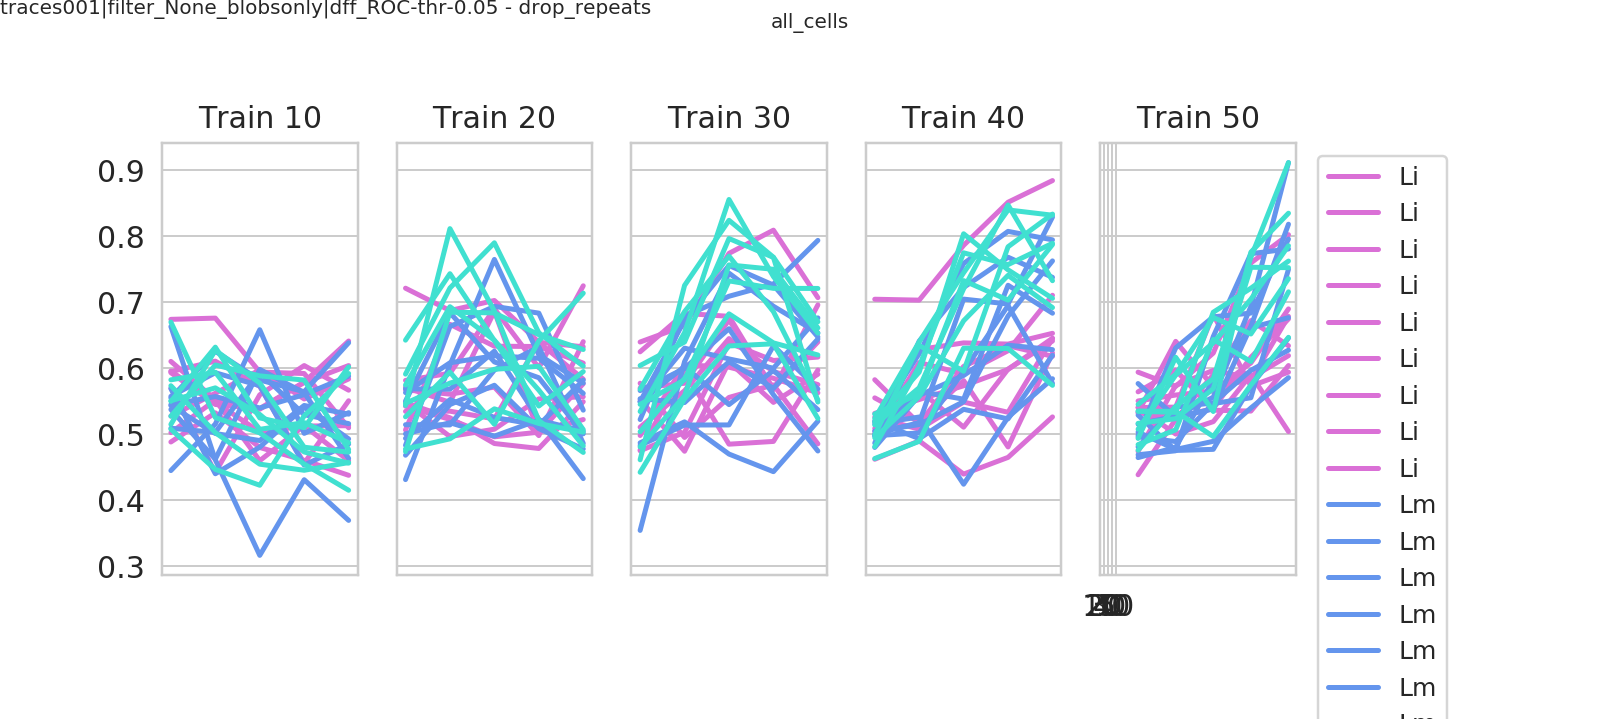

Text(0.5,0.98,u'all_cells')

In [533]:
equal_nums=False
drop_repeats=True
metric = 'heldout_test_score'

if drop_repeats:
    if equal_nums:
        DF = matchedf_drop.copy()
    else:
        DF = dropdf.copy()
else:
    if equal_nums:
        DF = matchdf.copy()
    else:
        DF = meandf.copy()
# DF = matched_df.copy() if equal_nums else xdf.copy()

train_sizes = sorted(DF['train_transform'].unique())
n_sizes = len(train_sizes)

dset_str = 'drop_repeats' if drop_repeats else 'all_datasets'
pass_str = 'match_counts' if equal_nums else 'all_cells'

fig, axn = pl.subplots(1, n_sizes, figsize=(9,4), sharey=True, sharex=True)

for ai, (ax, (train_size, d_)) in enumerate(zip(axn.flat, DF.groupby(['train_transform']))):

    for (visual_area, dkey), g in d_[d_.novel].groupby(['visual_area', 'datakey']):
        ax.plot(train_sizes, g[g.condition=='data'].sort_values(by='train_transform')[metric].values, 
            color=area_colors[visual_area], lw=2, label=visual_area)
#     sns.pointplot(x='test_transform', y=metric, data=d_[d_.condition=='data'], ax=ax, #ci='sd',
#                      hue='visual_area', linestyles='-', alpha=0.5, markers='.', 
#                   palette=area_colors)

#     shuff = d_[(d_.condition=='shuffled') & (d_.train_transform==train_size)]
#     for visual_area, s_ in shuff.groupby(['visual_area']):
#         mean_across_fov = s_[metric].mean()
#         std_across_fov = s_[metric].std()
#         ax.axhline(y=s_[metric].mean(), linestyle=':', color=area_colors[visual_area], lw=0.5)
#         y_plus = np.tile(mean_across_fov+std_across_fov, (n_sizes, ))
#         y_minus = np.tile(mean_across_fov-std_across_fov, (n_sizes, ))
#         ax.fill_between(x=np.arange(0, n_sizes), y1=y_plus, y2=y_minus,
#                         alpha=0.5, color=area_colors[visual_area])
#     if ai<(n_sizes-1):
#         ax.legend_.remove()
#     else:
#         ax.legend(bbox_to_anchor=(1.05, 1))
#     if ai!=0:
#         ax.set_ylabel('')
#         ax.set_xlabel('')
        
    #ax.set_xticks(train_sizes)
    ax.set_title('Train %i' % train_size)
    ax.set_xticks(np.arange(0, n_sizes)) #ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.set_xticklabels([int(i) for i in train_sizes]) 

ax.legend(bbox_to_anchor=(1.05, 1))
putils.label_figure(fig, '%s - %s' % (data_id, dset_str))
pl.subplots_adjust(left=0.1, bottom=0.2, right=0.8, wspace=0.2, top=0.8)
pl.suptitle(pass_str, fontsize=8)


In [498]:
meandf.head()

visual_area              datakey condition  train_transform  test_transform  \
0          Li  20190314_JC070_fov1      data             10.0            10.0   
1          Li  20190314_JC070_fov1      data             10.0            20.0   
2          Li  20190314_JC070_fov1      data             10.0            30.0   
3          Li  20190314_JC070_fov1      data             10.0            40.0   
4          Li  20190314_JC070_fov1      data             10.0            50.0   

         C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
0  0.29737  0.000423    0.029895    -0.031895        0.043130   
1  0.29737       NaN    0.036092     0.040195        0.052069   
2  0.29737       NaN    0.005817    -0.004090        0.008392   
3  0.29737       NaN    0.023796     0.022151        0.034330   
4  0.29737       NaN    0.009877     0.001834        0.014250   

   heldout_test_score  n_trials    randi  score_time  test_score  train_score  \
0            0.503333      60.0  5705.76    0.000163     0.50645     0.909111   
1            0.385000      60.0  5705.76         NaN         NaN          NaN   
2            0.480833      60.0  5705.76         NaN         NaN          NaN   
3            0.581333      60.0  5705.76         NaN         NaN          NaN   
4            0.495833      60.0  5705.76         NaN         NaN          NaN   

   iteration  n_cells  novel  
0       49.5     47.0   True  
1       49.5     47.0   True  
2       49.5     47.0   True  
3       49.5     47.0   True  
4       49.5     47.0   True

In [534]:
means_by_fov = DF.groupby(['condition', 'visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


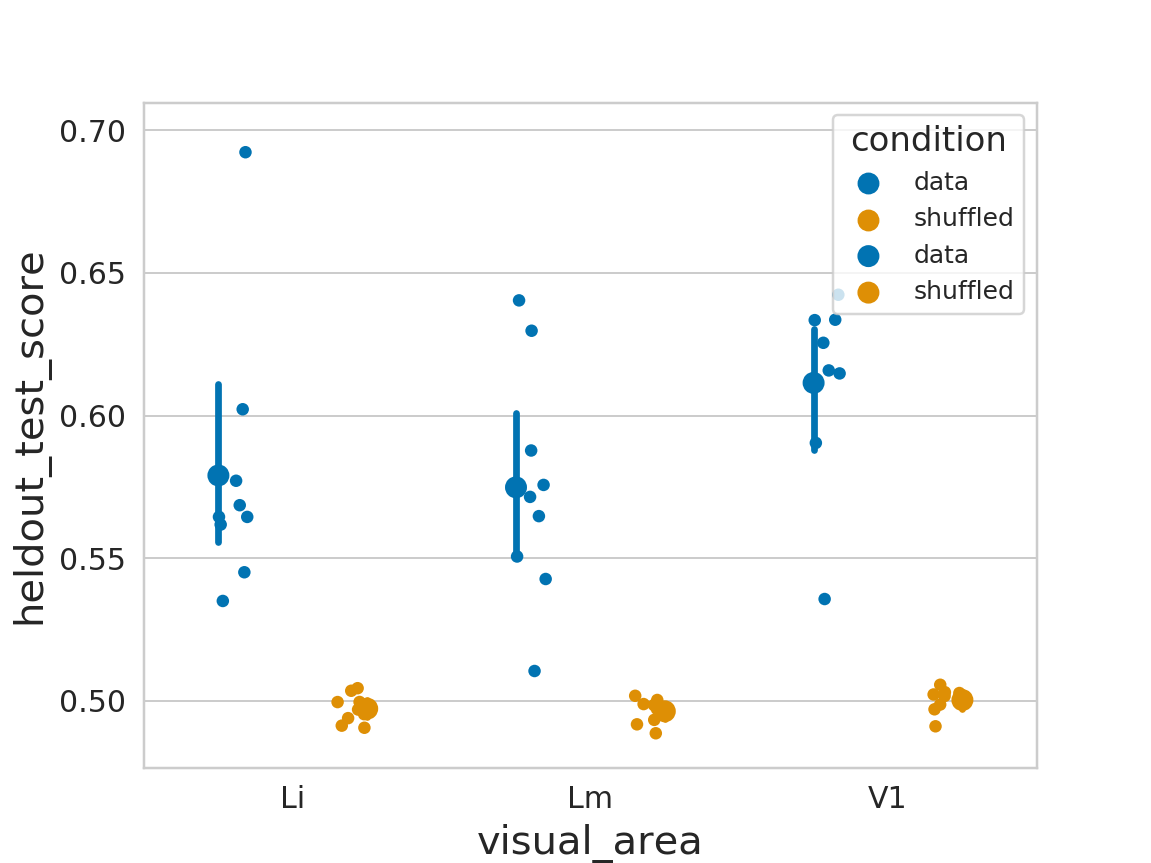

In [535]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y=metric, data=means_by_fov[means_by_fov.novel], ax=ax, 
             hue='condition', dodge=True)
sns.pointplot(x='visual_area', y=metric, data=means_by_fov[means_by_fov.novel], ax=ax, 
             hue='condition', dodge=0.5, join=False)


In [227]:
a_vals = means_by_fov[(means_by_fov.condition=='data') &(means_by_fov.visual_area=='Li')][metric]
b_vals = means_by_fov[(means_by_fov.condition=='data') &(means_by_fov.visual_area=='V1')][metric]
spstats.ttest_1samp(a_vals, b_vals)

Ttest_1sampResult(statistic=13   -0.512086
14    2.060640
15    2.316426
16    2.328121
17    3.472628
18   -2.333927
Name: heldout_test_score, dtype: float64, pvalue=array([0.62688743, 0.08498116, 0.05974069, 0.05879172, 0.0132612 ,
       0.05832646]))

In [131]:
np.tile(std_across_fov, (1,n_sizes))

array([[0.0117807, 0.0117807, 0.0117807, 0.0117807, 0.0117807]])

In [96]:
counts_matched = matched_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()

In [97]:
counts_matched_all = matched_df_all[['visual_area', 'datakey', 'n_cells']].drop_duplicates()

In [101]:
a1 = counts_matched_all[counts_matched_all.visual_area=='Li']['datakey'].values
a0 = counts_matched[counts_matched.visual_area=='Li']['datakey'].values
len(a1), len(a0)

(15, 7)

In [102]:
[a for a in a0 if a not in a1]

[]

In [117]:
counts_matched[counts_matched.visual_area=='Li']

visual_area              datakey  n_cells
30           Li  20190315_JC070_fov1     27.0
180          Li  20190322_JC073_fov1     38.0
270          Li  20190602_JC091_fov1     87.0
360          Li  20190609_JC099_fov1     57.0
420          Li  20190614_JC091_fov1     78.0
480          Li  20191018_JC113_fov1     47.0
510          Li  20191111_JC120_fov1     30.0

In [104]:
not_in_good_one = [a for a in a1 if a not in a0]
counts_matched_all[counts_matched_all.datakey.isin(not_in_good_one)]

visual_area              datakey  n_cells
0            Li  20190314_JC070_fov1      7.0
60           Li  20190316_JC070_fov1      7.0
210          Li  20190327_JC073_fov1     27.0
240          Li  20190422_JC076_fov1     11.0
300          Li  20190606_JC091_fov1     48.0
330          Li  20190607_JC091_fov1     52.0
390          Li  20190612_JC099_fov1     38.0
450          Li  20190617_JC099_fov1      7.0
600          Lm  20190327_JC073_fov1      6.0

In [112]:
meandf[(meandf.datakey.isin(not_in_good_one)) & (meandf.condition=='data') & (meandf.visual_area=='Li')]\
[['datakey', 'n_cells', 'heldout_test_score']].groupby(['datakey']).mean()

n_cells  heldout_test_score
datakey                                         
20190314_JC070_fov1      7.0            0.521287
20190316_JC070_fov1      7.0            0.545067
20190327_JC073_fov1     27.0            0.526973
20190422_JC076_fov1     11.0            0.514067
20190606_JC091_fov1     48.0            0.534909
20190607_JC091_fov1     52.0            0.573907
20190612_JC099_fov1     38.0            0.540613
20190617_JC099_fov1      7.0            0.602203

In [113]:
meandf[(meandf.datakey.isin(not_in_good_one)) & (meandf.condition=='shuffled') & (meandf.visual_area=='Li')]\
[['datakey', 'n_cells', 'heldout_test_score']].groupby(['datakey']).mean()

n_cells  heldout_test_score
datakey                                         
20190314_JC070_fov1      7.0            0.496167
20190316_JC070_fov1      7.0            0.495333
20190327_JC073_fov1     27.0            0.504567
20190422_JC076_fov1     11.0            0.499900
20190606_JC091_fov1     48.0            0.494031
20190607_JC091_fov1     52.0            0.499033
20190612_JC099_fov1     38.0            0.507600
20190617_JC099_fov1      7.0            0.496950

In [114]:
meandf[(meandf.datakey.isin(a0)) & (meandf.condition=='data') & (meandf.visual_area=='Li')]\
[['datakey', 'n_cells', 'heldout_test_score']].groupby(['datakey']).mean()

n_cells  heldout_test_score
datakey                                         
20190315_JC070_fov1     27.0            0.577140
20190322_JC073_fov1     38.0            0.564467
20190602_JC091_fov1     87.0            0.692297
20190609_JC099_fov1     57.0            0.568573
20190614_JC091_fov1     78.0            0.561780
20191018_JC113_fov1     47.0            0.564484
20191111_JC120_fov1     30.0            0.535007

In [115]:
meandf[(meandf.datakey.isin(a1)) & (meandf.condition=='data') & (meandf.visual_area=='Li')]\
[['datakey', 'n_cells', 'heldout_test_score']].groupby(['datakey']).mean()

n_cells  heldout_test_score
datakey                                         
20190314_JC070_fov1      7.0            0.521287
20190315_JC070_fov1     27.0            0.577140
20190316_JC070_fov1      7.0            0.545067
20190322_JC073_fov1     38.0            0.564467
20190327_JC073_fov1     27.0            0.526973
20190422_JC076_fov1     11.0            0.514067
20190602_JC091_fov1     87.0            0.692297
20190606_JC091_fov1     48.0            0.534909
20190607_JC091_fov1     52.0            0.573907
20190609_JC099_fov1     57.0            0.568573
20190612_JC099_fov1     38.0            0.540613
20190614_JC091_fov1     78.0            0.561780
20190617_JC099_fov1      7.0            0.602203
20191018_JC113_fov1     47.0            0.564484
20191111_JC120_fov1     30.0            0.535007

In [116]:
g

visual_area              datakey condition  train_transform  \
1469          V1  20191006_JC110_fov1  shuffled             50.0   

      test_transform         C  fit_time  heldout_MI  heldout_aMI  \
1469            50.0  0.063856  0.000587    0.037272    -0.007668   

      heldout_log2MI  heldout_test_score    randi  score_time  test_score  \
1469        0.053772            0.498429  4805.78    0.000273    0.525627   

      train_score  iteration  n_cells  
1469     0.863975       49.5     86.0

In [46]:
sample_sizes = [2, 8, 25, 50, 63]
n_iterations=10
n_processes=1

cv_nfolds=5
test_split=0.2
class_a=0
class_b=106

i_=[]
for curr_ncells in sample_sizes:
    for visual_area, g_rois in cells.groupby(['visual_area']): #globalcells.groupby(['visual_area']):
        print("... %s (n=%i)" % (visual_area, curr_ncells))
#         for inum in np.arange(0, n_iterations):
#             iterdf = decutils.do_fit(inum, sample_ncells=curr_ncells, global_rois=g_rois, sdf=sdf,
#                                         MEANS=NEURALDATA, df_is_split=True,
#                                         C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds, 
#                                         class_a=class_a, class_b=class_b, do_shuffle=True)
#             iterdf['visual_area'] = visual_area
#             iterdf['n_cells'] = curr_ncells
#             i_.append(iterdf)
        i_chunks = decutils.by_ncells_fit_svm_mp(curr_ncells, g_rois, NEURALDATA, sdf,
                        n_iterations=n_iterations, n_processes=n_processes,
                        C_value=C_value, cv_nfolds=cv_nfolds, test_split=test_split,
                        class_a=class_a, class_b=class_b)
        print("%i items in mp list" % len(i_chunks))
        # DATA - get mean across items
        iter_results = pd.concat(i_chunks, axis=0)
        iter_results['n_cells'] = [curr_ncells for _ in np.arange(0, iter_results.shape[0])]
        iter_results['visual_area'] = visual_area
        i_.append(iter_results)

iterdf = pd.concat(i_, axis=0)
iterdf.groupby(['visual_area', 'n_cells']).mean()

... Li (n=2)
1 items in mp list
... Lm (n=2)
1 items in mp list
... V1 (n=2)
1 items in mp list
... Li (n=8)
1 items in mp list
... Lm (n=8)
1 items in mp list
... V1 (n=8)
1 items in mp list
... Li (n=25)
1 items in mp list
... Lm (n=25)
1 items in mp list
... V1 (n=25)
1 items in mp list
... Li (n=50)
1 items in mp list
... Lm (n=50)
1 items in mp list
... V1 (n=50)
1 items in mp list
... Li (n=63)
1 items in mp list
... Lm (n=63)
1 items in mp list
... V1 (n=63)
1 items in mp list


C  fit_time  heldout_MI  heldout_aMI  \
visual_area n_cells                                                
Li          2         6.18535  0.001484    0.029666     0.029822   
            8         1.13275  0.001669    0.068202     0.085216   
            25        5.61025  0.024990    0.126989     0.170279   
            50        0.11845  0.002604    0.169673     0.231674   
            63       50.66425  0.824827    0.165474     0.225597   
Lm          2         1.87615  0.001110    0.036196     0.039595   
            8        55.61785  0.037647    0.065951     0.081600   
            25        5.71375  0.043253    0.137216     0.185550   
            50       55.12060  1.075714    0.168801     0.231970   
            63       51.10525  1.707361    0.182997     0.252868   
V1          2         8.82010  0.001748    0.024912     0.023738   
            8         6.07645  0.005059    0.090051     0.119174   
            25        5.51530  0.052456    0.175146     0.242973   
            50        1.51300  0.072499    0.169218     0.234317   
            63       56.50390  2.782363    0.215367     0.301777   

                     heldout_log2MI  heldout_test_score  score_time  \
visual_area n_cells                                                   
Li          2              0.042799            0.561983    0.000347   
            8              0.098395            0.605989    0.000356   
            25             0.183207            0.660073    0.000435   
            50             0.244786            0.691107    0.000525   
            63             0.238729            0.674682    0.000712   
Lm          2              0.052220            0.566333    0.000346   
            8              0.095147            0.621862    0.000370   
            25             0.197961            0.662000    0.000435   
            50             0.243529            0.695552    0.000558   
            63             0.264009            0.697000    0.000621   
V1          2              0.035940            0.568678    0.000346   
            8              0.129916            0.650115    0.000393   
            25             0.252682            0.685345    0.000484   
            50             0.244130            0.701724    0.000944   
            63             0.310709            0.702586    0.000760   

                     test_score  train_score  
visual_area n_cells                           
Li          2          0.551105     0.578284  
            8          0.622704     0.666797  
            25         0.669053     0.741375  
            50         0.688169     0.806099  
            63         0.704601     0.836116  
Lm          2          0.571252     0.586107  
            8          0.598257     0.652629  
            25         0.660250     0.758437  
            50         0.681645     0.815617  
            63         0.694500     0.834125  
V1          2          0.573288     0.594508  
            8          0.623705     0.660954  
            25         0.684638     0.761182  
            50         0.687319     0.806529  
            63         0.708668     0.837553

In [52]:
'%03d' % (p_thr*100)


'005'

In [48]:
#iterdf.groupby(['condition', 'visual_area', 'n_cells']).mean()

<IPython.core.display.Javascript object>


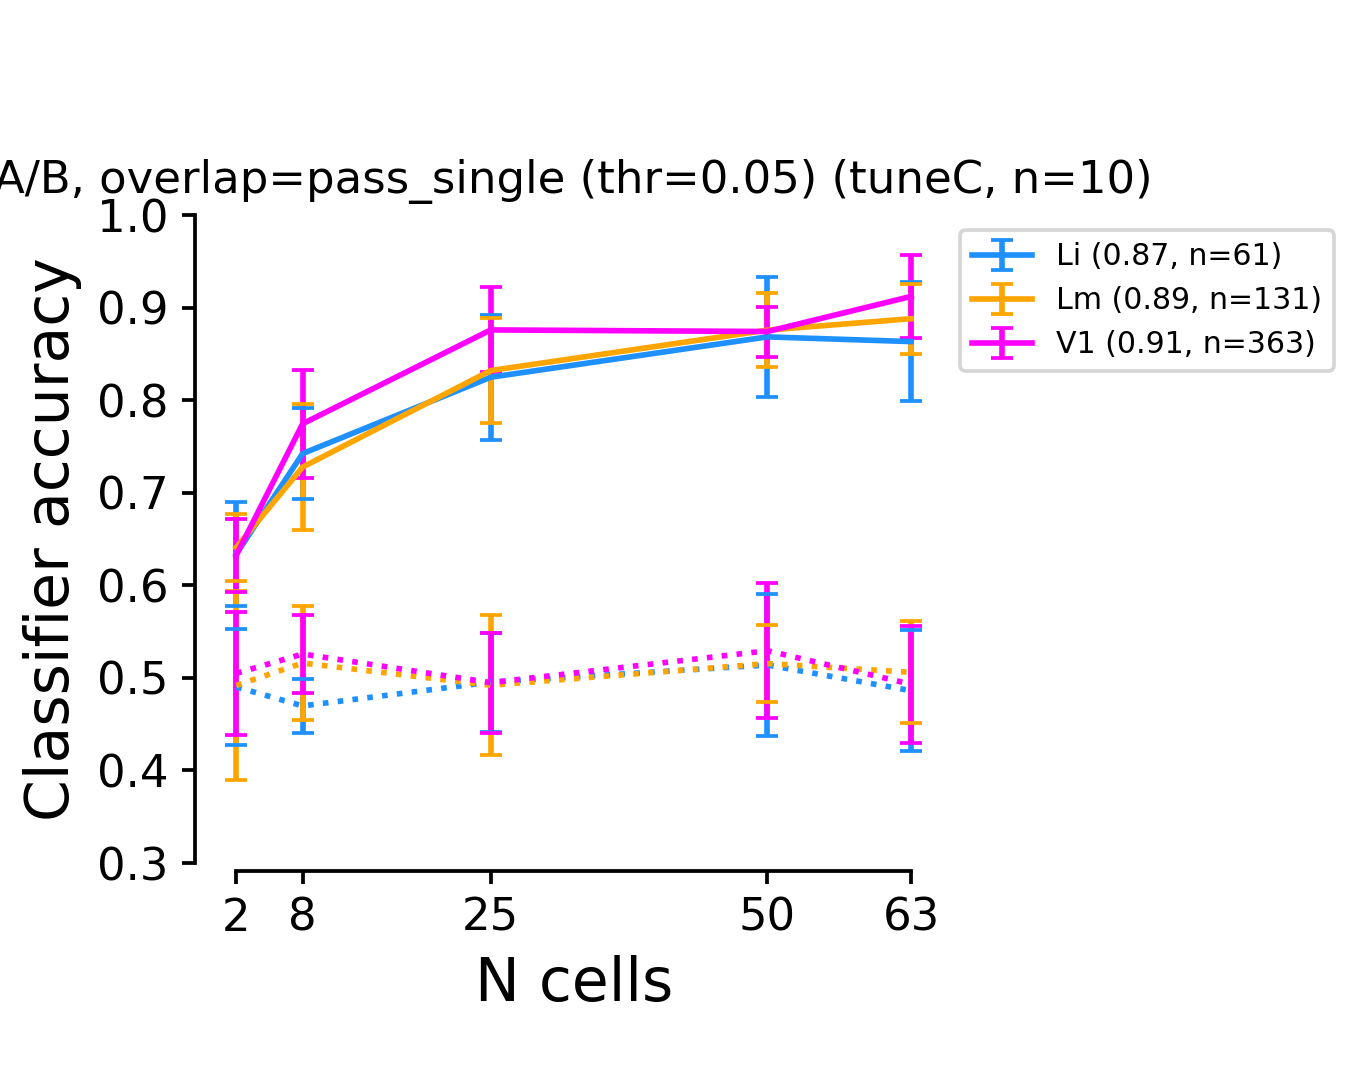

In [53]:
overlap_str='pass_single (thr=%.2f)' % p_thr
c_str = 'tuneC'
# -----------------------------------------------------------------
metric='heldout_test_score'
#metric='heldout_aMI'
fig, ax = pl.subplots( dpi=dpi, figsize=(5,4))
fig.patch.set_alpha(1)

for (visual_area, condition), d_ in iterdf.groupby(['visual_area', 'condition']):
    if visual_area=='Ll': 
        continue
    ncells = [k for k, v in d_.groupby(['n_cells'])]
    means = [v.mean()[metric] for k, v in d_.groupby(['n_cells'])]
    stds = [v.std()[metric] for k, v in d_.groupby(['n_cells'])]
    
    linestyle=':' if condition=='shuffled' else '-'
    max_ncells = cell_counts[visual_area]
    plot_str='%s (%.2f, n=%i)' % (visual_area, max(means), max_ncells) if condition=='data' else None

    ax.errorbar(ncells, means, yerr=stds, color= area_colors[visual_area], 
               label=plot_str, linestyle=linestyle, capsize=3)

ax.legend(bbox_to_anchor=(1.0, 1), fontsize=8)
if 'test_score' in metric:
    ax.set_ylim([0.3, 1])
    ax.set_ylabel('Classifier accuracy')
else:
    ax.set_ylabel(metric)
ax.set_xticks(ncells)
ax.set_xticklabels(ncells)

ax.set_xlabel('N cells')
sns.despine(trim=True, offset=2, ax=ax)
ax.set_title('A/B, overlap=%s (%s, n=%i)' % (overlap_str, c_str, n_iterations))

#putils.label_figure(fig, subdir)
pl.subplots_adjust(left=0.15, bottom=0.2, right=0.7, top=0.8)


pl.savefig(os.path.join(aggregate_dir, 'decoding', 
                        'single_cells', 'by_ncells_%s_iter%i_passthr%03d.svg' % (metric, n_iterations, p_thr*100)))



<IPython.core.display.Javascript object>


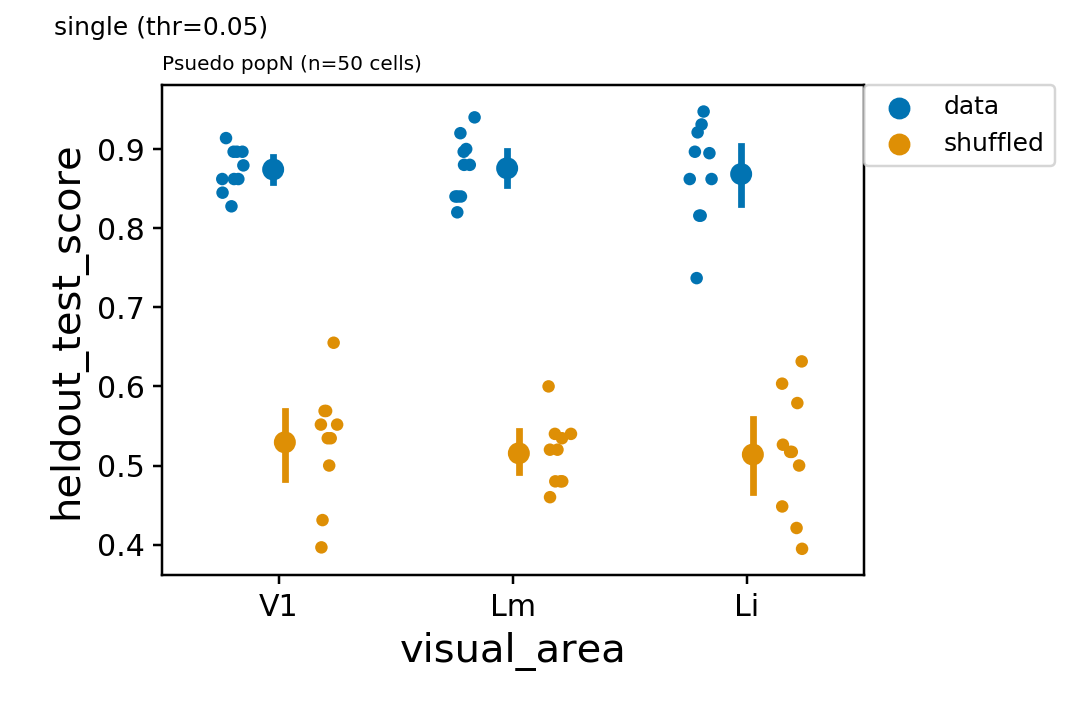

Text(0.05,0.95,u'single (thr=0.05)')

In [54]:
n_hues=2

sample_sizes = iterdf['n_cells'].unique()

curr_ncells = 50
xdf = iterdf[iterdf.n_cells==curr_ncells]



fig, ax = pl.subplots(figsize=(6,4), sharex=True, sharey=True)

#for ai, (curr_ncells, xdf) in enumerate(iterdf.groupby(['n_cells'])):
    #ax=axn[ai]
sns.stripplot(x='visual_area', y='heldout_test_score', ax=ax, data=xdf,
             hue='condition', palette='colorblind', dodge=True, order=visual_areas)
sns.pointplot(x='visual_area', y='heldout_test_score', ax=ax, data=xdf,
             hue='condition', palette='colorblind', dodge=True, join=False, order=visual_areas)
ax.set_title("Psuedo popN (n=%i cells)" % (curr_ncells), loc='left', fontsize=8)

# Get the handles and labels.
handles, labels = ax.get_legend_handles_labels()
# When creating the legend, only use the first two elements
l = pl.legend(handles[0:n_hues], labels[0:n_hues], bbox_to_anchor=(1.0, 1), loc=2, borderaxespad=0.)
pl.subplots_adjust(right=0.8, left=0.15, bottom=0.2)  

fig.text(0.05, 0.95, 'single (thr=%.2f)' % p_thr)

#ax.set_title("Psuedo popN (n%i cells), pass_single (thr=%.2f)" % (curr_ncells, p_thr), loc='left')

##### Plot by_ncells (pass_single)

<IPython.core.display.Javascript object>


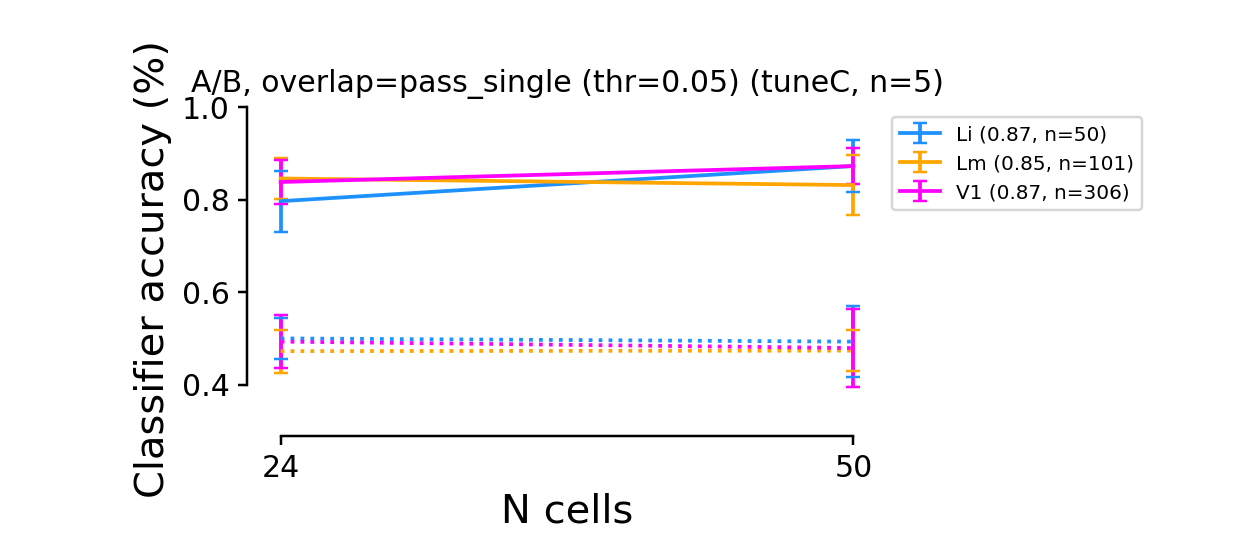

In [94]:
overlap_str='pass_single (thr=%.2f)' % p_thr
c_str = 'tuneC'
# -----------------------------------------------------------------
metric='heldout_test_score'
#metric='heldout_aMI'
fig, ax = pl.subplots( figsize=(7,3))
fig.patch.set_alpha(1)

for (visual_area, condition), d_ in iterdf.groupby(['visual_area', 'condition']):
    if visual_area=='Ll': 
        continue
    ncells = [k for k, v in d_.groupby(['n_cells'])]
    means = [v.mean()[metric] for k, v in d_.groupby(['n_cells'])]
    stds = [v.std()[metric] for k, v in d_.groupby(['n_cells'])]
    
    linestyle=':' if condition=='shuffled' else '-'
    max_ncells = cell_counts[visual_area]
    plot_str='%s (%.2f, n=%i)' % (visual_area, max(means), max_ncells) if condition=='data' else None

    ax.errorbar(ncells, means, yerr=stds, color= area_colors[visual_area], 
               label=plot_str, linestyle=linestyle, capsize=3)

ax.legend(bbox_to_anchor=(1.0, 1), fontsize=8)
if 'test_score' in metric:
    ax.set_ylim([0.3, 1])
    ax.set_ylabel('Classifier accuracy (%)')
else:
    ax.set_ylabel(metric)
ax.set_xticks(ncells)
ax.set_xticklabels(ncells)

ax.set_xlabel('N cells')
sns.despine(trim=True, offset=2, ax=ax)
ax.set_title('A/B, overlap=%s (%s, n=%i)' % (overlap_str, c_str, n_iterations))

#putils.label_figure(fig, subdir)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.7, top=0.8)


# Plot all results

In [17]:
visual_area=None
visual_areas=['V1', 'Lm', 'Li'] #, 'Ll']
    
if 'Ll' in visual_areas:
    area_colors.update({'Ll': 'k'})
print(dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells


In [38]:
analysis_type = 'by_ncells'
trial_epoch='plushalf'

threshold_dff = False
has_retino=False
overlap_thr=None #0 #0.

match_distns=False
threshold_snr=False
max_snr_thr=None # if threshold_snr is False else 15.

C_value=None
n_iterations = 100

response_type = 'dff'
responsive_test='ROC' #'nstds'
responsive_thr = 10.0 if responsive_test=='nstds' else 0.05
         
# -----------------------------------------------------------------------------------

if threshold_snr:
    match_str = 'snr_' if max_snr_thr is None else 'snrlim_'
else:
    match_str = 'matchdistns_' if match_distns else ''
if threshold_dff:
    overlap_str = 'threshdff'
    has_rfs=False
else:
    if has_retino:
        overlap_str = 'retino'
        has_rfs =False
    else:
        overlap_str='noRF' if overlap_thr is None else 'overlap%.1f' % overlap_thr

tmpid = dc.create_results_id(prefix=analysis_type, response_type=response_type,
                     responsive_test=responsive_test,
                     visual_area=None,trial_epoch=trial_epoch,
                     C_value=C_value, overlap_thr=overlap_thr, has_retino=has_retino,
                            threshold_dff=threshold_dff)

_, resp_str, tepoch, c_str = tmpid.split('__')
results_subid = '%s__%s__%s' % (resp_str, tepoch, c_str)
data_id = results_subid


subdir = '%s%s_iter%i' % (match_str, resp_str, n_iterations)
#subdir = 'matchdistns_dff-nstds_overlap-0.0_iter-100'
assert os.path.exists(os.path.join(dst_dir, subdir)), "Results <%s> does not exist" % subdir
curr_src_dir = os.path.join(dst_dir, subdir)
print(curr_src_dir)

# rename if needed
for k in os.listdir(curr_src_dir):
    if 'no-rfs' in k:
        new_name = k.replace('no-rfs', 'noRF')
        os.rename(os.path.join(curr_src_dir, k), os.path.join(curr_src_dir, new_name))
        
# load
r_=[]
for visual_area in visual_areas:
    curr_prefix = tmpid.replace('None', visual_area)
    print(curr_prefix)
    tmp_files = glob.glob(os.path.join(curr_src_dir, '%s_*.pkl' % curr_prefix))
    #tmp_files = glob.glob(os.path.join(curr_src_dir, '*_%s_*.pkl' % visual_area))
    for f in tmp_files:
        with open(f, 'rb') as f:
            res = pkl.load(f)
        res['visual_area'] = [visual_area for _ in np.arange(0, res.shape[0])]
        r_.append(res)
results = pd.concat(r_, axis=0)
results.shape

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/dff-ROC_noRF_iter100
by_ncells_V1__dff-ROC_noRF__plushalf__tuneC
by_ncells_Lm__dff-ROC_noRF__plushalf__tuneC
by_ncells_Li__dff-ROC_noRF__plushalf__tuneC


(4200, 12)

In [39]:
# curr_max=128
# results[(results['n_cells']==curr_max) & (results['condition']=='data')].groupby(['visual_area']).mean()
# results[(results.condition=='data')].groupby(['visual_area', 'n_cells']).mean()

In [40]:
if not os.path.exists(os.path.join(curr_src_dir, 'figures')):
    os.makedirs(os.path.join(curr_src_dir, 'figures'))
print(curr_src_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/dff-ROC_noRF_iter100


<IPython.core.display.Javascript object>


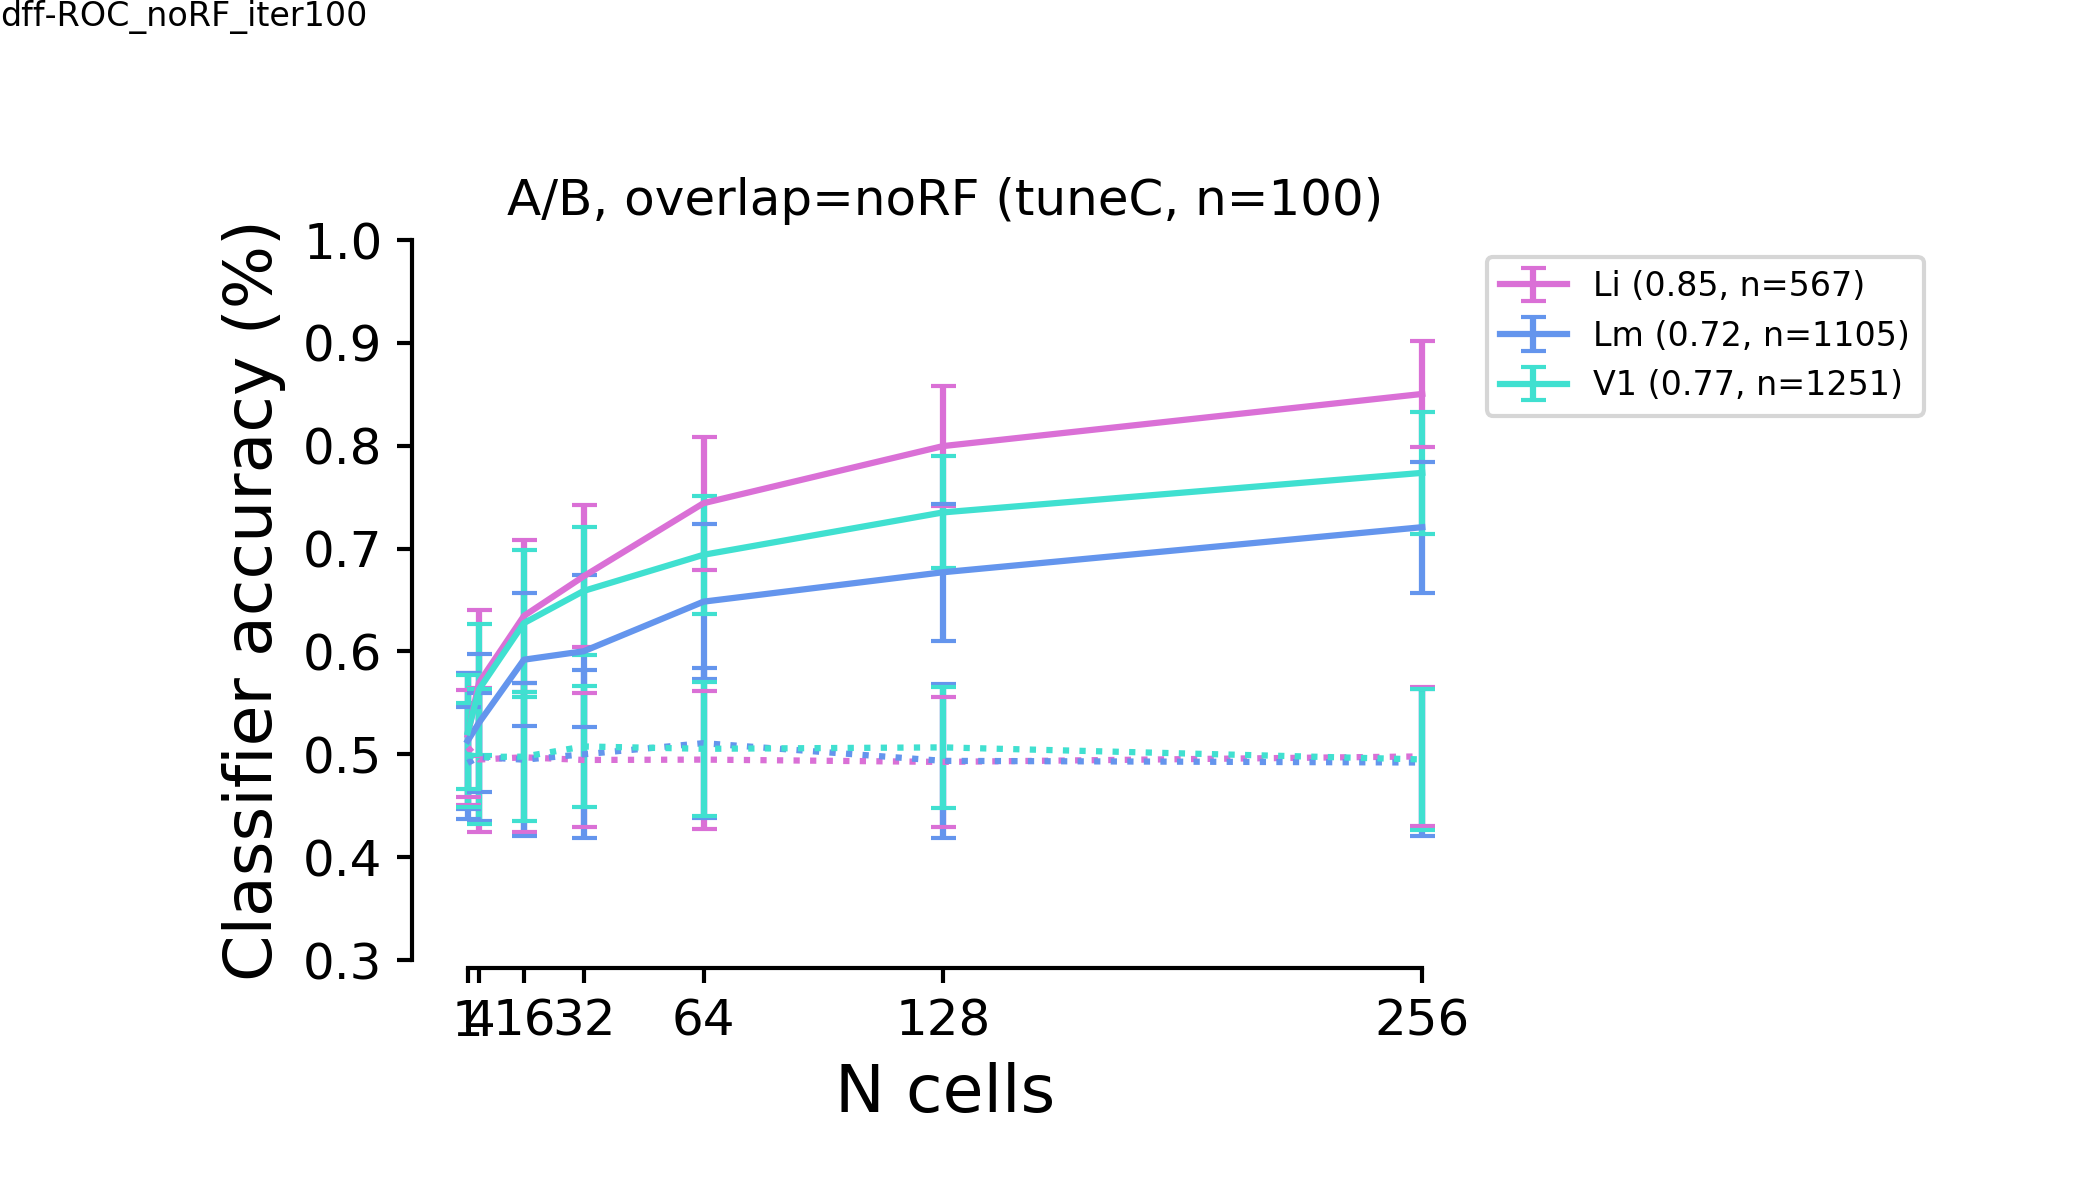

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/dff-ROC_noRF_iter100', 'heldout_test_score_dff-ROC_noRF__plushalf__tuneC')


In [41]:
# -----------------------------------------------------------------
metric='heldout_test_score'
#metric='heldout_aMI'
fig, ax = pl.subplots(dpi=dpi, figsize=(7,4))
fig.patch.set_alpha(1)

for (visual_area, condition), iterdf in results.groupby(['visual_area', 'condition']):
    ncells = [k for k, v in iterdf.groupby(['n_cells'])]
    means = [v.mean()[metric] for k, v in iterdf.groupby(['n_cells'])]
    stds = [v.std()[metric] for k, v in iterdf.groupby(['n_cells'])]
    
    ci_vals = np.array([np.percentile(idf[metric].values, [2.5, 97.5]) \
                        for n, idf in iterdf.groupby(['n_cells'])])
    lower_ = means - ci_vals[:, 0]
    upper_ = ci_vals[:, 1] - means
    ci_rel = np.vstack([lower_, upper_])
    
    linestyle=':' if condition=='shuffled' else '-'
    max_ncells = cell_counts[visual_area]
    
    plot_str='%s (%.2f, n=%i)' % (visual_area, max(means), max_ncells) if condition=='data' else None

    ax.errorbar(ncells, means, yerr=stds, color= area_colors[visual_area], 
               label=plot_str, linestyle=linestyle, capsize=3)

ax.legend(bbox_to_anchor=(1.0, 1), fontsize=8)
if 'test_score' in metric:
    ax.set_ylim([0.3, 1])

    ax.set_ylabel('Classifier accuracy (%)')
else:
    ax.set_ylabel(metric)
ax.set_xticks(ncells)
ax.set_xticklabels(ncells)

ax.set_xlabel('N cells')
sns.despine(trim=True, offset=2, ax=ax)
ax.set_title('A/B, overlap=%s (%s, n=%i)' % (overlap_str, c_str, n_iterations))

#ax.set_xlim([0, 20])
putils.label_figure(fig, subdir)
pl.subplots_adjust(left=0.2, bottom=0.2, right=0.7, top=0.8)

figname='%s_%s' % (metric, data_id)
pl.savefig(os.path.join(curr_src_dir, 'figures',  '%s.svg' % figname))
print(curr_src_dir, figname)

In [42]:
meanr = results[(results.condition=='data')].groupby(['visual_area', 'n_cells']).mean().reset_index()
meanr.head()

visual_area  n_cells         C  fit_time  heldout_MI  heldout_aMI  \
0          Li        1  10.65394  0.003285    0.011437     0.004830   
1          Li        4   2.04967  0.001245    0.024461     0.022860   
2          Li       16   2.42803  0.007739    0.041396     0.046190   
3          Li       32  13.46464  0.132516    0.074894     0.094095   
4          Li       64   0.07561  0.002982    0.108022     0.141142   

   heldout_log2MI  heldout_test_score  score_time  test_score  train_score  
0        0.016500            0.525861    0.000359    0.519676     0.531728  
1        0.035290            0.563288    0.000296    0.553489     0.587673  
2        0.059721            0.613425    0.000378    0.617602     0.694383  
3        0.108049            0.666737    0.000545    0.656887     0.771778  
4        0.155843            0.702858    0.000812    0.700575     0.850469

In [28]:
# results.groupby(['condition', 'visual_area', 'n_cells']).mean() #['n_cells'].unique()

## Check properties of input cells

In [115]:
visual_area='Li'
print(analysis_type)

input_dfile = glob.glob(os.path.join(curr_src_dir, 'cells_%s_%s.pkl' % (analysis_type, visual_area)))[0]
print(input_dfile)
with open(input_dfile, 'rb') as f:
    I = pkl.load(f)
I.head()


by_ncells
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells/dff-nstds_noRF_iter100/cells_by_ncells_Li.pkl


datakey  dset_roi  roi visual_area animalid   session  fovnum  \
0  20190315_JC070_fov1      85.0    0          Li    JC070  20190315       1   
1  20190315_JC070_fov1      86.0    1          Li    JC070  20190315       1   
2  20190315_JC070_fov1      99.0    2          Li    JC070  20190315       1   
3  20190315_JC070_fov1     102.0    3          Li    JC070  20190315       1   
4  20190315_JC070_fov1     103.0    4          Li    JC070  20190315       1   

    cell  
0   85.0  
1   86.0  
2   99.0  
3  102.0  
4  103.0

In [116]:
I[['visual_area','datakey', 'roi']].drop_duplicates().groupby(['visual_area']).count()

datakey   roi
visual_area               
Li              1069  1069

In [117]:
ALL = NEURALDATA.copy()

In [118]:
df = NEURALDATA[NEURALDATA['visual_area']==visual_area].copy()

In [119]:
meandf = NEURALDATA.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()

In [120]:
filtdf = ALL.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()

<IPython.core.display.Javascript object>


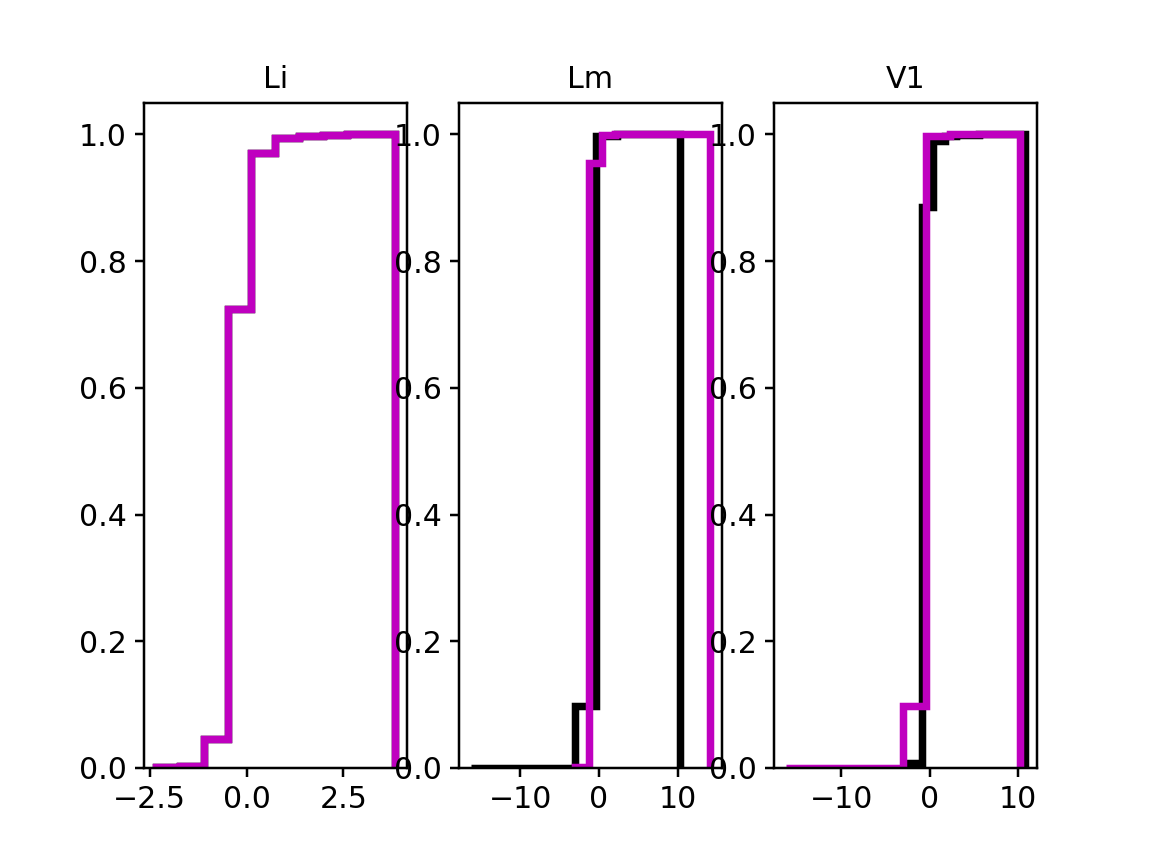

IndexError: index 3 is out of bounds for axis 0 with size 3

In [121]:
fig, axn = pl.subplots(1,3)

ai=0
for visual_area, g in meandf.groupby(['visual_area']):
    if visual_area=='Ll':
        continue
    ax=axn[ai]
    ax.hist(g['response'],  color='k', cumulative=True, histtype='step', normed=True, lw=3)
    ai+=1
    ax.set_title(visual_area)
    
ai=0
for visual_area, g in filtdf.groupby(['visual_area']):
    ax=axn[ai]
    ax.hist(g['response'],  color='m', cumulative=True, histtype='step', normed=True, lw=3)
    ai+=1
    
for ax in axn.flat:
    ax.set_xlim([-5, 14])

In [307]:
ax.get_xlim()

(-2.852399138219859, 11.458270895932976)

#### De bug decode

In [39]:
curr_ncells=78
curr_visual_area='Li'

In [40]:
gdf = CELLS[CELLS['visual_area']==curr_visual_area]
results_id = dc.create_results_id(prefix=results_prefix,
                visual_area=curr_visual_area, C_value=C_value,
                response_type=response_type, responsive_test=responsive_test,
                overlap_thr=overlap_thr, trial_epoch=trial_epoch)
print(results_id)

by_ncells_Li__dff-nstds_overlap0.0__plushalf__tuneC


In [41]:
# # ----------------------------------------------
# # Do decode w CURR_NCELLS, CURR_VISUAL_AREA
# # ----------------------------------------------
# print("**** %s (n=%i cells)****" % (curr_visual_area, curr_ncells))
# decode_by_ncells(curr_ncells, gdf, sdf, NEURALDATA,
#                 C_value=C_value,
#                 n_iterations=n_iterations, n_processes=n_processes,
#                 results_id=results_id,
#                 class_a=class_a, class_b=class_b,
#                 dst_dir=dst_dir, create_new=create_new, verbose=verbose)
# print("***** finished %s, ncells=%i *******" % (curr_visual_area, curr_ncells))

In [42]:
cv_nfolds=5
test_split=0.2
class_a=0
class_b=106
n_iterations=50

# Decoding -----------------------------------------------------
i_chunks = decutils.by_ncells_fit_svm_mp(curr_ncells, gdf, NEURALDATA, sdf,
                n_iterations=n_iterations, n_processes=4,
                C_value=C_value, cv_nfolds=cv_nfolds, test_split=test_split,
                class_a=class_a, class_b=class_b)
print("%i items in mp list" % len(i_chunks))
# DATA - get mean across items
iter_results = pd.concat(i_chunks, axis=0)

... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
... shuffling
4 items in mp list


In [43]:
print(iter_results.shape)
iter_results.groupby(['condition']).mean()

(100, 10)


C   fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
condition                                                                 
data       26.51122   1.323499    0.026769     0.020819        0.038620   
shuffled   83.64538  13.476567    0.015819     0.004797        0.022822   

           heldout_test_score  score_time  test_score  train_score  
condition                                                           
data                 0.576438    0.001984    0.585772     0.807623  
shuffled             0.485143    0.003749    0.510087     0.783576

In [28]:
print(iter_results.shape)
iter_results.groupby(['condition']).mean()

(200, 10)


C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
condition                                                               
data       0.09199  0.011159    0.062957     0.073323        0.090828   
shuffled   0.26218  0.021237    0.017861     0.007028        0.025769   

           heldout_test_score  score_time  test_score  train_score  
condition                                                           
data                 0.652095    0.004245    0.642675     0.884859  
shuffled             0.495274    0.003750    0.510479     0.869795

In [347]:
print(iter_results.shape)
iter_results.groupby(['condition']).mean()

(200, 10)


C  fit_time  heldout_MI  heldout_aMI  heldout_log2MI  \
condition                                                               
data       0.03565  0.020486    0.271364     0.383621        0.391495   
shuffled   8.07652  2.229450    0.006783    -0.003054        0.009786   

           heldout_test_score  score_time  test_score  train_score  
condition                                                           
data                 0.841034    0.005316    0.838855     0.928556  
shuffled             0.502586    0.005426    0.504092     0.836293

In [129]:
iter_results.shape

(200, 10)

# 2. Simulate SNR

In [28]:
from pipeline.python.classifications import aggregate_data_stats as aggr

In [29]:
# trial_epoch='plushalf'
mean_snr = aggr.get_mean_snr(experiment=experiment, traceid=traceid, responsive_test=responsive_test,
                                        responsive_thr=responsive_thr, trial_epoch=trial_epoch)

... loading SNR (aggr_by_cell_blobs_traces001_nstds-thr-10.00_snr_plushalf)
(266905, 5)


In [325]:
# SNR, _ = aggr.load_snr_data(experiment=experiment, traceid=traceid, responsive_test=responsive_test,
#                                         responsive_thr=responsive_thr, trial_epoch=trial_epoch)

... loading SNR (aggr_blobs_trialmeans_traces001_nstds-thr-10.00_snr_plushalf)
(8088907, 8)


In [160]:
trial_epoch='plushalf'

In [257]:
#datakey = '20190315_JC070_fov1'
print(trial_epoch)
d_=[]
for (visual_area, datakey), g in mean_snr.groupby(['visual_area', 'datakey']):
    # print("... %s: loading all metrics" % visual_area)
    session, animalid, fovnum = putils.split_datakey_str(datakey)
    metrics = aggr.load_trial_metrics(animalid, session, fovnum, experiment, traceid=traceid,
                            responsive_test=responsive_test, responsive_thr=responsive_thr, epoch=trial_epoch)
    tmpd = metrics[metrics['cell'].isin(g['cell'].unique())][['dff', 'stim_mean', 'stim_mean_df', 'base_std', 'cell', 'config', 'trial']]
    tmpd['visual_area']=visual_area
    tmpd['datakey']=datakey
    d_.append(tmpd)
METRICS = pd.concat(d_, axis=0).reset_index(drop=True)
METRICS.head()

plushalf


dff    stim_mean  stim_mean_df    base_std  cell     config  \
0  0.019542  1563.586771      0.019542  105.973758    85  config001   
1  0.018217  1525.349857      0.018217   69.026756    86  config001   
2 -0.012438  1435.352415     -0.012438   40.476762    99  config001   
3 -0.012609  1419.480827     -0.012609   70.516288   102  config001   
4  0.020979  1442.556590      0.020979   62.280252   103  config001   

        trial visual_area              datakey  
0  trial00027          Li  20190315_JC070_fov1  
1  trial00027          Li  20190315_JC070_fov1  
2  trial00027          Li  20190315_JC070_fov1  
3  trial00027          Li  20190315_JC070_fov1  
4  trial00027          Li  20190315_JC070_fov1

In [258]:
metrics.head()

base_mean  base_mean_df    base_std  base_std_df     config         df  \
0  878.531334 -2.482582e-17  102.118939     0.116238  config001 -74.063613   
1  844.267530  6.044548e-17   89.232275     0.105692  config001  38.728443   
2  865.404883 -7.590379e-17  105.539344     0.121954  config001 -41.861489   
3  849.490144 -3.814850e-16   74.376722     0.087555  config001 -26.367439   
4  848.028481 -4.009139e-17   90.436656     0.106643  config001 -36.633477   

        dff        snr   stim_mean  stim_mean_df       trial    zscore  cell  
0 -0.084304   7.877752  804.467721     -0.084304  trial00024 -0.725268     0  
1  0.045872   9.895478  882.995973      0.045872  trial00024  0.434018     1  
2 -0.048372   7.803188  823.543395     -0.048372  trial00024 -0.396643     2  
3 -0.031039  11.066940  823.122705     -0.031039  trial00024 -0.354512     3  
4 -0.043198   8.971970  811.395004     -0.043198  trial00024 -0.405073     4

<IPython.core.display.Javascript object>


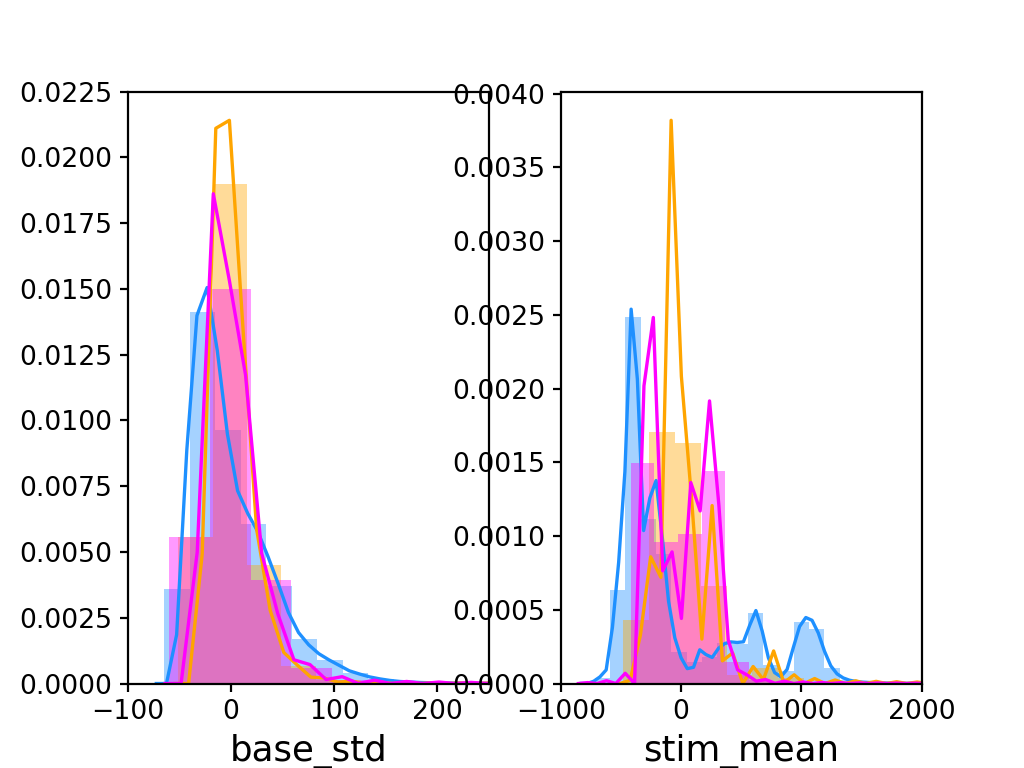

Li: base (39.55) | stim (538.93)
Lm: base (23.82) | stim (228.51)
V1: base (30.08) | stim (252.06)


In [259]:
fig, axn = pl.subplots(1, 2)
for visual_area, g in METRICS.groupby(['visual_area']):
    if visual_area=='Ll':
        continue
    ax=axn[0]
    vals = g['base_std'] - g['base_std'].mean()
    #print('%s: %.2f' % (visual_area, np.std(vals)))
    sns.distplot(vals, ax=ax, color=area_colors[visual_area])
    ax.set_xlim([-100, 250])
    
    ax=axn[1]
    vals2 = g['stim_mean'] - g['stim_mean'].mean()
    print('%s: base (%.2f) | stim (%.2f)' % (visual_area, np.std(vals), np.std(vals2)))
    sns.distplot(vals2, ax=ax, color=area_colors[visual_area])
    
    ax.set_xlim([-1000, 2000])

In [302]:
visual_area='V1'
datakey = '20190622_JC085_fov1'
currdf = METRICS[(METRICS['visual_area']==visual_area) & (METRICS['datakey']==datakey)].copy()

roidf = currdf[currdf['cell']==rid]
roidf.shape

curr_snr = mean_snr[(mean_snr['visual_area']==visual_area) & (mean_snr['datakey']==datakey)].copy()
currdf['rep']=None
for cfg, g in currdf.groupby(['config']):
    t_lut = dict((t, i) for i, t in enumerate(sorted(g['trial'].unique())))
    currdf.loc[g.index, 'rep'] = [t_lut[t] for t in g['trial'].values]


In [303]:
currdf['rep']=None
for cfg, g in currdf.groupby(['config']):
    t_lut = dict((t, i) for i, t in enumerate(sorted(g['trial'].unique())))
    currdf.loc[g.index, 'rep'] = [t_lut[t] for t in g['trial'].values]


<IPython.core.display.Javascript object>


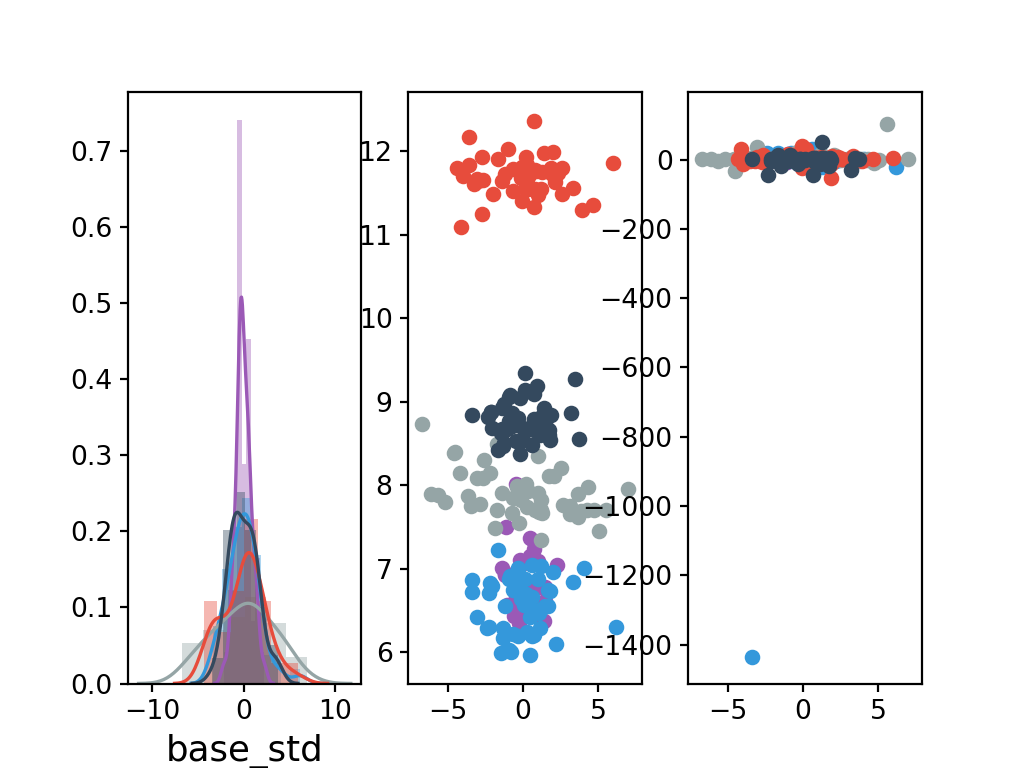

In [349]:
noisy_df = currdf[['stim_mean', 'base_std']].copy()
added_noise = np.random.normal(0, 30, noisy_df.shape)
noisy_df += added_noise

fig, axn = pl.subplots(1, 3)
curr_rois = currdf['cell'].unique()

for rid in curr_rois[0:5]:
    
    df_ = currdf[currdf['cell']==rid].copy()
    df_[['stim_mean', 'base_std']] = df_[['stim_mean', 'base_std']] - df_[['stim_mean', 'base_std']].mean()
    
    noisy_df = df_[['config', 'stim_mean', 'base_std']].copy()
    added_noise = np.random.normal(0,1, (noisy_df.shape[0], 2))
    noisy_df[['stim_mean', 'base_std']] += added_noise
    
    noisy_df['snr'] = noisy_df['stim_mean']/noisy_df['base_std']
    #
    noise_vals = df_.groupby(['config'])['base_std'].mean()
    orig_snr = curr_snr[curr_snr['cell']==rid].groupby(['config'])['snr'].mean()
    
    noisy_snr = noisy_df.groupby(['config'])['snr'].mean()
    
    ax=axn[0]
    sns.distplot(noise_vals, ax=ax)
    
    ax=axn[1]
    ax.scatter(noise_vals, orig_snr)
    
    ax=axn[2]
    #ax.scatter(noise_vals, noisy_snr)
    ax.scatter(noise_vals, noisy_snr)

In [260]:
# nconds = len(roidf['config'].unique())
# nreps = int(roidf['config'].value_counts().unique())

# np.cov(roidf['dff'].reshape(nconds, nreps))


In [50]:
# train_configs = sdf[sdf['morphlevel'].isin([0, 106])].index.tolist()

In [95]:
# mean_snr = SNR.groupby(['visual_area', 'datakey', 'cell', 'config']).mean().reset_index()
area_colors.update({'Ll': 'k'})

<IPython.core.display.Javascript object>


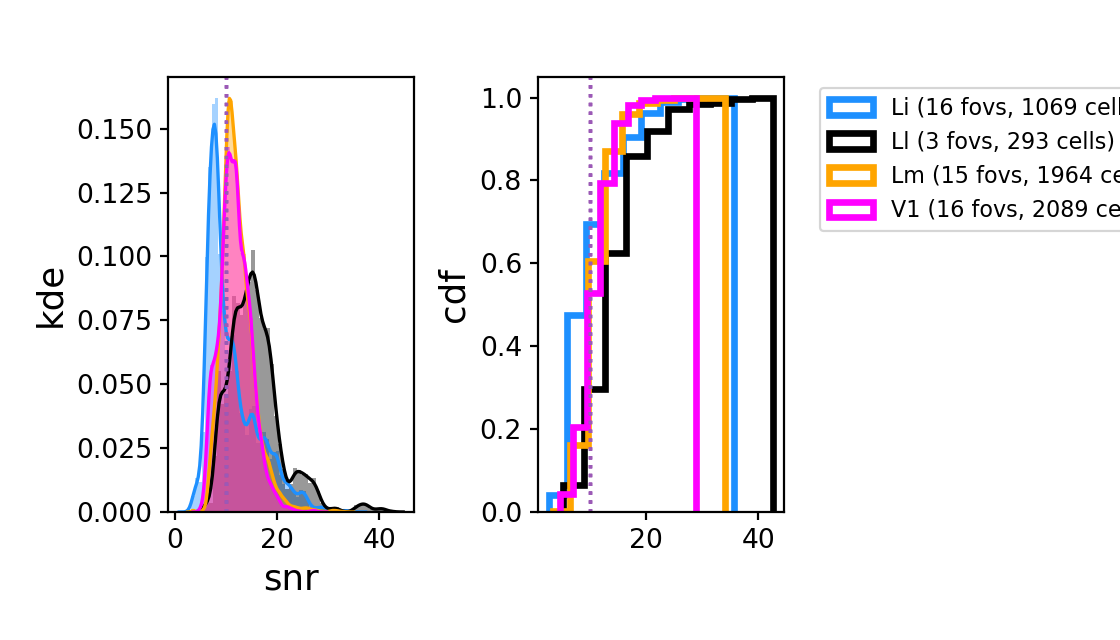

In [261]:
cdf = False

fig, axn = pl.subplots(1, 2, figsize=(7,4))

for visual_area, g in mean_snr.groupby(['visual_area']):
    cnts = g[['datakey', 'cell']].drop_duplicates().groupby(['datakey']).count().reset_index()
    nfovs = cnts.shape[0]
    ncells = cnts['cell'].sum()
    # print(nfovs, ncells)
    label = '%s (%i fovs, %i cells)' % (visual_area, nfovs, ncells)
    vals = g['snr'] #gdf.groupby(['cell']).mean()['snr']
    ax=axn[1]
    ax.hist(vals, color=area_colors[visual_area], cumulative=True, normed=True, 
           histtype='step', lw=3, label=label)
    ax.set_ylabel('cdf')
    ax.axvline(x=10., linestyle=':')
    
    ax=axn[0]
    sns.distplot(vals, ax=ax, label=visual_area, color=area_colors[visual_area])
    ax.set_ylabel('kde')
    ax.set_xlabel('snr')
    ax.axvline(x=10., linestyle=':')
    
axn[1].legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(left=0.15, right=0.7, bottom=0.2, wspace=0.5)

### Threshold SNR

In [63]:
snr_thr=10.
max_snr_thr=15.

train_configs_only  = True

cfg_str = 'train_configs' if train_configs_only else 'all_configs'

train_configs = sdf[sdf['morphlevel'].isin([0, 106])].index.tolist()

incl_snr = mean_snr[mean_snr['config'].isin(train_configs)].copy() if train_configs_only else mean_snr.copy()
thresh_snr = incl_snr[(incl_snr['snr']>=snr_thr)& (incl_snr['snr']<=max_snr_thr)]\
                    .groupby(['visual_area', 'datakey', 'cell']).mean().reset_index()
thresh_snr.groupby(['visual_area']).count()

datakey  cell   snr
visual_area                     
Li               328   328   328
Ll               138   138   138
Lm              1381  1381  1381
V1              1423  1423  1423

<IPython.core.display.Javascript object>


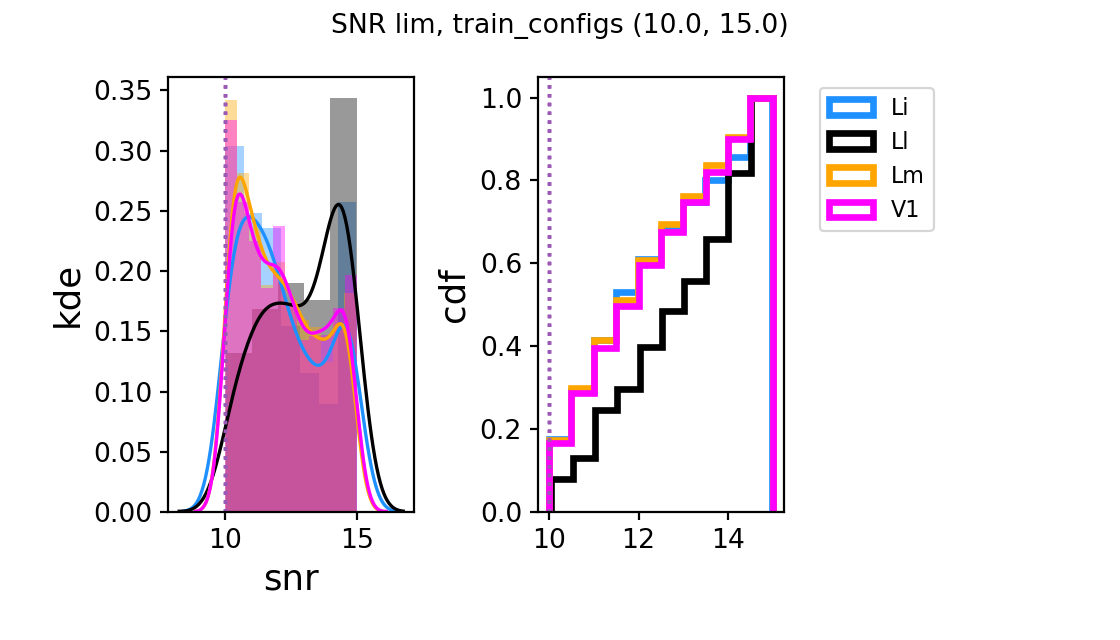

In [61]:
cdf = False

fig, axn = pl.subplots(1, 2, figsize=(7,4))

for visual_area, g in thresh_snr.groupby(['visual_area']):
    vals = g['snr'] #gdf.groupby(['cell']).mean()['snr']
    ax=axn[1]
    ax.hist(vals, color=area_colors[visual_area], cumulative=True, normed=True, 
           histtype='step', lw=3, label=visual_area)
    ax.set_ylabel('cdf')
    ax.axvline(x=10., linestyle=':')
    
    ax=axn[0]
    sns.distplot(vals, ax=ax, label=visual_area, color=area_colors[visual_area])
    ax.set_ylabel('kde')
    ax.set_xlabel('snr')
    ax.axvline(x=10., linestyle=':')

fig.suptitle('SNR lim, %s (%.1f, %.1f)' % (cfg_str, snr_thr, max_snr_thr))
    
axn[1].legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(left=0.15, right=0.7, bottom=0.2, wspace=0.5)

In [157]:
reload(aggr)

<module 'pipeline.python.classifications.aggregate_data_stats' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/aggregate_data_stats.py'>

# Select subset of globalcells that pass SNR thr

In [163]:
snr_thr=10.0
max_snr_thr=15.


remove_too_few=True
min_ncells=5
stack_neuraldf=True

globalcells, cell_counts = aggr.global_cells(cells, remove_too_few=remove_too_few,
                                             min_ncells=min_ncells,  return_counts=True)

CELLS = aggr.threshold_cells_by_snr(mean_snr, globalcells, snr_thr=snr_thr, max_snr_thr=max_snr_thr)
NEURALDATA = aggr.get_neuraldata(CELLS, MEANS, stack=stack_neuraldf, verbose=False)



Assigned visual areas: [u'Li' u'Ll' u'Lm' u'V1']


In [164]:
CELLS.groupby(['visual_area']).count()

datakey  dset_roi   roi  animalid  session  fovnum  cell
visual_area                                                          
Li               359       359   359       359      359     359   359
Ll               150       150   150       150      150     150   150
Lm              1473      1473  1473      1473     1473    1473  1473
V1              1504      1504  1504      1504     1504    1504  1504

In [102]:
globalcells.groupby(['visual_area']).count()

datakey  dset_roi   roi  animalid  session  fovnum
visual_area                                                    
Li              1069      1069  1069      1069     1069    1069
Ll               293       293   293       293      293     293
Lm              1964      1964  1964      1964     1964    1964
V1              2089      2089  2089      2089     2089    2089

In [103]:
cells.head()

cell            fov animalid   session              datakey visual_area  \
5   85.0  FOV1_zoom2p0x    JC070  20190315  20190315_JC070_fov1          Li   
6   86.0  FOV1_zoom2p0x    JC070  20190315  20190315_JC070_fov1          Li   
7   99.0  FOV1_zoom2p0x    JC070  20190315  20190315_JC070_fov1          Li   
8  102.0  FOV1_zoom2p0x    JC070  20190315  20190315_JC070_fov1          Li   
9  103.0  FOV1_zoom2p0x    JC070  20190315  20190315_JC070_fov1          Li   

   fovnum  
5     1.0  
6     1.0  
7     1.0  
8     1.0  
9     1.0

In [104]:
NEURALDATA = aggr.get_neuraldata(CELLS, MEANS, stack=stack_neuraldf, verbose=False)

In [105]:
NEURALDATA[['visual_area','datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count() #['cell'].count()

datakey  cell
visual_area               
Li               567   567
Ll               273   273
Lm              1704  1704
V1              1687  1687

In [68]:
if has_rfs:
    RFDATA = R2.copy()
    NEURALDATA = N2.copy()

    incl_dkeys = NEURALDATA['visual_area']

In [67]:
if has_rfs:
    #### Get screen and stimulus info
    # Note:  Some of RFDATA might have ncells < min_ncells if there is another visual area that datakey included with > min_ncells
    screeninfo = putils.get_screen_dims() #aggr.get_aggregate_stimulation_info(curr_sdata) #, experiment='blobs')

    # Plot
    fig = rfutils.plot_all_rfs(RFDATA, screeninfo=screeninfo, cmap='cubehelix')
    pl.suptitle("RF positions (+ CoM), Area-assigned cells (%s)" % experiment)
    putils.label_figure(fig, data_id)
    figname = 'CoM_label-fovs_common_to_blobs_and_rfs__blobs-%s__Li-distN-min-%i-cells' % (filter_str, min_ncells)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    print(dst_dir, figname)


#### Reshape stacked dataframe to dict

In [251]:
# # Double check that cells are common to both neural and rfs
# c_list=[]
# i=0
# for (visual_area, datakey, rfname), g in stim_overlaps.groupby(['visual_area', 'datakey', 'rfname']):
#     if datakey not in NEURALDATA[visual_area].keys():
#         print("no %s: %s" % (experiment, datakey))
#         continue
#     exp_rids = [r for r in NEURALDATA[visual_area][datakey].columns if putils.isnumber(r)]
#     rf_rids = sorted(g['cell'].unique())
#     common_rids = np.intersect1d(exp_rids, rf_rids)
#     if len(exp_rids)!=len(common_rids):
#         print("[%s] %s, %i common cells (%i, %i)" % (visual_area, datakey, len(common_rids), len(exp_rids), len(rf_rids)))
#     c_list.append(pd.DataFrame({'visual_area': visual_area, 'datakey': datakey, 
#                                 'rfname': rfname, 'n_cells': len(common_rids)}, index=[i])) 
#     i+=1    
# common_counts = pd.concat(c_list, axis=0)


# Threshold by overlap with stimuli
stim_overlaps = rfutils.calculate_overlaps(RFDATA, experiment=experiment)
pass_overlaps = stim_overlaps[stim_overlaps['perc_overlap']>=overlap_thr].copy()
common_counts = aggr.get_counts_by_datakey(pass_overlaps)

<IPython.core.display.Javascript object>


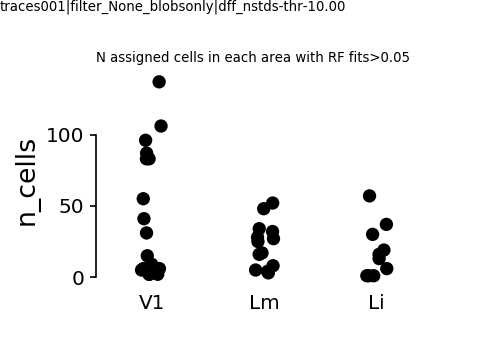

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/by_ncells', 'ncells_assigned_with_rfs_dff-nstds__match-Li-distn')


In [252]:
pass_overlaps = stim_overlaps[stim_overlaps['perc_overlap']>=overlap_thr].copy()
common_counts = aggr.get_counts_by_datakey(pass_overlaps)

f, ax = pl.subplots(dpi=dpi, figsize=(4,3))
sns.stripplot(x='visual_area', y='n_cells', data=common_counts, ax=ax,
             order=visual_areas, color='k', s=8, alpha=1)
sns.despine(bottom=True, trim=True, ax=ax)
ax.tick_params(which='both', axis='x', size=0)
ax.set_xlabel('')
pl.subplots_adjust(left=0.2, bottom=0.2, top=0.8)
ax.set_title("N assigned cells in each area with RF fits>%.2f" % rf_fit_thr, loc='left', fontsize=8)
putils.label_figure(f, data_id)

figname ='ncells_assigned_with_rfs_%s-%s__match-Li-distn' % (response_type, responsive_test)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [753]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

#### Filter out cells that ain't even lookin

In [255]:
remove_too_few = True
min_ncells=5
overlap_thr=0.5

####
globalcells, cell_counts = aggr.get_pooled_cells(stim_overlaps, overlap_thr=overlap_thr, 
                                                     remove_too_few=True, min_ncells=min_ncells)

print("Final cell counts after ROI-assign, RF-fit, and overlap-thr:")
print(globalcells[['visual_area', 'datakey', 'roi']].drop_duplicates()['visual_area'].value_counts())


             cell
visual_area      
Li            178
Lm            296
V1            764
('V1', 764)
('Lm', 296)
('Li', 178)
Final cell counts after ROI-assign, RF-fit, and overlap-thr:
V1    764
Lm    296
Li    178
Name: visual_area, dtype: int64


In [115]:
reload(decutils)

<module 'pipeline.python.classifications.decode_utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/classifications/decode_utils.pyc'>

In [116]:
globalcells, cell_counts = aggr.global_cells(cells,
                                    remove_too_few=True,
                                    min_ncells=5, return_counts=True)

Assigned visual areas: [u'AL' u'Li' u'Ll' u'Lm' u'V1']


In [118]:
gdf = globalcells.copy()
curr_ncells = 16
curr_data = decutils.get_trials_for_N_cells(16, gdf, MEANS)

In [119]:
[s.shape for k, s in SDF.items()]

[(45, 8),
 (45, 8),
 (45, 7),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 7),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 7),
 (45, 8),
 (90, 7),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (25, 7),
 (45, 8),
 (45, 8),
 (45, 7),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 7),
 (45, 7),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 7),
 (45, 8),
 (45, 8),
 (45, 8),
 (45, 8)]

In [108]:
[k for k, s in SDF.items() if s.shape[0]>45]

['20190314_JC070_fov1']

In [105]:
sorted(MEANS[MEANS.keys()[2]]['config'].unique())


['config006',
 'config007',
 'config008',
 'config009',
 'config010',
 'config011',
 'config012',
 'config013',
 'config014',
 'config015',
 'config016',
 'config017',
 'config018',
 'config019',
 'config020',
 'config021',
 'config022',
 'config023',
 'config024',
 'config025',
 'config026',
 'config027',
 'config028',
 'config029',
 'config030',
 'config031',
 'config032',
 'config033',
 'config034',
 'config035',
 'config036',
 'config037',
 'config038',
 'config039',
 'config040',
 'config041',
 'config042',
 'config043',
 'config044',
 'config045',
 'config046',
 'config047',
 'config048',
 'config049',
 'config050']

In [63]:
import random

In [64]:
# Get current global RIDs
ncells_t = gdf.shape[0]
roi_ids = np.array(gdf['roi'].values.copy())

# Random sample w/ replacement
rand_ixs = np.array([random.randint(0, ncells_t-1) for _ in np.arange(0, curr_ncells)])
curr_roi_list = roi_ids[rand_ixs]
curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy()

# Make sure equal num trials per condition for all dsets
min_ntrials_by_config = min([MEANS[k]['config'].value_counts().min() for k in curr_roidf['datakey'].unique()])


In [71]:
# Get data samples for these cells
d_list=[]; c_list=[];
for datakey, dkey_rois in curr_roidf.groupby(['datakey']):
    # Get subset of trials per cond to match min N trials
    tmpd_list=[]
    for cfg, trialmat in MEANS[datakey].groupby(['config']):
        # Get indices of trials in current dataset
        trial_ixs = trialmat.index.tolist()
        # Shuffle them to get random order
        np.random.shuffle(trial_ixs)
        # Select min_ntrials randomly
        curr_cfg_trials = trialmat.loc[trial_ixs[0:min_ntrials_by_config]].copy()
        # Add current trials of current config to list
        tmpd_list.append(curr_cfg_trials)
    tmpd = pd.concat(tmpd_list, axis=0)

    # For each RID sample belonging to current dataset, get RID order
    sampled_cells = pd.concat([dkey_rois[dkey_rois['roi']==globalid][['roi', 'dset_roi']]                                          for globalid in curr_roi_list])
    sampled_dset_rois = sampled_cells['dset_roi'].values
    sampled_global_rois = sampled_cells['roi'].values

    # Get trial responses (some columns are repeats)
    curr_roidata = tmpd[sampled_dset_rois].copy().reset_index(drop=True)
    assert len(sampled_global_rois)==curr_roidata.shape[1], "Incorrect column grabbing"
    curr_roidata.columns = sampled_global_rois # Rename ROI columns to global-rois
    config_list = tmpd['config'].reset_index(drop=True)  # Get configs on selected trials
    print(datakey, len(np.unique(config_list)))
    d_list.append(curr_roidata)
    c_list.append(config_list)
curr_neuraldf = pd.concat(d_list, axis=1).reset_index(drop=True)

('20190306_JC061_fov3', 45)
('20190315_JC070_fov1', 45)
('20190316_JC070_fov1', 45)
('20190327_JC073_fov1', 25)
('20190430_JC078_fov1', 50)
('20190501_JC076_fov1', 50)
('20190504_JC078_fov1', 50)
('20190508_JC083_fov1', 50)
('20190509_JC078_fov1', 50)
('20190512_JC083_fov1', 50)
('20190517_JC083_fov1', 50)
('20190525_JC084_fov1', 50)
('20190603_JC080_fov1', 50)
('20190607_JC091_fov1', 50)
('20190613_JC097_fov1', 50)
('20190614_JC091_fov1', 50)
('20190616_JC097_fov1', 50)
('20190617_JC097_fov1', 50)
('20190622_JC085_fov1', 50)
('20190627_JC091_fov1', 50)
('20191006_JC110_fov1', 50)


In [67]:
cfg_df = pd.concat(c_list, axis=1)
print(cfg_df.shape)

(1250, 21)


In [68]:
cfg_df = cfg_df.T.drop_duplicates().T
print(cfg_df.shape)

(1250, 3)


In [76]:
rename=True
images_only=True
sdf_master = aggr.get_master_sdf(images_only=False)
n_configs = sdf_master.shape[0]

#### Check that all datasets have same stim configs
SDF={}
renamed_configs={}
for datakey in stim_datakeys:
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    if experiment=='blobs':
        obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    elif experiment=='gratings':
        obj = util.Gratings(animalid, session, 'FOV%i_zoom2p0x '% fovnum, traceid=traceid)
    else:
        print("Unvailable experiemnt type for master SDFs: %s" % experiment)
        #return None

    sdf = obj.get_stimuli()
    #if images_only:
    #    sdf = sdf[sdf['morphlevel']!=-1]

    if len(sdf['xpos'].unique())>1 or len(sdf['ypos'].unique())>1:
        print("*Warning* <%s> More than 1 pos? x: %s, y: %s" \
                % (datakey, str(sdf['xpos'].unique()), str(sdf['ypos'].unique())))

    if experiment=='blobs' and (sdf.shape[0]!=sdf_master.shape[0]):
        # Compare key config values and find "matches"
        key_names = ['morphlevel', 'size']
        updated_keys={}
        for old_ix in sdf.index:
            #try:
            new_ix = sdf_master[(sdf_master[key_names] == sdf.loc[old_ix,  key_names]).all(1)].index[0]
            #except Exception as e:
                #print("Not found: %s" % str(sdf.loc[old_ix]))
            #    continue
            updated_keys.update({old_ix: new_ix})

        if rename:
            sdf = sdf.rename(index=updated_keys)

        # Save renamed key
        renamed_configs[datakey] = updated_keys

    if experiment=='blobs' and images_only:
        SDF[datakey] = sdf[sdf['morphlevel']!=-1].copy()
    else:
        SDF[datakey] = sdf

*Warning* <20190314_JC070_fov1> More than 1 pos? x: [-15   0], y: [-5  0]


In [80]:
sdf_master = aggr.get_master_sdf(images_only=True)
n_configs = sdf_master.shape[0]

ignore_params = ['xpos', 'ypos', 'position', 'color']
if experiment != 'blobs':
    ignore_params.extend(['size'])

compare_params = [p for p in sdf_master.columns if p not in ignore_params]
different_configs = renamed_configs.keys()
different_configs

['20190327_JC073_fov1',
 '20190319_JC067_fov1',
 '20190322_JC073_fov1',
 '20190315_JC070_fov1',
 '20190321_JC070_fov1',
 '20190314_JC070_fov1',
 '20190306_JC061_fov3',
 '20190316_JC070_fov1',
 '20190320_JC067_fov1']

In [81]:

assert all([all(sdf_master[compare_params]==d[compare_params]) for k, d in SDF.items() \
          if k not in different_configs]), "Incorrect stimuli..."

In [96]:
input_dfile = os.path.join(curr_src_dir, 'input_dataframes.pkl')
with open(input_dfile, 'rb') as f:
    indata = pkl.load(f)
    
indata.keys()

Index([u'datakey', u'dset_roi', u'roi', u'visual_area', u'animalid',
       u'session', u'fovnum'],
      dtype='object')

In [97]:
indata.groupby(['visual_area', 'datakey']).count()

dset_roi  roi  animalid  session  fovnum
visual_area datakey                                                      
Li          20190602_JC091_fov1        66   66        66       66      66
            20190606_JC091_fov1        22   22        22       22      22
            20190607_JC091_fov1        50   50        50       50      50
            20190609_JC099_fov1        32   32        32       32      32
            20190612_JC099_fov1        22   22        22       22      22
            20190614_JC091_fov1        64   64        64       64      64
Lm          20190430_JC078_fov1        29   29        29       29      29
            20190506_JC080_fov1        23   23        23       23      23
            20190508_JC083_fov1        50   50        50       50      50
            20190512_JC083_fov1        25   25        25       25      25
            20190513_JC078_fov1        11   11        11       11      11
            20190517_JC083_fov1        13   13        13       13      13
            20190525_JC084_fov1        29   29        29       29      29
            20190603_JC080_fov1        39   39        39       39      39
            20190618_JC097_fov1        22   22        22       22      22
            20191008_JC091_fov1        21   21        21       21      21
V1          20190507_JC083_fov1        21   21        21       21      21
            20190508_JC083_fov1         1    1         1        1       1
            20190512_JC083_fov1         2    2         2        2       2
            20190522_JC084_fov1        54   54        54       54      54
            20190613_JC097_fov1        34   34        34       34      34
            20190616_JC097_fov1        49   49        49       49      49
            20190617_JC097_fov1        33   33        33       33      33
            20190622_JC085_fov1        30   30        30       30      30
            20191006_JC110_fov1        30   30        30       30      30

In [98]:
indata.groupby(['visual_area']).count()

datakey  dset_roi  roi  animalid  session  fovnum
visual_area                                                   
Li               256       256  256       256      256     256
Lm               262       262  262       262      262     262
V1               254       254  254       254      254     254

# Check datasets

In [43]:
responsive_test='nstds'
responsive_thr=5
match_distns=False
response_type='dff'
trial_epoch='plushalf'
overlap_thr = 0

curr_visual_area=None
curr_datakey=None

In [40]:
has_rfs = overlap_thr is not None
overlap_str = 'no-rfs' if overlap_thr is None else 'overlap-%.1f' % overlap_thr

In [41]:
_, cells, MEANS = aggr.get_source_data(experiment, 
                    equalize_now=True, zscore_now=True,
                    response_type=response_type, responsive_test=responsive_test, 
                    responsive_thr=responsive_thr, trial_epoch=trial_epoch, use_all=False,
                    visual_area=None if match_distns else curr_visual_area, 
                    datakey=None if match_distns else curr_datakey)
cells = cells[cells['visual_area'].isin(['V1', 'Lm', 'Li'])]
stack_neuraldf = match_distns==True


...loading: /n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-5.00_dff_plushalf.pkl
---equalizing now---
Segmentation, missing:
20190502_JC076_fov1
20191008_JC091_fov1


In [44]:
#### Load RFs
if has_rfs: 
    print("~~~~~~~~~~~~~~~~Loading RFs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    rf_fit_desc = fitrf.get_fit_desc(response_type=response_type)
    reliable_str = 'reliable'
    #rf_str = 'match%s_%s' % (experiment, reliable_str)
    # Get position info for RFs 
    rfdf = aggr.load_rfdf_and_pos(dsets, rf_filter_by=None, 
                                    reliable_only=True, traceid=traceid)
    # RF dataframes
    NEURALDATA, RFDATA = aggr.get_neuraldata_and_rfdata(cells, rfdf, MEANS, 
                                            stack=stack_neuraldf)
else:
    print("~~~~~~~~~~~~~~~~No Receptive Fields~~~~~~~~~~~~~~~~~~~~~~~~~")
    # EXP dataframes 
    NEURALDATA = aggr.get_neuraldata(cells, MEANS, stack=stack_neuraldf)

if match_distns:
    print("~~~~~~~~~~~~~~~~Matching max %s distNs~~~~~~~~~~~~~~~~~~~~~" % response_type)
    NEURALDATA, matched_distn_cells = aggr.match_neuraldata_distn(NEURALDATA, src='Li')
    if has_rfs:
        RFDATA = aggr.select_dataframe_subset(matched_distn_cells, RFDATA)
dist_str = 'matchdist_' if match_distns else ''

if NEURALDATA is None or RFDATA is None:
    print("There is no data. Aborting.")

~~~~~~~~~~~~~~~~Loading RFs~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
N dpaths: 42, N unfit: 0
N datasets included: 42, N sessions excluded: 4


In [47]:
remove_too_few=False
min_ncells=5

if has_rfs:
    print("~~~~~~~~~~~~~~~~Calculating overlaps (thr=%.2f)~~~~~~~~~~~~~" % overlap_thr)
    # Calculate overlap with stimulus
    stim_overlaps = rfutils.calculate_overlaps(RFDATA, experiment=experiment)
    # Filter cells
    globalcells, cell_counts = aggr.get_pooled_cells(stim_overlaps,
                                        remove_too_few=remove_too_few, 
                                        overlap_thr=0 if overlap_thr is None else overlap_thr,
                                        min_ncells=min_ncells)
else:
    if match_distns:
        globalcells, cell_counts = aggr.global_cells(matched_distn_cells,
                                        remove_too_few=remove_too_few, 
                                        min_ncells=min_ncells, return_counts=True)
    else:
        globalcells, cell_counts = aggr.global_cells(cells,
                                        remove_too_few=remove_too_few, 
                                        min_ncells=min_ncells, return_counts=True)

~~~~~~~~~~~~~~~~Calculating overlaps (thr=0.00)~~~~~~~~~~~~~
393 of 393 cells pass overlap (thr=0.00)


# --------------------------------------------------------------------------------------------------------
# Scratch Space
# --------------------------------------------------------------------------------------------------------

# Dataset info

In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Responsive params
responsive_test = 'nstds' # 'nstds' #'ROC' #None
nstd_thr=10
response_type = 'dff'

#### some strings and whatnot
responsive_thr = nstd_thr if responsive_test=='nstds' else 0.05 #0.05 #None
n_stds = None if responsive_test=='ROC' else 2.5 #None
response_str = '%s_resptest-%s_respthr-%.2f' % (response_type, responsive_test, responsive_thr) 

In [5]:
#### Create data ID for labeling figures with data-types
experiment = 'blobs'
print(response_str)

dff_resptest-nstds_respthr-10.00


# Output dir

In [6]:
#### Output dir
stats_dir = os.path.join(aggregate_dir, 'data-stats')

decoding_dir = os.path.join(aggregate_dir, 'decoding')
print(decoding_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding


# Get metadata for experiment type

In [7]:
experiment = 'blobs'

In [8]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)
sdata[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                26
Lm                22
V1                18

# Exclude datasets without RFs

In [9]:
# Get blob metadata only - and only if have RFs
sdata_exp = pd.concat([g for k, g in sdata.groupby(['animalid', 'session', 'fov']) if 
                        (experiment in g['experiment'].values 
                         and ('rfs' in g['experiment'].values or 'rfs10' in g['experiment'].values)) ])
sdata_exp[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                13
Lm                12
V1                11

# Drop duplicates and whatnot fovs

In [10]:
stim_filterby = 'first'

if experiment=='blobs':
    has_gratings=False
    g_str = 'hasgratings' if has_gratings else 'blobsonly'
else:
    g_str = 'gratingsonly'
filter_str = 'stim-filter-%s_%s_%s' % (stim_filterby, g_str, response_str)

In [11]:
# Drop duplicates and whatnot fovs
if experiment=='blobs':
    exp_dkeys = aggr.get_blob_datasets(filter_by=stim_filterby, has_gratings=has_gratings, as_dict=True)
elif experiment == 'gratings':
    exp_dkeys = aggr.get_gratings_datasets(filter_by=stim_filterby, as_dict=True)

for k, v in exp_dkeys.items():
    print('%s: %i datasets' % (k, len(v)))

dictkeys = [d for d in list(itertools.chain(*exp_dkeys.values()))]
stim_datakeys = ['%s_%s_fov%i' % (s.split('_')[0], s.split('_')[1], 
                   sdata[(sdata['animalid']==s.split('_')[1]) & (sdata['session']==s.split('_')[0])]['fovnum'].unique()[0]) for s in dictkeys]
expmeta = dict((k, [dv for dv in stim_datakeys for vv in v if vv in dv]) for k, v in exp_dkeys.items())

V1: 8 datasets
Lm: 8 datasets
Li: 9 datasets


In [12]:
#### Create data ID for labeling figures with data-types
data_id = '|'.join([traceid, filter_str])
print(data_id)


traces001|stim-filter-first_blobsonly_dff_resptest-nstds_respthr-10.00


# Load neural responses

In [13]:
glob.glob(os.path.join(stats_dir, 'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-15.00_dff_stimulus.pkl']

In [14]:
aggr_trialmeans_dfile = glob.glob(os.path.join(stats_dir, 
                                'aggr_%s_trialmeans_*%s*_%s_stimulus.pkl' 
                                               % (experiment, responsive_test, response_type)))[0]

print(aggr_trialmeans_dfile)
with open(aggr_trialmeans_dfile, 'rb') as f:
    MEANS = pkl.load(f)
    

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/aggr_blobs_trialmeans_traces001_nstds-thr-10.00_dff_stimulus.pkl


In [15]:
# aggr_baselines_dfile = glob.glob(os.path.join(stats_dir, 
#                                 'aggr_%s_trialmeans_*%s*_%s_baseline.pkl'
#                                               % (experiment, responsive_test, response_type)))[1]

# print(aggr_baselines_dfile)
# with open(aggr_baselines_dfile, 'rb') as f:
#     BAS = pkl.load(f)

## Check that all datasets have same stim configs

In [16]:
SDF={}
for datakey in stim_datakeys:
    session, animalid, fov_ = datakey.split('_')
    fovnum = int(fov_[3:])
    obj = util.Objects(animalid, session, 'FOV%i_zoom2p0x' %  fovnum, traceid=traceid)
    sdf = obj.get_stimuli()
    SDF[datakey] = sdf

nonpos_params = [p for p in sdf.columns if p not in ['xpos', 'ypos', 'position']] 
assert all([all(sdf[nonpos_params]==d[nonpos_params]) for k, d in SDF.items()]), "Incorrect stimuli..."

Creating blobs object [JC084|20190522|FOV1_zoom2p0x|traces001]
Creating blobs object [JC085|20190622|FOV1_zoom2p0x|traces001]
Creating blobs object [JC097|20190613|FOV1_zoom2p0x|traces001]
Creating blobs object [JC097|20190616|FOV1_zoom2p0x|traces001]
Creating blobs object [JC097|20190617|FOV1_zoom2p0x|traces001]
Creating blobs object [JC110|20191006|FOV1_zoom2p0x|traces001]
Creating blobs object [JC076|20190420|FOV1_zoom2p0x|traces001]
Creating blobs object [JC083|20190507|FOV1_zoom2p0x|traces001]
Creating blobs object [JC084|20190525|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190627|FOV1_zoom2p0x|traces001]
Creating blobs object [JC097|20190618|FOV1_zoom2p0x|traces001]
Creating blobs object [JC083|20190512|FOV1_zoom2p0x|traces001]
Creating blobs object [JC078|20190504|FOV1_zoom2p0x|traces001]
Creating blobs object [JC078|20190430|FOV1_zoom2p0x|traces001]
Creating blobs object [JC080|20190506|FOV1_zoom2p0x|traces001]
Creating blobs object [JC083|20190508|FOV1_zoom2p0x|tra

# Get screen and stimulus info

In [17]:
screeninfo = putils.get_screen_dims() #aggr.get_aggregate_stimulation_info(curr_sdata) #, experiment='blobs')
screenright = float(screeninfo['azimuth_deg']/2)
screenleft = -1*screenright #float(screeninfo['screen_right'].unique())
screentop = float(screeninfo['altitude_deg']/2)
screenbottom = -1*screentop
screenaspect = float(screeninfo['resolution'][0]) / float(screeninfo['resolution'][1])


In [18]:
screeninfo

{'altitude_deg': 67.323,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

# Load RF fits

In [19]:
from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.rois.utils import load_roi_coords
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.pyc'>

In [20]:
reliable_only = True

rf_fit_thr = 0.05
fit_desc = fitrf.get_fit_desc(response_type=response_type)
reliable_str = 'reliable' if reliable_only else ''
rf_str = 'match%s_%s' % (experiment, reliable_str)
print(rf_str)

#### Get non-repeated FOV datasets
rf_dsets = sdata_exp[(sdata_exp['datakey'].isin(stim_datakeys))
                     & (sdata_exp['experiment'].isin(['rfs', 'rfs10']))].copy()
rf_dpaths, no_fits = rfutils.get_fit_dpaths(rf_dsets, traceid=traceid, fit_desc=fit_desc)
print("%i with no fits" % len(no_fits))

rfdf = rfutils.aggregate_rf_data(rf_dpaths, reliable_only=reliable_only, fit_desc=fit_desc,
                                            traceid=traceid, verbose=False)
rfdf = rfdf.reset_index(drop=True)

matchblobs_reliable
N dpaths: 31, N unfit: 0
N datasets included: 31, N sessions excluded: 4
0 with no fits


# Get position info for RFs

In [21]:
aggr_rf_dir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
print(aggr_rf_dir)
rf_filter_by=None

#df_fpath = os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s_%s.pkl' % (rf_filter_by, reliable_str, rfname))
df_fpath =  os.path.join(aggr_rf_dir, 'fits_and_coords_%s_%s.pkl' % (rf_filter_by, reliable_str))
print(df_fpath)

get_positions = False
if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df= pkl.load(f)
        rfdf = df['df']
    except Exception as e:
        get_positions = True
print(get_positions)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/fits_and_coords_None_reliable.pkl
Loading existing RF coord conversions...
False


In [22]:
if get_positions:
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        rfdf[p] = ''
    p_list=[]
    for (animalid, session, fovnum), g in rfdf.groupby(['animalid', 'session', 'fovnum']):
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)

        for ei, e_df in g.groupby(['experiment']):
            cell_ids = e_df['cell'].unique()
            p_ = fcoords['roi_positions'].loc[cell_ids]
            for p in pos_params:
                rfdf[p][e_df.index] = p_[p].values
    # with open(df_fpath, 'wb') as f:
    #     pkl.dump(expdf, f, protocol=pkl.HIGHEST_PROTOCOL)

In [23]:
[r for r in MEANS.keys() if r not in rfdf['datakey'].unique() ]

['20190422_JC076_fov1']

# Select RFs, whichever (rfs/rfs10) in common with blob rids

In [24]:
r_list=[]
for datakey, expdf in MEANS.items(): #corrs.groupby(['datakey']):
    # Get active blob cells
    exp_rids = [r for r in expdf.columns if putils.isnumber(r)] #sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique()))    
    
    # Get current fov's RFs
    rdf = rfdf[rfdf['datakey']==datakey].copy()
    
    # If have both rfs/rfs10, pick the best one
    if len(rdf['experiment'].unique())>1:
        rf_rids = rdf[rdf['experiment']=='rfs']['cell'].unique()
        rf10_rids = rdf[rdf['experiment']=='rfs10']['cell'].unique()
        same_as_rfs = np.intersect1d(rf_rids, exp_rids)
        same_as_rfs10 = np.intersect1d(rf10_rids, exp_rids)
        rfname = 'rfs' if len(same_as_rfs) > len(same_as_rfs10) else 'rfs10'
        print("%s: Selecting %s, overlappig rfs, %i | rfs10, %i (of %i cells)" 
              % (datakey, rfname, len(same_as_rfs), len(same_as_rfs10), len(exp_rids)))
        r_list.append(rdf[rdf['experiment']==rfname])
    else:
        r_list.append(rdf)
RFs = pd.concat(r_list, axis=0)


20190613_JC097_fov1: Selecting rfs10, overlappig rfs, 61 | rfs10, 88 (of 166 cells)
20190622_JC085_fov1: Selecting rfs10, overlappig rfs, 26 | rfs10, 97 (of 203 cells)
20190618_JC097_fov1: Selecting rfs10, overlappig rfs, 13 | rfs10, 24 (of 116 cells)
20190602_JC091_fov1: Selecting rfs10, overlappig rfs, 33 | rfs10, 59 (of 241 cells)
20190616_JC097_fov1: Selecting rfs10, overlappig rfs, 98 | rfs10, 119 (of 296 cells)
20191006_JC110_fov1: Selecting rfs10, overlappig rfs, 46 | rfs10, 72 (of 217 cells)


In [25]:
RFs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                13
Lm                12
V1                11

In [26]:
print("All RFs-----------------------------------")
pp.pprint(rfdf[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())
print("RFs with blobs -----------------------------------")
pp.pprint(RFs[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count())

All RFs-----------------------------------
             datakey
visual_area         
Li                24
Lm                21
V1                16
RFs with blobs -----------------------------------
             datakey
visual_area         
Li                13
Lm                12
V1                11


# Plot

In [27]:
visual_areas = ['V1', 'Lm', 'Li']
fig, axn = pl.subplots(1,3, figsize=(10,6), dpi=dpi)
for visual_area, v_df in RFs.groupby(['visual_area']):
    ai = visual_areas.index(visual_area)
    ax = axn[ai]
    dcolors = sns.color_palette('cubehelix', n_colors=len(v_df['datakey'].unique()))
    for di, (datakey, d_df) in enumerate(v_df.groupby(['datakey'])):
        
        exp_rids = [r for r in MEANS[datakey] if putils.isnumber(r)] #sorted(np.union1d(expdf['row'].unique(), expdf['col'].unique()))    
        rf_rids = d_df['cell'].unique()
        common_to_rfs_and_blobs = np.intersect1d(rf_rids, exp_rids)
        curr_df = d_df[d_df['cell'].isin(common_to_rfs_and_blobs)].copy()
        
        sns.scatterplot('x0', 'y0', data=curr_df, ax=ax, color=dcolors[di],
                        #palette=dcolors, #area_colors[visual_area],
                       s=10, marker='o', alpha=0.5) #, edgecolor='k') #area_colors[visual_area])

        x = curr_df['x0'].values
        y=curr_df['y0'].values
        
        ncells_rfs = len(rf_rids)
        ncells_common = len(common_to_rfs_and_blobs) #curr_df.shape[0]
        m=np.ones(curr_df['x0'].shape)
        cgx = np.sum(x*m)/np.sum(m)
        cgy = np.sum(y*m)/np.sum(m)
        #print('The center of mass: (%.2f, %.2f)' % (cgx, cgy))
        ax.plot(cgx, cgy, marker='+', markersize=20, color=dcolors[di], #area_colors[visual_area],
                label='%s (%s, %i/%i)' % (visual_area, datakey, ncells_common, ncells_rfs), lw=3)
        
    ax.set_title(visual_area)
    ax.legend(bbox_to_anchor=(0.95, -0.4), fontsize=8) #1))

for ax in axn:
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect('equal')
    ax.set_ylabel('')
    ax.set_xlabel('')
    
pl.suptitle("RF positions (+ CoM), responsive cells (%s)" % experiment)
pl.subplots_adjust(top=0.9, bottom=0.4)


putils.label_figure(fig, data_id)
figname = 'CoM_label-fovs_common_to_blobs_and_rfs'
pl.savefig(os.path.join(aggr_rf_dir, '%s.svg' % figname))
print(aggr_rf_dir, figname)

<IPython.core.display.Javascript object>

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff', 'CoM_label-fovs_common_to_blobs_and_rfs')


# Calculate overlap with stimulus

#### Test with example FOV

In [35]:
experiment = 'blobs'

# TEST
animalid = 'JC110'
session = '20191006'
fovnum = 1

datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
print(datakey)
S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

20191006_JC110_fov1
Creating blobs object [JC110|20191006|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (30, 0)
Creating blobs object [JC110|20191006|FOV1_zoom2p0x|traces001]


In [36]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

g = RFs[RFs['datakey']==datakey].copy()

# Convert RF fit params to polygon
g.index = g['cell'].values
rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

# Convert stimuli to polyon bounding boxes
stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
# Concatenate into dataframe
perc_overlap = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})

In [36]:
perc_overlap

area_overlap  stim_size  perc_overlap   cell
0     100.000000         10      1.000000    4.0
0     100.000000         10      1.000000    5.0
0     100.000000         10      1.000000    6.0
0     100.000000         10      1.000000   11.0
0     100.000000         10      1.000000   12.0
0     100.000000         10      1.000000   18.0
0     100.000000         10      1.000000   19.0
0     100.000000         10      1.000000   23.0
0     100.000000         10      1.000000   27.0
0     100.000000         10      1.000000   29.0
0     100.000000         10      1.000000   32.0
0     100.000000         10      1.000000   33.0
0     100.000000         10      1.000000   34.0
0     100.000000         10      1.000000   55.0
0     100.000000         10      1.000000   58.0
0     100.000000         10      1.000000   71.0
0     100.000000         10      1.000000   76.0
0     100.000000         10      1.000000   79.0
0     100.000000         10      1.000000   85.0
0     100.000000         10      1.000000   96.0
0     100.000000         10      1.000000  100.0
0     100.000000         10      1.000000  101.0
0     100.000000         10      1.000000  102.0
0     100.000000         10      1.000000  103.0
0     100.000000         10      1.000000  104.0
0     100.000000         10      1.000000  106.0
0     100.000000         10      1.000000  107.0
0     100.000000         10      1.000000  108.0
0     100.000000         10      1.000000  112.0
0     100.000000         10      1.000000  114.0
..           ...        ...           ...    ...
0    1575.783046         50      0.966142  235.0
0    1126.945148         50      0.987073  237.0
0     466.571962         50      0.725626  252.0
0    2498.176636         50      0.999271  256.0
0    1943.015083         50      0.868830  257.0
0     339.552885         50      0.984153  259.0
0     552.032534         50      1.000000  270.0
0    1519.563960         50      0.630820  273.0
0    1578.624495         50      0.901971  276.0
0    1428.058558         50      0.843141  279.0
0     988.012775         50      1.000000  281.0
0    1449.085403         50      1.000000  284.0
0    1165.905032         50      0.885038  285.0
0     975.626409         50      0.920269  298.0
0     902.774073         50      0.999389  302.0
0    1830.537008         50      0.788669  305.0
0    1712.863656         50      0.910164  310.0
0    1319.458978         50      0.848130  312.0
0    1053.880293         50      1.000000  313.0
0    1656.632134         50      0.967345  320.0
0     301.108655         50      1.000000  328.0
0    1112.311194         50      0.904666  336.0
0    1076.542665         50      0.942927  338.0
0     410.546126         50      0.991599  341.0
0    1760.425091         50      0.704170  347.0
0    1500.485531         50      0.968396  350.0
0    1170.969702         50      0.860209  356.0
0    2016.777382         50      0.806711  364.0
0    1853.100637         50      0.959105  381.0
0    1273.943458         50      0.846169  384.0

[435 rows x 4 columns]

<IPython.core.display.Javascript object>


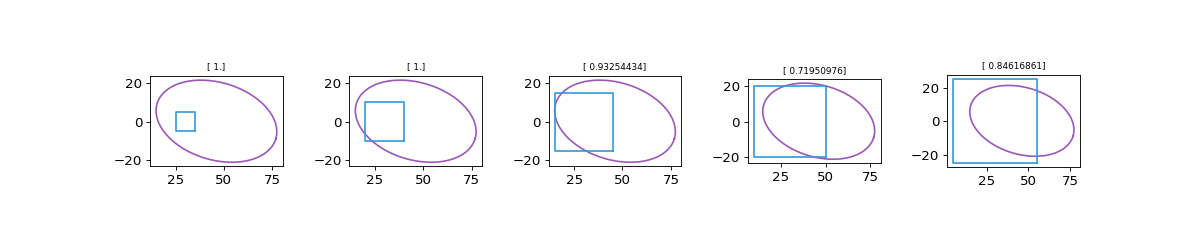

(0, array([ 1.]))
(1, array([ 1.]))
(2, array([ 0.93254434]))
(3, array([ 0.71950976]))
(4, array([ 0.84616861]))


In [69]:
fig, axn = pl.subplots(1,5, figsize=(15,3))

p_rf = rf_polys[0][1]

p_stim = stim_polys[0]
for stim_ix, p_stim in enumerate(stim_polys):
    ax = axn[stim_ix]

    #perc_overlap = rfutils.get_proportion_overlap(rf_polys[0], (stim_ix, p_stim))
    perc_overlap = rfutils.get_proportion_overlap(rf_poly, p_stim) 
    
    #print(perc_overlap)rfutils.get_proportion_overlap(rf_poly, stim_poly)

    x, y = p_rf.exterior.xy
    ax.plot(x, y)
    ax.set_title(perc_overlap['perc_overlap'].values, fontsize=8)
    print(stim_ix, perc_overlap['perc_overlap'].values)

    x, y = p_stim[1].exterior.xy
    ax.plot(x, y)
    ax.set_aspect('equal')
    
pl.subplots_adjust(wspace=0.5)

In [67]:
perc_overlap

area_overlap  col  perc_overlap    row
0   1273.943458   50      0.846169  384.0

### For all RFs measured, calculate overlap with stimuli

In [28]:
rf_fit_params = ['cell', 'std_x', 'std_y', 'theta', 'x0', 'y0']

o_list=[]
for (visual_area, animalid, session, fovnum, datakey), g in RFs.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey']):
#for (visual_area, animalid, session, fovnum, datakey, rfname), g in rfdf.groupby(['visual_area', 'animalid', 'session', 'fovnum', 'datakey', 'experiment']):
   
    if datakey not in MEANS.keys():
        continue
    
    # Convert RF fit params to polygon
    g.index = g['cell'].values
    rf_polys = rfutils.rfs_to_polys(g[rf_fit_params])

    S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
    stim_xpos, stim_ypos = S.get_stimulus_coordinates(experiments=[experiment])
    stim_sizes = S.get_stimulus_sizes(size_tested=[experiment])

    # Convert stimuli to polyon bounding boxes
    stim_polys = [(blob_sz, rfutils.stimsize_poly(blob_sz, xpos=stim_xpos, ypos=stim_ypos)) \
                  for blob_sz in stim_sizes[experiment]]
    
    # Get all pairwise overlaps (% of smaller ellipse that overlaps larger ellipse)
    overlaps = pd.concat([rfutils.get_proportion_overlap(rf_poly, stim_poly) \
                for stim_poly in stim_polys for rf_poly in rf_polys]).rename(columns={'row': 'cell', 'col': 'stim_size'})
    metadict={'visual_area': visual_area, 'animalid': animalid, 'rfname': rfname,
              'session': session, 'fovnum': fovnum, 'datakey': datakey}
    o_ = putils.add_meta_to_df(overlaps, metadict)
    o_list.append(o_)

stim_overlaps = pd.concat(o_list, axis=0).reset_index(drop=True)

Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (-5, 8)
Creating blobs object [JC076|20190502|FOV1_zoom2p0x|traces001]
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (15, 0)
Creating blobs object [JC090|20190605|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190602|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -8)
Creating blobs object [JC091|20190606|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (20, -5)
Creating blobs object [JC091|20190607|FOV1_zoom2p0x|traces001]
Creating blobs object [JC091|20190614|FOV1_zoom2p0x|traces001]
Stimuli presented at coords: (10, -5)
Creating blobs object [JC091|20190614|FOV1_zoom2p0x|traces001]
---> (warning): no

<IPython.core.display.Javascript object>


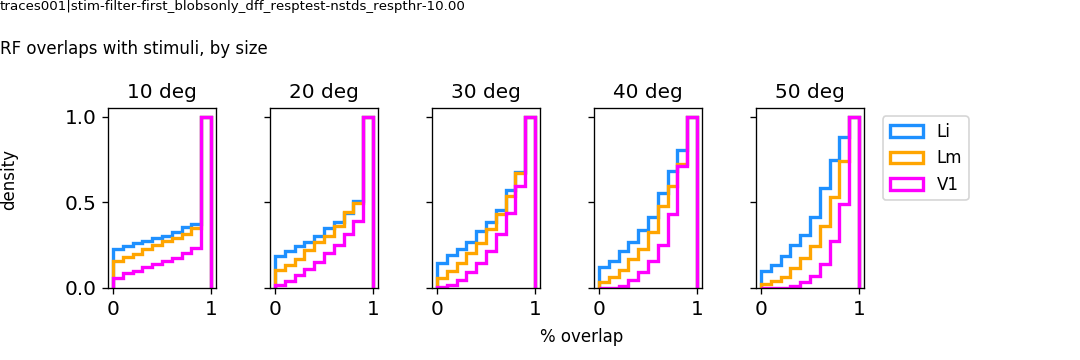

Text(0,0.85,u'RF overlaps with stimuli, by size')

In [71]:
# sns.catplot(x='visual_area', y='perc_overlap', col='stim_size', data=stim_overlaps,
#            kind='kdeplot', palette=area_colors, order=visual_areas)

fig, axn = pl.subplots(1, 5, figsize=(9, 3), sharex=True, sharey=True, dpi=dpi)
for ax, (sz, sg) in zip(axn.flat, stim_overlaps[['perc_overlap', 'visual_area', 'stim_size']].groupby(['stim_size'])):
    for v, vg in sg.groupby(['visual_area']):
        
        ax.hist(vg['perc_overlap'].values, color=area_colors[v], label=v,
                facecolor='none', edgecolor=area_colors[v], lw=2, alpha=1,
                density=True, cumulative=True, histtype='step')
    ax.set_title('%i deg' % (sz))
fig.text(0.5, 0.05, '% overlap')
fig.text(0.0, 0.5, 'density', rotation=90, va='center')

ax.legend(bbox_to_anchor=(1.1, 1))
pl.subplots_adjust(wspace=0.5, top=0.7, right=0.8, bottom=0.2, left=0.1)

putils.label_figure(fig, data_id)
fig.text(0., 0.85, 'RF overlaps with stimuli, by size')

<IPython.core.display.Javascript object>


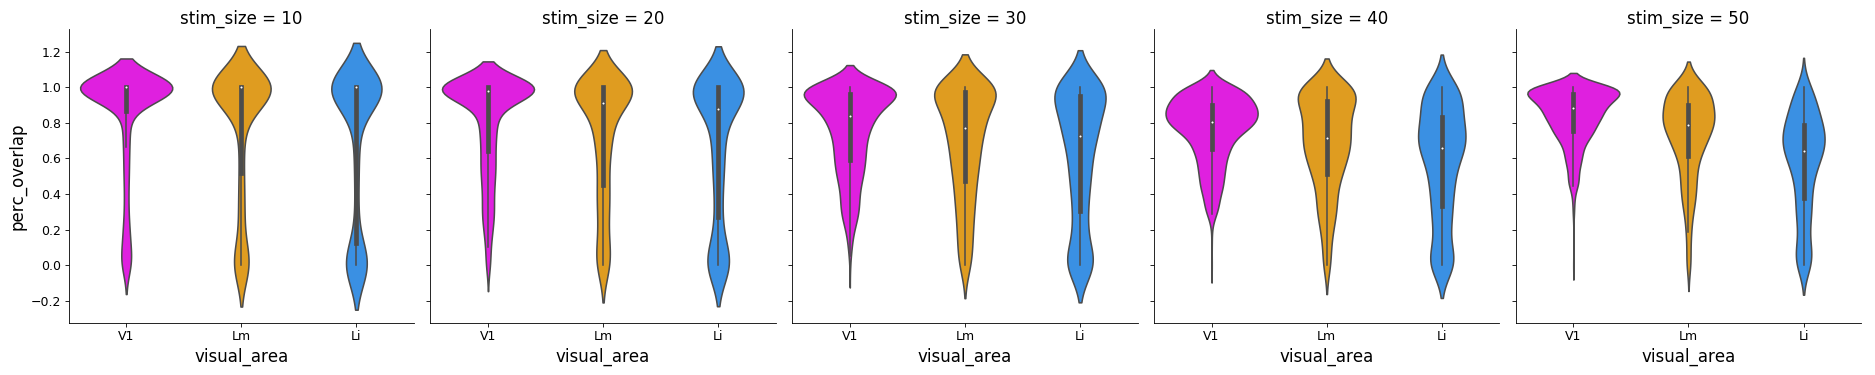

In [39]:
sns.catplot(x='visual_area', y='perc_overlap', col='stim_size', data=stim_overlaps,
           kind='violin', palette=area_colors, order=visual_areas)

# Get data common to RFs + blobs

In [29]:
c_list=[]

i=0
d_list = []
for (visual_area, datakey, rfname), g in stim_overlaps.groupby(['visual_area', 'datakey', 'rfname']):
    if datakey not in MEANS.keys():
        print("no %s: %s" % (experiment, datakey))
        continue
        
    exp_rids = [r for r in MEANS[datakey].columns if putils.isnumber(r)]
    rf_rids = sorted(g['cell'].unique())
    common_rids = np.intersect1d(exp_rids, rf_rids)
    print("[%s] %s, (%s) %i common cells" % (visual_area, datakey, rfname, len(common_rids)))

    c_list.append(pd.DataFrame({'visual_area': visual_area, 'datakey': datakey, 
                                'rfname': rfname, 'n_cells': len(common_rids)}, index=[i]))
    
    d_list.append(g[g['cell'].isin(common_rids)].copy())
    i+=1
    
rfs_and_blobs = pd.concat(d_list, axis=0)
print(rfs_and_blobs.shape)
   
common_counts = pd.concat(c_list, axis=0)
    

[Li] 20190502_JC076_fov1, (rfs10) 15 common cells
[Li] 20190602_JC091_fov1, (rfs10) 59 common cells
[Li] 20190605_JC090_fov1, (rfs10) 9 common cells
[Li] 20190606_JC091_fov1, (rfs10) 26 common cells
[Li] 20190607_JC091_fov1, (rfs10) 41 common cells
[Li] 20190609_JC099_fov1, (rfs10) 22 common cells
[Li] 20190612_JC099_fov1, (rfs10) 21 common cells
[Li] 20190614_JC091_fov1, (rfs10) 52 common cells
[Li] 20190617_JC099_fov1, (rfs10) 4 common cells
[Li] 20191008_JC091_fov1, (rfs10) 20 common cells
[Li] 20191018_JC113_fov1, (rfs10) 6 common cells
[Li] 20191105_JC117_fov1, (rfs10) 0 common cells
[Li] 20191111_JC120_fov1, (rfs10) 1 common cells
[Lm] 20190430_JC078_fov1, (rfs10) 31 common cells
[Lm] 20190504_JC078_fov1, (rfs10) 10 common cells
[Lm] 20190506_JC080_fov1, (rfs10) 30 common cells
[Lm] 20190508_JC083_fov1, (rfs10) 61 common cells
[Lm] 20190509_JC078_fov1, (rfs10) 11 common cells
[Lm] 20190512_JC083_fov1, (rfs10) 39 common cells
[Lm] 20190513_JC078_fov1, (rfs10) 17 common cells
[Lm] 

In [30]:
common_counts.groupby(['visual_area']).count()

datakey  n_cells  rfname
visual_area                          
Li                13       13      13
Lm                12       12      12
V1                11       11      11

In [31]:
rfs_and_blobs[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               276   276
Lm               338   338
V1               736   736

In [37]:
stim_overlaps[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    13
Lm    12
V1    11
Name: visual_area, dtype: int64

In [38]:
RFs[['visual_area', 'datakey']].drop_duplicates()['visual_area'].value_counts()

Li    13
Lm    12
V1    11
Name: visual_area, dtype: int64

In [32]:
overlap_int = 0.2
overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

for overlap_thr in overlap_thr_values:
    pdf = rfs_and_blobs[rfs_and_blobs['perc_overlap']>=overlap_thr].copy()
    print("Thr: %.2f --------------" % overlap_thr)
    print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

Thr: 0.00 --------------
             datakey  cell
visual_area               
Li               276   276
Lm               338   338
V1               736   736
Thr: 0.20 --------------
             datakey  cell
visual_area               
Li               264   264
Lm               337   337
V1               736   736
Thr: 0.40 --------------
             datakey  cell
visual_area               
Li               254   254
Lm               322   322
V1               736   736
Thr: 0.60 --------------
             datakey  cell
visual_area               
Li               248   248
Lm               302   302
V1               736   736
Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               241   241
Lm               272   272
V1               734   734
Thr: 1.00 --------------
             datakey  cell
visual_area               
Li               217   217
Lm               210   210
V1               664   664


# Set output dir

In [34]:
overlap_dir = os.path.join(decoding_dir, 'match_RF_overlap')
if not os.path.exists(overlap_dir):
    os.makedirs(overlap_dir)
print(overlap_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/match_RF_overlap


# Linear separability, by RF overlap

In [33]:
import scipy.stats as spstats
import sklearn.metrics as skmetrics
import random

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

In [35]:
def computeMI(x, y):
    sum_mi = 0.0
    x_value_list = np.unique(x)
    y_value_list = np.unique(y)
    Px = np.array([ len(x[x==xval])/float(len(x)) for xval in x_value_list ]) #P(x)
    Py = np.array([ len(y[y==yval])/float(len(y)) for yval in y_value_list ]) #P(y)
    for i in xrange(len(x_value_list)):
        if Px[i] ==0.:
            continue
        sy = y[x == x_value_list[i]]
        if len(sy)== 0:
            continue
        pxy = np.array([len(sy[sy==yval])/float(len(y))  for yval in y_value_list]) #p(x,y)
        t = pxy[Py>0.]/Py[Py>0.] /Px[i] # log(P(x,y)/( P(x)*P(y))
        sum_mi += sum(pxy[t>0]*np.log2( t[t>0]) ) # sum ( P(x,y)* log(P(x,y)/( P(x)*P(y)) )
    return sum_mi

In [36]:
def filter_rois(rfs_and_blobs, overlap_thr=0.50, return_counts=False):
    visual_areas=['V1', 'Lm', 'Li']
    
    nocells=[]; notrials=[];
    global_rois = dict((v, []) for v in visual_areas)
    roi_counters = dict((v, 0) for v in visual_areas)
    
    roidf = []
    datakeys = dict((v, []) for v in visual_areas)
    for (visual_area, datakey), g in rfs_and_blobs[rfs_and_blobs['perc_overlap']>=overlap_thr].groupby(['visual_area', 'datakey']):

        roi_counter = roi_counters[visual_area]
        datakeys[visual_area].append(datakey)

        roi_list = sorted(g['cell'].unique()) #[int(r) for r in ddf.columns if r != 'config']

        # Reindex roi ids for global
        roi_ids = [i+roi_counter for i, r in enumerate(roi_list)]
        nrs = len(roi_list)

        global_rois[visual_area].extend(roi_ids)
        
        roidf.append(pd.DataFrame({'roi': roi_ids,
                                   'dset_roi': roi_list,
                                   'visual_area': [visual_area for _ in np.arange(0, nrs)],
                                   'datakey': [datakey for _ in np.arange(0, nrs)]}))

        # Update global roi id counter
        roi_counters[visual_area] += len(roi_ids)

    roidf = pd.concat(roidf, axis=0) #.groupby(['visual_area']).count()
    for k, v in global_rois.items():
        print(k, len(v))
    
    if return_counts:
        return roidf, roi_counters
    else:
        return roidf

In [37]:
def get_trials_for_N_cells(curr_ncells, gdf, MEANS):
    '''
    Randomly select N cells from global roi list (gdf), get cell's responses to all trials.
    
    gdf = dataframe (subset of global_rois dataframe), contains 
    - all rois for a given visual area
    - corresponding within-datakey roi IDs
    '''

    # Get current global RIDs
    ncells_t = gdf.shape[0]                      
    roi_ids = np.array(gdf['roi'].values.copy()) 

    # Random sample w/ replacement
    rand_ixs = np.array([random.randint(0, ncells_t-1) for _ in np.arange(0, curr_ncells)])
    curr_roi_list = roi_ids[rand_ixs]
    curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy()

    # Make sure equal num trials per condition for all dsets
    # --- Get fewest total n trials among selected dsets
    #fewest_ntrials_total = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
    # Get fewest N trials in a given cond for the datasets with fewest trials
    #keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials_total]
    min_ntrials_by_config = min([MEANS[k]['config'].value_counts().min() for k in curr_roidf['datakey'].unique()])

    # Get data samples for these cells
    d_list=[]; c_list=[];
    for datakey, dkey_rois in curr_roidf.groupby(['datakey']):
        # Get subset of trials per cond to match min N trials
        tmpd_list=[]
        for cfg, trialmat in MEANS[datakey].groupby(['config']):
            trial_ixs = trialmat.index.tolist() #[0]) # Get indices of trials in current dataset
            np.random.shuffle(trial_ixs)                # Shuffle them to get random order
            curr_cfg_trials = trialmat.loc[trial_ixs[0:min_ntrials_by_config]].copy() # Select min_ntrials randomly
            tmpd_list.append(curr_cfg_trials)        # Add current trials of current config to list
        tmpd = pd.concat(tmpd_list, axis=0) 

        # For each RID sample belonging to current dataset, get RID order
        sampled_cells = pd.concat([dkey_rois[dkey_rois['roi']==globalid][['roi', 'dset_roi']] \
                                         for globalid in curr_roi_list])
        sampled_dset_rois = sampled_cells['dset_roi'].values
        sampled_global_rois = sampled_cells['roi'].values

        # Get trial responses (some columns are repeats)
        curr_roidata = tmpd[sampled_dset_rois].copy().reset_index(drop=True)
        curr_roidata.columns = sampled_global_rois # Rename ROI columns to global-rois
        config_list = tmpd['config'].reset_index(drop=True)  # Get configs on selected trials
        d_list.append(curr_roidata)
        c_list.append(config_list)
    curr_neuraldf = pd.concat(d_list, axis=1).reset_index(drop=True)

    cfg_df = pd.concat(c_list, axis=1)
    cfg_df = cfg_df.T.drop_duplicates().T
    assert cfg_df.shape[0]==curr_neuraldf.shape[0], "Bad trials"
    assert cfg_df.shape[1]==1, "Bad configs"
    df = pd.concat([curr_neuraldf, cfg_df], axis=1)

    return df

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm

def tune_C(sample_data, target_labels, scoring_metric='accuracy', cv_nfolds=5, test_split=0.2, verbose=False):
    
    train_data, test_data, train_labels, test_labels = train_test_split(sample_data, target_labels,
                                                                        test_size=test_split)
    
    #### DATA - Fit classifier
    scaler = StandardScaler()
    scaler.fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)

    # Set the parameters by cross-validation
    tuned_parameters = [{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]

    #scores = ['accuracy', 'precision_macro', 'recall_macro']
    scoring = ('accuracy') #, 'precision_macro', 'recall_macro')
    # scoring_metric = 'accuracy' 
    results ={}
    #for scorer in scoring:
    scorer = scoring_metric
    
    if verbose:
        print("# Tuning hyper-parameters for %s" % scorer)
    #print()
    clf = GridSearchCV(
        svm.SVC(kernel='linear'), tuned_parameters, scoring=scorer, cv=cv_nfolds #scoring='%s_macro' % score
    )
    clf.fit(train_data, train_labels)
    if verbose:
        print("Best parameters set found on development set:")
        print(clf.best_params_)
    if verbose:
        print("Grid scores on development set (scoring=%s):" % scoring_metric)
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))

    y_true, y_pred = test_labels, clf.predict(test_data)
    if verbose:
        print("Detailed classification report:")
        print("The model is trained on the full development set.")
        print("The scores are computed on the full evaluation set.")
        print(classification_report(y_true, y_pred))
    test_score = clf.score(test_data, test_labels)
    if verbose:
        print("Held out test score: %.2f" % test_score)
    results.update({'%s' % scorer: {'C': clf.best_params_['C'], 'test_score': test_score}})
    return results #clf.best_params_



In [39]:
def fit_svm(zdata, targets, test_split=0.2, cv_nfolds=5, verbose=False, cv=True, C_value=None):

    # sizes = sorted(targets['group'].unique())

    #### For each transformation, split trials into 80% and 20%
    train_data, test_data, train_labels, test_labels = train_test_split(zdata, targets['label'].values, 
                                                        test_size=test_split, stratify=targets['group'])
    #print("CV:", cv)
    #### Cross validate (tune C w/ train data)
    if cv:
        cv_results = tune_C(train_data, train_labels, scoring_metric='accuracy', cv_nfolds=cv_nfolds, 
                           test_split=test_split, verbose=verbose)
        C_value = cv_results['accuracy']['C']
    else:
        assert C_value is not None, "Provide value for hyperparam C..."

    #### Fit SVM
    scaler = StandardScaler().fit(train_data)
    train_data = scaler.transform(train_data)
    trained_svc = svm.SVC(kernel='linear', C=C_value, random_state=10)
    scores = cross_validate(trained_svc, train_data, train_labels, cv=5,
                            scoring=('precision_macro', 'recall_macro', 'accuracy'),
                            return_train_score=True)
    iterdict = dict((s, values.mean()) for s, values in scores.items())
    trained_svc = svm.SVC(kernel='linear', C=C_value, random_state=10).fit(train_data, train_labels)
        
    #### DATA - Test with held-out data
    test_data = scaler.transform(test_data)
    test_score = trained_svc.score(test_data, test_labels)

    #### DATA - Calculate MI
    predicted_labels = trained_svc.predict(test_data)
    mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
    ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
    log2_mi = computeMI(test_labels, predicted_labels)
    iterdict.update({'heldout_test_score': test_score, 
                     'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi,
                     'C': C_value})
    # ------------------------------------------------------------------
    # Shuffle LABELS to calculate chance level
    train_labels_chance = train_labels.copy()
    np.random.shuffle(train_labels_chance)
    test_labels_chance = test_labels.copy()
    np.random.shuffle(test_labels_chance)

    #### CHANCE - Fit classifier
    chance_svc = svm.SVC(kernel='linear', C=C_value, random_state=10)
    scores_chance = cross_validate(chance_svc, train_data, train_labels_chance, cv=5,
                            scoring=('precision_macro', 'recall_macro', 'accuracy'),
                            return_train_score=True)
    iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

    # CHANCE - Test with held-out data
    trained_svc_chance = chance_svc.fit(train_data, train_labels_chance)
    test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  

    # Chance - Calculate MI
    predicted_labels = trained_svc_chance.predict(test_data)
    mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
    ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
    log2_mi = computeMI(test_labels, predicted_labels)

    iterdict_chance.update({'heldout_test_score': test_score_chance, 
                            'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})

    return iterdict, iterdict_chance


In [40]:
def do_fit(iter_num, global_rois=None, MEANS=None, sdf=None, sample_ncells=None,
           C_value=None, test_size=0.2, cv_nfolds=5, class_a=0, class_b=106):
    #[gdf, MEANS, sdf, sample_ncells, cv] * n_times)
    '''
    Resample w/ replacement from pooled cells (across datasets). Assumes 'sdf' is same for all datasets.
    Do n_iterations, return mean/sem/std over iterations as dict of results.
    Classes (class_a, class_b) should be the actual labels of the target (i.e., value of morph level)
    '''
    #iter_list=[]
    #chance_list=[]
    #for iteration in np.arange(0, n_iterations): #n_iterations):
    
    # Get new sample set
    curr_data = get_trials_for_N_cells(sample_ncells, global_rois, MEANS)

    #### Select train/test configs for clf A vs B
    object_configs = sdf[sdf['morphlevel'].isin([class_a, class_b])].index.tolist() 
    curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
    sample_data = curr_data[curr_data['config'].isin(object_configs)]

    #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
    zdata = sample_data.drop('config', 1) #sample_data[curr_roi_list].copy()
    #zdata = (data - data.mean()) / data.std()

    #### Get labels
    targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
    targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
    targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

    #### Fit
    curr_iter, _ = fit_svm(zdata, targets, cv=cv, C_value=C_value,
                                          test_split=test_split, cv_nfolds=cv_nfolds)

    return pd.DataFrame(curr_iter, index=[iter_num])


In [41]:
import multiprocessing as mp
from functools import partial
from contextlib import contextmanager

@contextmanager
def poolcontext(*args, **kwargs):
    pool = multiprocessing.Pool(*args, **kwargs)
    yield pool
    pool.terminate()
    pool.join()

def initializer(terminating_):
    # This places terminating in the global namespace of the worker subprocesses.
    # This allows the worker function to access `terminating` even though it is
    # not passed as an argument to the function.
    global terminating
    terminating = terminating_

def pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, n_iterations=50, n_processes=1):   
    #try:
    results = []# None
    terminating = mp.Event()

    pool = mp.Pool(initializer=initializer, initargs=(terminating, ), processes=n_processes)  
    try:
        print("... n: %i (%i procs)" % (sample_ncells, n_processes))
        func = partial(do_fit, global_rois=global_rois, MEANS=MEANS, sdf=sdf, sample_ncells=sample_ncells)
        results = pool.map_async(func, range(n_iterations)).get(99999999)
        pool.close()
        pool.join()
    except KeyboardInterrupt:
        print("**interupt")
        pool.terminate()
        print("***Terminating!")
    finally:
        pool.close()
        pool.join()

    return results

In [42]:
import datetime


## Run for 1 overlap_thr, 1 iter, select M0 / M100

In [43]:
min_ncells = 20

overlap_thr=0.8
not_in_stimkeys =[]
too_few = []
for (visual_area, datakey), g in rfs_and_blobs[rfs_and_blobs['perc_overlap']>=overlap_thr].groupby(['visual_area', 'datakey']):
    if len(g['cell'].unique()) < min_ncells:
        print(datakey, len(g['cell'].unique()))
        too_few.append(datakey)
    if datakey not in stim_datakeys:
        not_in_stimkeys.append(datakey)


('20190502_JC076_fov1', 14)
('20190605_JC090_fov1', 8)
('20190612_JC099_fov1', 18)
('20190617_JC099_fov1', 1)
('20191008_JC091_fov1', 12)
('20191018_JC113_fov1', 5)
('20191111_JC120_fov1', 1)
('20190504_JC078_fov1', 8)
('20190509_JC078_fov1', 6)
('20190513_JC078_fov1', 9)
('20190517_JC083_fov1', 15)
('20190627_JC091_fov1', 5)
('20190501_JC076_fov1', 11)


In [74]:
rfs_and_blobs[rfs_and_blobs['perc_overlap']<0.5]['visual_area'].value_counts()


Lm    304
Li    166
V1     86
Name: visual_area, dtype: int64

In [59]:
overlap_thr=0.5
filter_fovs = True
remove_too_few = False

filter_str = 'filter-repeat-fovs' if filter_fovs else 'all-fovs'
filter_str = '%s_%s' % (filter_str, 'remove-few') if remove_too_few else filter_str
print(filter_str)
if filter_fovs:
    curr_dkeys = [s for s in stim_datakeys if s not in too_few] if remove_too_few else stim_datakeys
else:
    curr_dkeys = rfs_and_blobs['datakey'].unique()
print(len(stim_datakeys), len(curr_dkeys))

globalcells_df, cell_counts = filter_rois(rfs_and_blobs[rfs_and_blobs['datakey'].isin(curr_dkeys)], 
                                overlap_thr=overlap_thr, return_counts=True)

filter-repeat-fovs
(25, 25)
('V1', 652)
('Lm', 222)
('Li', 133)


In [62]:
m0=0
m100=106
n_iterations=500
print(m0, m100, '%i iters' % n_iterations)

# CV stuff
test_split=0.2
cv_nfolds=5
C_value=None
cv=True

# Set overlap amount
overlap_thr_int = 0.2
overlap_thr_values = np.arange(0, 1+overlap_thr_int, overlap_thr_int)

# Make sure have SAME N trials total
keys_with_min_reps = [k for k, v in MEANS.items() if v['config'].value_counts().min() < 29]
print(globalcells_df[~globalcells_df['datakey'].isin(keys_with_min_reps)]['visual_area'].value_counts())
filt_globaldf = globalcells_df[~globalcells_df['datakey'].isin(keys_with_min_reps)]

(0, 106, '500 iters')
V1    652
Lm    222
Li    116
Name: visual_area, dtype: int64


In [63]:
if overlap_thr==0:
    NCELLS = [2, 4, 8, 16, 32, 64, 82, 123, 186, 237, 448, 556, 652]
else:
    #NCELLS = [2, 4, 8, 16, 32, 64, 82, 112, 164, 201, 448, 556, 652]
    NCELLS = [2, 4, 8, 16, 32, 64, 116, 222, 448, 652]

print("NCELLS: %s" % (str(NCELLS)))
ncells_dict = dict((k, NCELLS) for k in overlap_thr_values)

NCELLS: [2, 4, 8, 16, 32, 64, 116, 222, 448, 652]


In [64]:
n_processes = 2

popdf = []
#popdf_chance = []

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)
i=0
for visual_area, global_rois in filt_globaldf.groupby(['visual_area']):
#gdf = filt_globaldf[filt_globaldf['visual_area']==visual_area].copy()

    for sample_ncells in NCELLS: #[0::2]:
        print("... [%s] popn size: %i" % (visual_area, sample_ncells))
        if sample_ncells > cell_counts[visual_area]:
            continue
            
        iter_list = pool_bootstrap(global_rois, MEANS, sdf, sample_ncells, 
                                   n_iterations=n_iterations, n_processes=n_processes)

        # DATA - get mean across iters
        iter_results = pd.concat(iter_list, axis=0)
        iterd = dict(iter_results.mean())
        iterd.update( dict(('%s_std' % k, v) for k, v in \
                              zip(iter_results.std().index, iter_results.std().values)) )
        iterd.update( dict(('%s_sem' % k, v) for k, v in \
                              zip(iter_results.sem().index, iter_results.sem().values)) )
        iterd.update({'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area})

        popdf.append(pd.DataFrame(iterd, index=[i]))
        #popdf_chance.append(pd.DataFrame(iterd_chance, index=[i]))
        i += 1

pooled = pd.concat(popdf, axis=0)
#pooled_chance = pd.concat(popdf_chance, axis=0)
#print(pooled.shape, pooled_chance.shape)
pooled.head()

-------- Overlap: 0.50 --------
... [Li] popn size: 2
... n: 2 (2 procs)
... [Li] popn size: 4
... n: 4 (2 procs)
... [Li] popn size: 8
... n: 8 (2 procs)
... [Li] popn size: 16
... n: 16 (2 procs)
... [Li] popn size: 32
... n: 32 (2 procs)
... [Li] popn size: 64
... n: 64 (2 procs)
... [Li] popn size: 116
... n: 116 (2 procs)
... [Li] popn size: 222
... [Li] popn size: 448
... [Li] popn size: 652
... [Lm] popn size: 2
... n: 2 (2 procs)
... [Lm] popn size: 4
... n: 4 (2 procs)
... [Lm] popn size: 8
... n: 8 (2 procs)
... [Lm] popn size: 16
... n: 16 (2 procs)
... [Lm] popn size: 32
... n: 32 (2 procs)
... [Lm] popn size: 64
... n: 64 (2 procs)
... [Lm] popn size: 116
... n: 116 (2 procs)
... [Lm] popn size: 222
... n: 222 (2 procs)
... [Lm] popn size: 448
... [Lm] popn size: 652
... [V1] popn size: 2
... n: 2 (2 procs)
... [V1] popn size: 4
... n: 4 (2 procs)
... [V1] popn size: 8
... n: 8 (2 procs)
... [V1] popn size: 16
... n: 16 (2 procs)
... [V1] popn size: 32
... n: 32 (2 procs)


C     C_sem       C_std  fit_time  fit_time_sem  fit_time_std  \
0  16.466518  4.912238  109.840989  0.001940      0.000319      0.007133   
1   5.625676  2.099634   46.949248  0.001985      0.000322      0.007207   
2  24.597820  6.281696  140.462999  0.018267      0.004671      0.104447   
3  13.289500  4.057835   90.735949  0.033715      0.010351      0.231457   
4   4.381840  0.834053   18.650000  0.036454      0.007123      0.159265   

   heldout_MI  heldout_MI_sem  heldout_MI_std  heldout_aMI     ...       \
0    0.020176        0.001416        0.031656     0.020125     ...        
1    0.029979        0.001636        0.036574     0.032393     ...        
2    0.045250        0.001871        0.041827     0.053698     ...        
3    0.070528        0.002355        0.052669     0.090584     ...        
4    0.097976        0.002536        0.056717     0.130923     ...        

   train_accuracy  train_accuracy_sem  train_accuracy_std  \
0        0.574810            0.002409            0.053858   
1        0.616642            0.002619            0.058554   
2        0.667348            0.002243            0.050150   
3        0.726310            0.001736            0.038821   
4        0.789517            0.001445            0.032316   

   train_precision_macro  train_precision_macro_sem  \
0               0.513423                   0.006869   
1               0.595115                   0.005569   
2               0.666940                   0.003277   
3               0.730132                   0.001664   
4               0.791695                   0.001395   

   train_precision_macro_std  train_recall_macro  train_recall_macro_sem  \
0                   0.153603            0.569504                0.002572   
1                   0.124519            0.613698                0.002725   
2                   0.073280            0.665613                0.002308   
3                   0.037201            0.725335                0.001769   
4                   0.031200            0.788943                0.001459   

   train_recall_macro_std  visual_area  
0                0.057515           Li  
1                0.060939           Li  
2                0.051608           Li  
3                0.039546           Li  
4                0.032631           Li  

[5 rows x 42 columns]

In [52]:
datestr = datetime.datetime.now().strftime("%Y%m%d")
train_str = 'traintest_by-ncells_iter-%i' % (n_iterations)

pooled_outfile = os.path.join(decoding_dir, '%s_overlap-%.2f_results_%s.pkl' % (train_str, overlap_thr, datestr))
params_outfile = os.path.join(decoding_dir, '%s_overlap-%.2f_params_%s.json' % (train_str, overlap_thr, datestr))

with open(pooled_outfile, 'wb') as f:
    pkl.dump({'pooled': pooled}, f, protocol=pkl.HIGHEST_PROTOCOL)
    
params = {'test_split':0.2, 'cv_nfolds':5, 'C_value':None, 'cv':True,
          'n_iterations': n_iterations, 'overlap_thr': overlap_thr}
with open(params_outfile, 'w') as f:
    json.dump(params, f,  indent=4, sort_keys=True)
    
print(pooled_outfile)
print(params_outfile)


/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/traintest_by-ncells_iter-500_overlap-0.80_results_20200926.pkl
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/traintest_by-ncells_iter-500_overlap-0.80_params_20200926.json


<IPython.core.display.Javascript object>


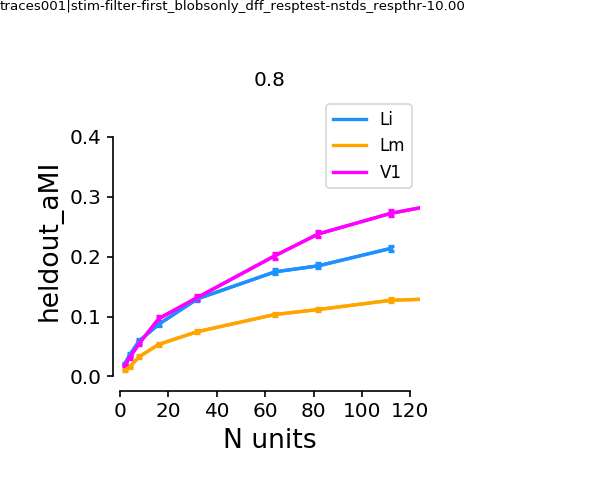

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', 'traintest_by-ncells_iter-500__heldout_aMIzoom_overlap-thr=0.80_filter-repeat-fovs')


<IPython.core.display.Javascript object>


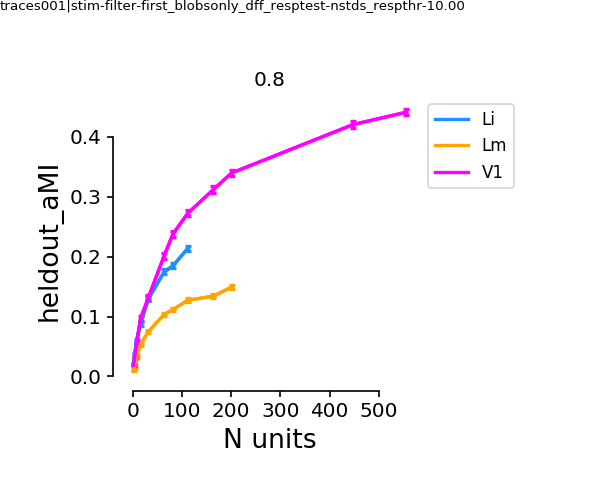

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', 'traintest_by-ncells_iter-500__heldout_aMI_overlap-thr=0.80_filter-repeat-fovs')


<IPython.core.display.Javascript object>


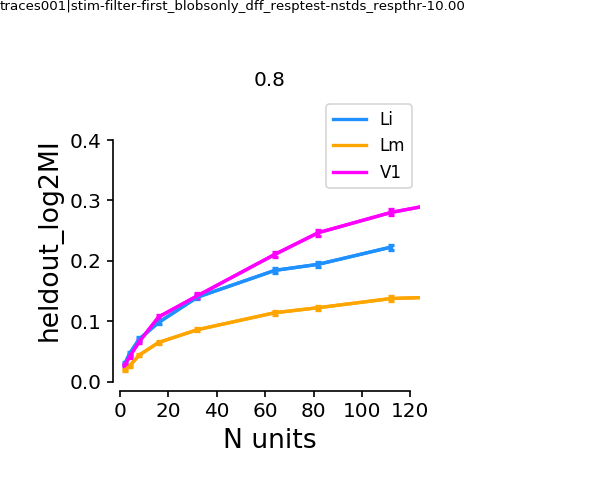

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', 'traintest_by-ncells_iter-500__heldout_log2MIzoom_overlap-thr=0.80_filter-repeat-fovs')


<IPython.core.display.Javascript object>


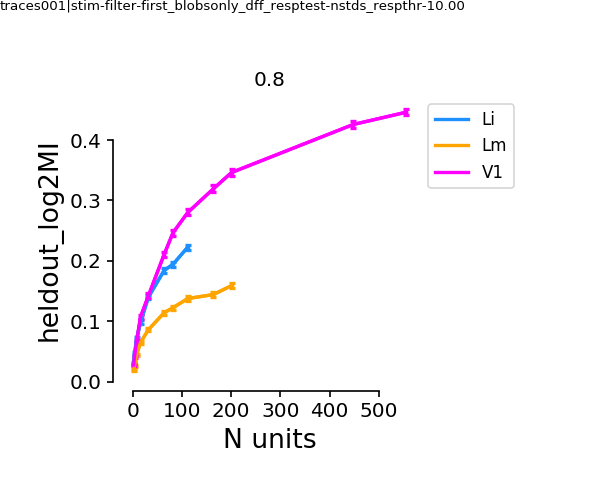

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', 'traintest_by-ncells_iter-500__heldout_log2MI_overlap-thr=0.80_filter-repeat-fovs')


<IPython.core.display.Javascript object>


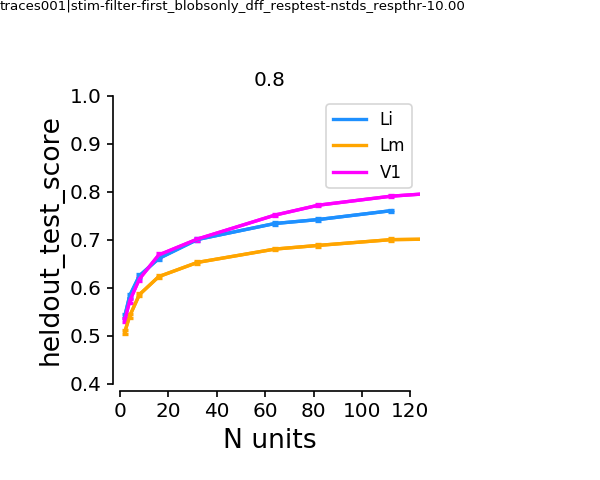

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', 'traintest_by-ncells_iter-500__heldout_test_scorezoom_overlap-thr=0.80_filter-repeat-fovs')


<IPython.core.display.Javascript object>


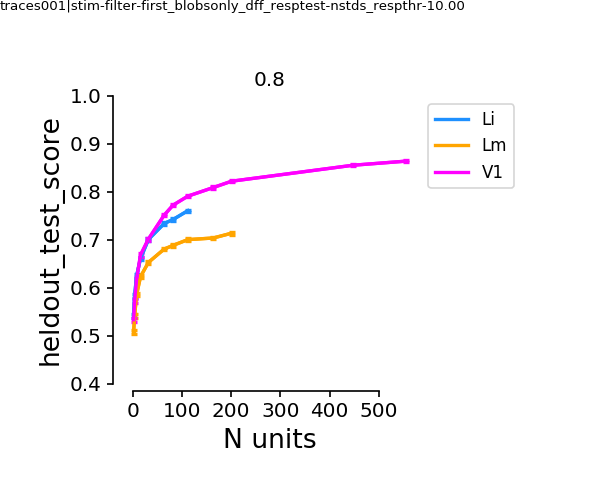

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', 'traintest_by-ncells_iter-500__heldout_test_score_overlap-thr=0.80_filter-repeat-fovs')


In [50]:
#zoom=True

lw=2
capsize=2
#metric='heldout_aMI' #'heldout_test_score'

for metric in ['heldout_aMI', 'heldout_log2MI', 'heldout_test_score']:
    for zoom in [True,False]:
        fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
        for ai, (visual_area, g) in enumerate(pooled.groupby(['visual_area'])):
            mean_scores = g.sort_values(by='n_units')[metric]
            std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
            n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
            ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                    alpha=1, lw=lw,
                    label='%s' % (visual_area))
            ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                        capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                        lw=lw)
        ax.legend(bbox_to_anchor=(1., 1))
        ax.set_title(overlap_thr)
        ax.set_xlabel("N units")
        ax.set_ylabel(metric)

        if metric=='heldout_test_score':
            ax.set_ylim([0.4, 1.0])
        ax.set_ylabel(metric)

        zoom_str=''
        if zoom:
            ax.set_xlim([0, 124])
            zoom_str = 'zoom'

        sns.despine(trim=True, offset=4)
        pl.subplots_adjust(right=0.7, left=0.2, wspace=0.5, bottom=0.2, top=0.8)


        putils.label_figure(fig, data_id)
        figname = '%s__%s%s_overlap-thr=%.2f_%s' % (train_str, metric, zoom_str, overlap_thr, filter_str)
        pl.savefig(os.path.join(decoding_dir, '%s_%s.svg' % (figname, datestr)))
        print(decoding_dir, figname)

In [313]:
popdf = []
popdf_chance = []
i = 0

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)

# Get list of eligible cells from all FOVs
for visual_area, gdf in filt_globaldf.groupby(['visual_area']):
    for sample_ncells in NCELLS: #[0::2]:
        print("... [%s] popn size: %i" % (visual_area, sample_ncells))
        if sample_ncells > cell_counts[visual_area]:
            continue
        iterd, iterd_chance = resample_data_fit_classifier(gdf, MEANS, sdf, sample_ncells=sample_ncells,
                                                           C_value=C_value, test_size=test_split, cv_nfolds=cv_nfolds,
                                                           class_a=m0, class_b=m100, 
                                                           n_iterations=n_iterations)

        iterd.update({'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area})
        iterd_chance.update({'n_units': sample_ncells, 'overlap': overlap_thr, 'visual_area': visual_area})

        popdf.append(pd.DataFrame(iterd, index=[i]))
        popdf_chance.append(pd.DataFrame(iterd_chance, index=[i]))
        i += 1

pooled = pd.concat(popdf, axis=0)
pooled_chance = pd.concat(popdf_chance, axis=0)
print(pooled.shape, pooled_chance.shape)
pooled.head()

-------- Overlap: 0.80 --------
... [Li] popn size: 2
... [Li] popn size: 4
... [Li] popn size: 8
... [Li] popn size: 16
... [Li] popn size: 32
... [Li] popn size: 64
... [Li] popn size: 82
... [Li] popn size: 102
... [Li] popn size: 148
... [Li] popn size: 186
... [Li] popn size: 256
... [Li] popn size: 448
... [Li] popn size: 610
... [Lm] popn size: 2
... [Lm] popn size: 4
... [Lm] popn size: 8
... [Lm] popn size: 16
... [Lm] popn size: 32
... [Lm] popn size: 64
... [Lm] popn size: 82
... [Lm] popn size: 102
... [Lm] popn size: 148
... [Lm] popn size: 186
... [Lm] popn size: 256
... [Lm] popn size: 448
... [Lm] popn size: 610
... [V1] popn size: 2
... [V1] popn size: 4
... [V1] popn size: 8
... [V1] popn size: 16
... [V1] popn size: 32
... [V1] popn size: 64
... [V1] popn size: 82
... [V1] popn size: 102
... [V1] popn size: 148
... [V1] popn size: 186
... [V1] popn size: 256
... [V1] popn size: 448
... [V1] popn size: 610
((31, 39), (31, 39))


fit_time  fit_time_sem  fit_time_std  heldout_MI  heldout_MI_sem  \
0  0.008256      0.000025      0.000253    0.012733        0.002021   
1  0.008552      0.000023      0.000232    0.014421        0.002290   
2  0.009405      0.000057      0.000572    0.021756        0.002912   
3  0.013747      0.000111      0.001111    0.027711        0.003500   
4  0.018535      0.000415      0.004150    0.051287        0.004501   

   heldout_MI_std  heldout_aMI  heldout_aMI_sem  heldout_aMI_std  \
0        0.020214     0.007258         0.002872         0.028724   
1        0.022896     0.008191         0.003396         0.033956   
2        0.029115     0.018923         0.004302         0.043019   
3        0.035002     0.027662         0.005147         0.051475   
4        0.045012     0.062212         0.006605         0.066045   

   heldout_log2MI     ...       train_accuracy  train_accuracy_sem  \
0        0.018370     ...             0.523601            0.003444   
1        0.020805     ...             0.535539            0.003376   
2        0.031387     ...             0.573207            0.004190   
3        0.039978     ...             0.614939            0.004112   
4        0.073991     ...             0.700284            0.003792   

   train_accuracy_std  train_neg_mean_squared_error  \
0            0.034440                  -5352.823309   
1            0.033759                  -5218.680408   
2            0.041899                  -4795.443025   
3            0.041118                  -4326.542887   
4            0.037924                  -3367.606197   

   train_neg_mean_squared_error_sem  train_neg_mean_squared_error_std  \
0                         38.696644                        386.966438   
1                         37.931839                        379.318387   
2                         47.077679                        470.776792   
3                         46.199963                        461.999625   
4                         42.611536                        426.115361   

   train_r2  train_r2_sem  train_r2_std  visual_area  
0 -0.907139      0.013803      0.138028           Li  
1 -0.859211      0.013499      0.134990           Li  
2 -0.708283      0.016729      0.167287           Li  
3 -0.541617      0.016478      0.164778           Li  
4 -0.199629      0.015184      0.151839           Li  

[5 rows x 39 columns]

<IPython.core.display.Javascript object>


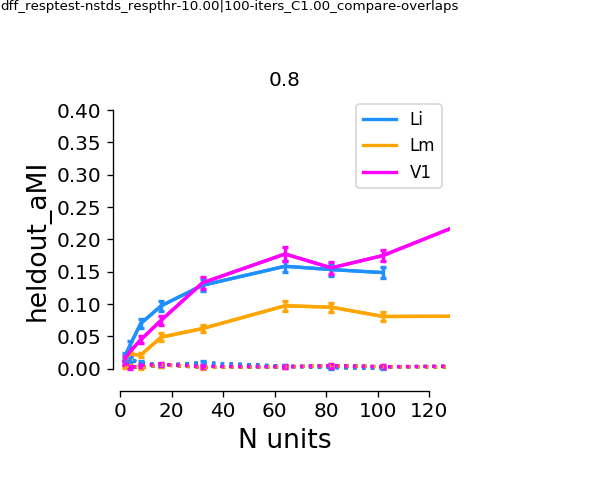

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_zoom_heldout_aMI_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


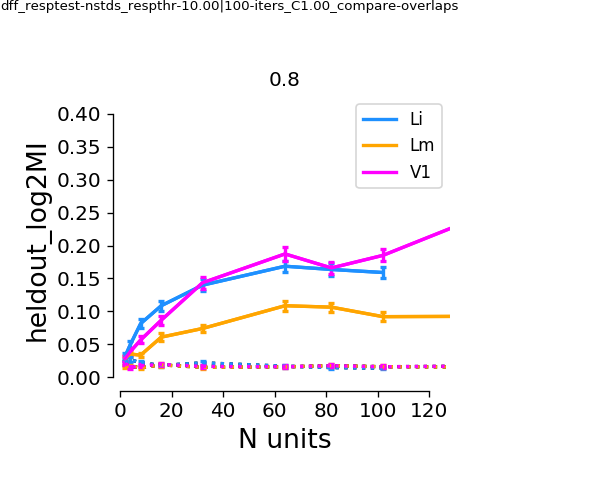

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_zoom_heldout_log2MI_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


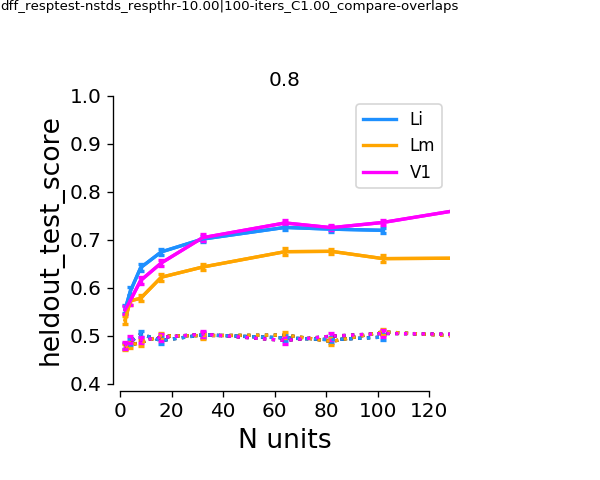

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_zoom_heldout_test_score_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


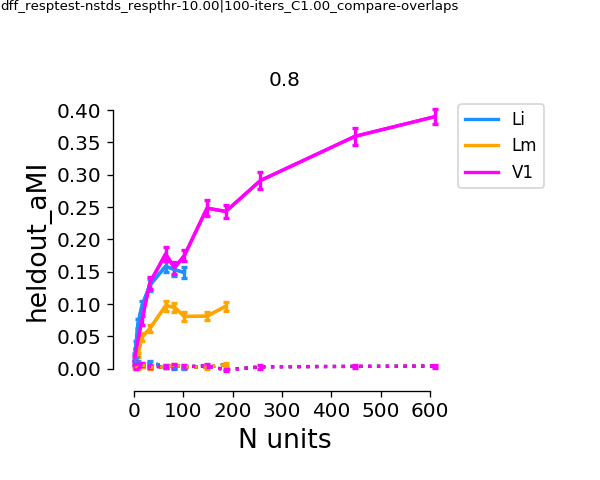

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_heldout_aMI_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


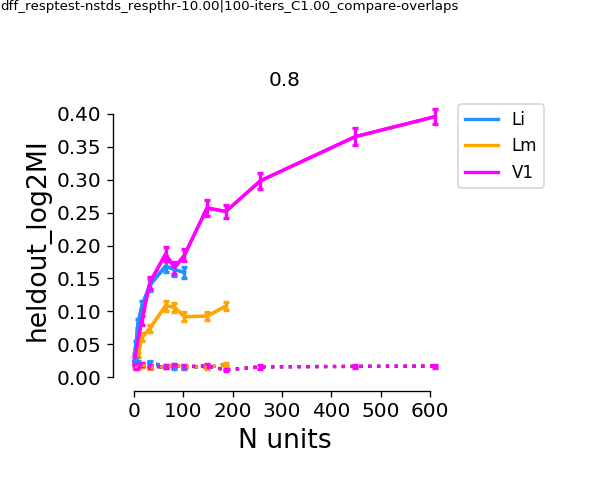

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_heldout_log2MI_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


<IPython.core.display.Javascript object>


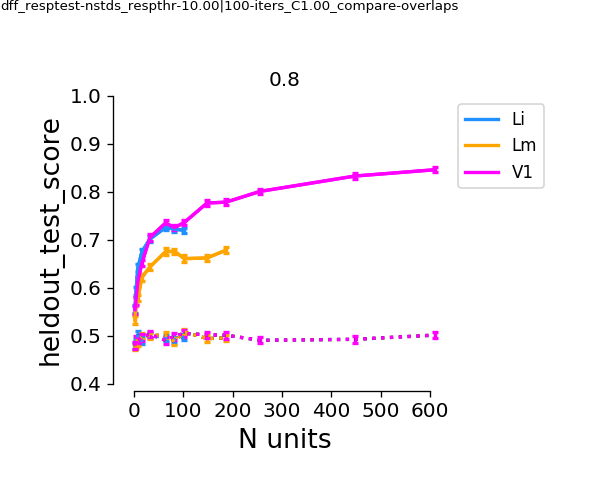

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', '_sameNtrials_filter-repeat-fovs_heldout_test_score_overlap0.80_0vs106_split-test-0.20_5-fold-cv_C1.00_niter100__dff_resptest-nstds_respthr-10.00')


In [289]:
#zoom=True

#metric = 'heldout_test_score' #'heldout_aMI' #'heldout_test_score'
overlap_thr=0.8

res_df = pooled.copy() #pooled[pooled['overlap_thr']==overlap_thr].copy()
chance_df = pooled_chance.copy() #[pooled_chance['overlap_thr']==overlap_thr].copy()

lw = 2
capsize=2

for zoom in [True, False]:
    for metric in ['heldout_aMI', 'heldout_log2MI', 'heldout_test_score']:
        metric_base = metric #'heldout_test' if metric=='heldout_test_score' else metric
        
        fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
        for ai, (visual_area, g) in enumerate(res_df.groupby(['visual_area'])):
            mean_scores = g.sort_values(by='n_units')[metric]
            std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
            n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
            ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                    alpha=1, lw=lw,
                    label='%s' % (visual_area))
            ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                        capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                        lw=lw)
        ax.legend(bbox_to_anchor=(1., 1))
        ax.set_title(overlap_thr)
        ax.set_xlabel("N units")
        ax.set_ylabel(metric)

        for ai, (visual_area, g) in enumerate(chance_df.groupby(['visual_area'])):
            mean_scores = g.sort_values(by='n_units')[metric]
            std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
            n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
            ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                    alpha=1, lw=lw, linestyle=':', 
                    label=None)
            ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                        capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                        lw=lw, linestyle=':')
        if metric=='heldout_test_score':
            ax.set_ylim([0.4, 1.0])
        ax.set_ylabel(metric)

        if zoom:
            ax.set_xlim([0, 128])
            zoom_str = 'zoom_'
        else:
            zoom_str=''

        sns.despine(trim=True, offset=4)
        pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

        analysis_str = '%s|%i-iters_C%.2f_compare-overlaps' % (response_str, n_iterations, C_value)

        putils.label_figure(fig, analysis_str)

        figname = '_sameNtrials_%s_%s%s_overlap%.2f_%ivs%i_split-test-%.2f_%i-fold-cv_C%.2f_niter%i__%s' % (filter_str, zoom_str, metric, overlap_thr, m0, m100, test_split, cv_nfolds, C_value, n_iterations, response_str)
        pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))

        print(decoding_dir, figname)

In [ ]:
response_str

In [233]:
screeninfo

{'altitude_deg': 67.323,
 'azimuth_deg': 119.5564,
 'deg_per_pixel': (0.06226895833333333, 0.062336111111111106),
 'resolution': [1920, 1080]}

# Cycle thru all visual areas

In [174]:
overlap_thr=0.8
    
popdf = []
popdf_chance = []
i = 0

#for overlap_thr, NCELLS in ncells_dict.items():
print("-------- Overlap: %.2f --------" % overlap_thr)

# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 
#globaldf = filter_rois(has_blobs, overlap_thr=overlap_thr) 


for curr_ncells in [20, 40, 80, 100]: #NCELLS:
    for visual_area, gdf in globaldf.groupby(['visual_area']):
        print("... [%s] popn size: %i" % (visual_area, curr_ncells))

        iter_results=[]
        iter_results_chance=[]
        for iteration in np.arange(0, n_iterations): #n_iterations):
            
            curr_data = get_trials_for_N_cells(curr_ncells, gdf, MEANS)

            #### Select train/test configs for clf A vs B
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
            sample_data = curr_data[curr_data['config'].isin(object_configs)]

            #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
            data = sample_data[curr_roi_list]
            zdata = (data - data.mean()) / data.std()

            #### Get labels
            targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
            targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
            targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]
            
            #### Fit
            curr_iter, curr_iter_chance = fit_svm(zdata, targets, C_value=1.0, test_split=0.2)
            iter_results.append(pd.DataFrame(curr_iter, index=[iteration]))
            iter_results_chance.append(pd.DataFrame(curr_iter_chance, index=[iteration]))

        # DATA - get mean across iters
        iter_results = pd.concat(iter_results, axis=0)
        iterdict = dict(iter_results.mean())
        iterdict.update( dict(('%s_std' % k, v) for k, v in \
                              zip(iter_results.std().index, iter_results.std().values)) )
        iterdict.update( dict(('%s_sem' % k, v) for k, v in \
                              zip(iter_results.sem().index, iter_results.sem().values)) )
        iterdict.update({'n_units': curr_ncells, 
                         'overlap': overlap_thr,
                         'visual_area': visual_area})
        popdf.append(pd.DataFrame(iterdict, index=[i]))

        # CHANCE - get mean across iters
        iter_results_chance = pd.concat(iter_results_chance, axis=0)
        iterdict_chance = dict(iter_results_chance.mean())
        iterdict_chance.update( dict(('%s_std' % k, v) for k, v in \
                              zip(iter_results_chance.std().index, iter_results_chance.std().values)) )
        iterdict_chance.update( dict(('%s_sem' % k, v) for k, v in \
                              zip(iter_results_chance.sem().index, iter_results_chance.sem().values)) )
        iterdict_chance.update({'n_units': curr_ncells, 
                                'overlap': overlap_thr,
                                'visual_area': visual_area})
        popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
        i += 1

pooled = pd.concat(popdf, axis=0)
pooled_chance = pd.concat(popdf_chance, axis=0)
print(pooled.shape, pooled_chance.shape)
pooled.head()

-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)
{'V1': 572, 'Lm': 185, 'Li': 100}
... [Li] popn size: 20
... [Lm] popn size: 20
... [V1] popn size: 20
... [Li] popn size: 40
... [Lm] popn size: 40
... [V1] popn size: 40
... [Li] popn size: 80
... [Lm] popn size: 80
... [V1] popn size: 80
... [Li] popn size: 100
... [Lm] popn size: 100
... [V1] popn size: 100
((12, 39), (12, 39))


fit_time  fit_time_sem  fit_time_std  heldout_MI  heldout_MI_sem  \
0  0.012825      0.000153      0.001526    0.084204        0.005645   
1  0.014310      0.000103      0.001032    0.049176        0.004341   
2  0.013875      0.000096      0.000958    0.067498        0.004451   
3  0.013824      0.000180      0.001803    0.106442        0.005841   
4  0.017510      0.000138      0.001375    0.064833        0.004603   

   heldout_MI_std  heldout_aMI  heldout_aMI_sem  heldout_aMI_std  \
0        0.056454     0.110287         0.008290         0.082901   
1        0.043415     0.059080         0.006362         0.063624   
2        0.044508     0.086056         0.006525         0.065246   
3        0.058411     0.142634         0.008603         0.086033   
4        0.046032     0.082140         0.006764         0.067636   

   heldout_log2MI     ...       train_accuracy  train_accuracy_sem  \
0        0.121481     ...             0.753935            0.003685   
1        0.070946     ...             0.715883            0.003049   
2        0.097379     ...             0.746677            0.003333   
3        0.153563     ...             0.827296            0.002714   
4        0.093534     ...             0.794026            0.002396   

   train_accuracy_std  train_neg_mean_squared_error  \
0            0.036850                  -2764.786598   
1            0.030495                  -3192.343603   
2            0.033330                  -2846.336993   
3            0.027140                  -1940.501668   
4            0.023961                  -2314.326118   

   train_neg_mean_squared_error_sem  train_neg_mean_squared_error_std  \
0                         41.404411                        414.044107   
1                         34.263902                        342.639019   
2                         37.449029                        374.490286   
3                         30.494494                        304.944938   
4                         26.922625                        269.226252   

   train_r2  train_r2_sem  train_r2_std  visual_area  
0  0.014907      0.014734      0.147337           Li  
1 -0.137280      0.012193      0.121926           Lm  
2 -0.014178      0.013338      0.133383           V1  
3  0.308511      0.010876      0.108759           Li  
4  0.175310      0.009589      0.095894           Lm  

[5 rows x 39 columns]

In [162]:
pooled_outfile = os.path.join(decoding_dir, 'results_overlap-%.2f.pkl' % overlap_thr)
with open(pooled_outfile, 'wb') as f:
    pkl.dump(pooled, f, protocol=pkl.HIGHEST_PROTOCOL)
    
chance_outfile = os.path.join(decoding_dir, 'shuffled_overlap-%.2f.pkl' % overlap_thr)
with open(chance_outfile, 'wb') as f:
    pkl.dump(pooled_chance, f, protocol=pkl.HIGHEST_PROTOCOL)
    

In [172]:
pooled.columns

Index([u'fit_time', u'fit_time_sem', u'fit_time_std', u'heldout_MI',
       u'heldout_MI_sem', u'heldout_MI_std', u'heldout_aMI',
       u'heldout_aMI_sem', u'heldout_aMI_std', u'heldout_log2MI',
       u'heldout_log2MI_sem', u'heldout_log2MI_std', u'heldout_test_score',
       u'heldout_test_score_sem', u'heldout_test_score_std', u'n_units',
       u'overlap', u'score_time', u'score_time_sem', u'score_time_std',
       u'test_accuracy', u'test_accuracy_sem', u'test_accuracy_std',
       u'test_neg_mean_squared_error', u'test_neg_mean_squared_error_sem',
       u'test_neg_mean_squared_error_std', u'test_r2', u'test_r2_sem',
       u'test_r2_std', u'train_accuracy', u'train_accuracy_sem',
       u'train_accuracy_std', u'train_neg_mean_squared_error',
       u'train_neg_mean_squared_error_sem',
       u'train_neg_mean_squared_error_std', u'train_r2', u'train_r2_sem',
       u'train_r2_std', u'visual_area'],
      dtype='object')

<IPython.core.display.Javascript object>


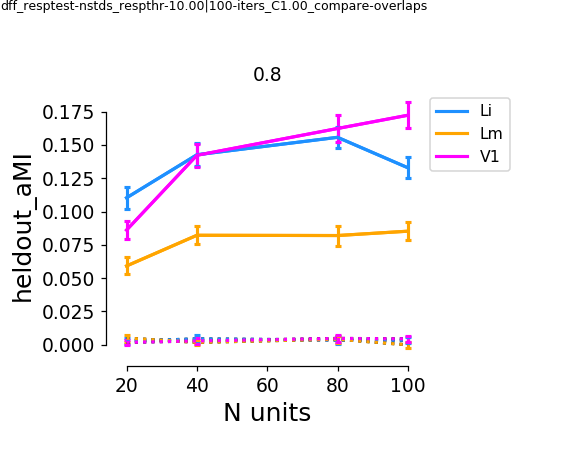

('/n/coxfs01/julianarhee/aggregate-visual-areas/decoding', 'CoM_label-fovs_common_to_blobs_and_rfs')


In [175]:
#metric = 'heldout_test_score' #'heldout_aMI' #'heldout_test_score'
metric = 'heldout_aMI' #'heldout_aMI' #'heldout_test_score'

metric_base = metric #'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
for ai, (visual_area, g) in enumerate(pooled.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
            alpha=1, lw=lw,
            label='%s' % (visual_area))
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(overlap_thr)
ax.set_xlabel("N units")
ax.set_ylabel(metric)


for ai, (visual_area, g) in enumerate(pooled_chance.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
            alpha=1, lw=lw, linestyle=':', 
            label=None)
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw, linestyle=':')
if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1.0])
ax.set_ylabel(metric)


sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%s|%i-iters_C%.2f_compare-overlaps' % (response_str, n_iterations, C_value)

putils.label_figure(fig, analysis_str)
   
#figname = '%s_%ivs%i_split-test-%.2f_%i-fold-cv_overlap%.2f_C%.2f_niter%i__%s' % (metric, m0, m100, test_split, cv_nfolds, overlap_thr, C_value, n_iterations, response_str)
#pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))

print(decoding_dir, figname)


# Get all overlaps, all iters

In [85]:
NCELLS

[4, 8, 16, 32, 64, 128, 168]

In [86]:
overlap_int=0.2
overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)
overlap_thr_values

array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ])

In [87]:
ncells_dict = dict((k, NCELLS) for k in overlap_thr_values)
ncells_dict

{0.0: [4, 8, 16, 32, 64, 128, 168],
 0.20000000000000001: [4, 8, 16, 32, 64, 128, 168],
 0.40000000000000002: [4, 8, 16, 32, 64, 128, 168],
 0.60000000000000009: [4, 8, 16, 32, 64, 128, 168],
 0.80000000000000004: [4, 8, 16, 32, 64, 128, 168],
 1.0: [4, 8, 16, 32, 64, 128, 168]}

In [88]:
n_iterations

100

In [89]:
#if load_popdata:
    
popdf = []
popdf_chance = []
i = 0
for overlap_thr, NCELLS in ncells_dict.items():
    print("-------- Overlap: %.2f --------" % overlap_thr)
    # Get list of eligible cells from all FOVs
    globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 


    for curr_ncells in NCELLS:
        for visual_area, gdf in globaldf.groupby(['visual_area']):
            print("... [%s] popn size: %i" % (visual_area, curr_ncells))

            iter_results=[]
            iter_results_chance=[]
            for iteration in np.arange(0, n_iterations): #n_iterations):

                curr_data = get_trials_for_N_cells(curr_ncells, gdf, MEANS)

                #### Select train/test configs for clf A vs B
                object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
                curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
                sample_data = curr_data[curr_data['config'].isin(object_configs)]

                #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
                data = sample_data[curr_roi_list]
                zdata = (data - data.mean()) / data.std()

                #### Get labels
                targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
                targets['label'] = [sdf['morphlevel'][cfg] for cfg in targets['config'].values]
                targets['group'] = [sdf['size'][cfg] for cfg in targets['config'].values]

                #### Fit
                curr_iter, curr_iter_chance = fit_svm(zdata, targets, C_value=1.0, test_split=0.2)
                iter_results.append(pd.DataFrame(curr_iter, index=[iteration]))
                iter_results_chance.append(pd.DataFrame(curr_iter_chance, index=[iteration]))

            # DATA - get mean across iters
            iter_results = pd.concat(iter_results, axis=0)
            iterdict = dict(iter_results.mean())
            iterdict.update( dict(('%s_std' % k, v) for k, v in \
                                  zip(iter_results.std().index, iter_results.std().values)) )
            iterdict.update( dict(('%s_sem' % k, v) for k, v in \
                                  zip(iter_results.sem().index, iter_results.sem().values)) )
            iterdict.update({'n_units': curr_ncells, 
                             'overlap': overlap_thr,
                             'visual_area': visual_area})
            popdf.append(pd.DataFrame(iterdict, index=[i]))

            # CHANCE - get mean across iters
            iter_results_chance = pd.concat(iter_results_chance, axis=0)
            iterdict_chance = dict(iter_results_chance.mean())
            iterdict_chance.update( dict(('%s_std' % k, v) for k, v in \
                                  zip(iter_results_chance.std().index, iter_results_chance.std().values)) )
            iterdict_chance.update( dict(('%s_sem' % k, v) for k, v in \
                                  zip(iter_results_chance.sem().index, iter_results_chance.sem().values)) )
            iterdict_chance.update({'n_units': curr_ncells, 
                                    'overlap': overlap_thr,
                                    'visual_area': visual_area})
            popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
            i += 1

pooled = pd.concat(popdf, axis=0)
pooled_chance = pd.concat(popdf_chance, axis=0)
print(pooled.shape, pooled_chance.shape)
pooled.head()

-------- Overlap: 0.00 --------
('V1', 652)
('Lm', 237)
('Li', 142)
{'V1': 652, 'Lm': 237, 'Li': 142}
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 64
... [Lm] popn size: 64
... [V1] popn size: 64
... [Li] popn size: 128
... [Lm] popn size: 128
... [V1] popn size: 128
... [Li] popn size: 168
... [Lm] popn size: 168
... [V1] popn size: 168
-------- Overlap: 1.00 --------
('V1', 473)
('Lm', 155)
('Li', 89)
{'V1': 473, 'Lm': 155, 'Li': 89}
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 64
... [Lm] popn size: 64

fit_time  fit_time_sem  fit_time_std  heldout_MI  heldout_MI_sem  \
0  0.004631      0.000146      0.001462    0.033441        0.003553   
1  0.006269      0.000151      0.001513    0.021921        0.003462   
2  0.005198      0.000147      0.001474    0.028299        0.003141   
3  0.006957      0.000170      0.001704    0.052132        0.004871   
4  0.008349      0.000101      0.001010    0.033749        0.003508   

   heldout_MI_std  heldout_aMI  heldout_aMI_sem  heldout_aMI_std  \
0        0.035533     0.034441         0.005263         0.052634   
1        0.034620     0.019172         0.005073         0.050735   
2        0.031408     0.028716         0.004608         0.046081   
3        0.048708     0.062061         0.007204         0.072043   
4        0.035082     0.036490         0.005140         0.051398   

   heldout_log2MI     ...       train_accuracy  train_accuracy_sem  \
0        0.048245     ...             0.616248            0.005384   
1        0.031625     ...             0.605438            0.004147   
2        0.040827     ...             0.614874            0.003806   
3        0.075210     ...             0.667021            0.004869   
4        0.048690     ...             0.634245            0.003304   

   train_accuracy_std  train_neg_mean_squared_error  \
0            0.053843                  -4311.836682   
1            0.041474                  -4433.302853   
2            0.038059                  -4327.276421   
3            0.048688                  -3741.347000   
4            0.033044                  -4109.621918   

   train_neg_mean_squared_error_sem  train_neg_mean_squared_error_std  \
0                         60.497972                        604.979716   
1                         46.600598                        466.005979   
2                         42.762860                        427.628604   
3                         54.706396                        547.063964   
4                         37.128067                        371.280670   

   train_r2  train_r2_sem  train_r2_std  visual_area  
0 -0.536624      0.021543      0.215431           Li  
1 -0.579652      0.016599      0.165995           Lm  
2 -0.542153      0.015284      0.152842           V1  
3 -0.333138      0.019471      0.194715           Li  
4 -0.464166      0.013217      0.132167           Lm  

[5 rows x 39 columns]

In [90]:
pooled_decoding_results = os.path.join(decoding_dir, 'pooled_%i-iter_%iv%i_stratified-folds_perc_overlap__%s.pkl' % (n_iterations, m0, m100, response_str))

with open(pooled_decoding_results, 'wb') as f:
    pkl.dump({'pooled': pooled, 'pooled_chance': pooled_chance}, f, protocol=pkl.HIGHEST_PROTOCOL)
print("Saved results:\n--->%s" % pooled_decoding_results)

Saved results:
--->/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/pooled_100-iter_0v106_stratified-folds_perc_overlap__dff_resptest-nstds_respthr-10.00.pkl


## split by v area

<IPython.core.display.Javascript object>


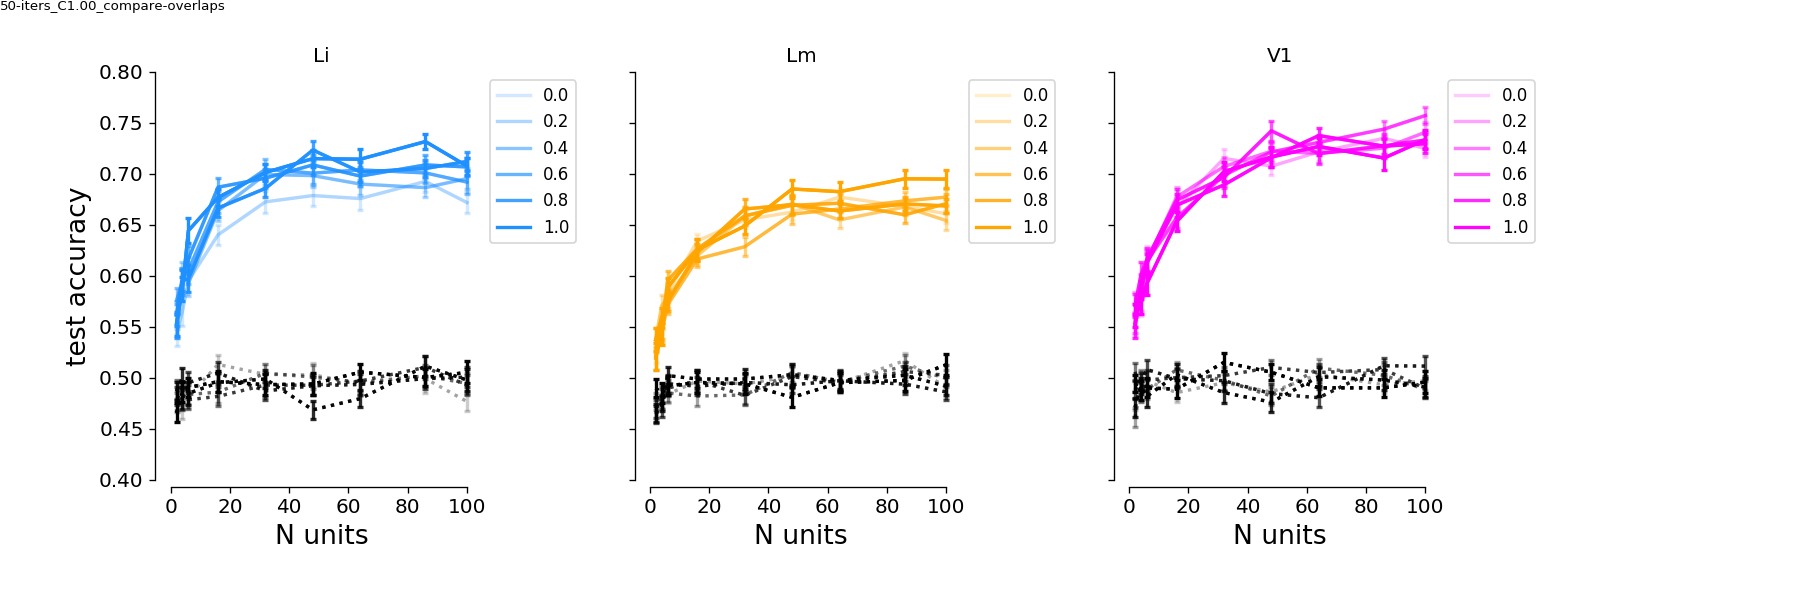

heldout_test_score_compare-overlaps_split-visual-area_C1.00_niter50__dff_resptest-nstds_respthr-0.05


In [1121]:
metric = 'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))

fig, axes = pl.subplots(1, 3, figsize=(15,5), sharex=True, sharey=True, dpi=dpi)
ai = 0
for visual_area, pgroup in pooled.groupby(['visual_area']):
    ax = axes[ai]
    for overlap_l, g in pgroup.groupby(['overlap']):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%.1f' % (overlap_l))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=overlap_alphas[overlap_l], 
                    lw=lw)
    if ai==0:
        ax.set_ylabel("test accuracy")
    
    ax.legend(bbox_to_anchor=(1.0, 1))
    ax.set_title(visual_area)
    ai += 1
    ax.set_xlabel("N units")

ai=0
for visual_area, pgroup in pooled_chance.groupby(['visual_area']):
    ax = axes[ai]
    for overlap_l, g in pgroup.groupby(['overlap']):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
                label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color='k', #area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
        
    ai += 1
    
ax.set_ylim([0.4, 0.8])
sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.8, left=0.09, wspace=0.5, bottom=0.2)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str) 

figname = '%s_compare-overlaps_split-visual-area_C%.2f_niter%i__%s' % (metric, C_value, n_iterations, response_str)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))

print(figname)

## Plot visual areas together, split by overlap_thr

<IPython.core.display.Javascript object>


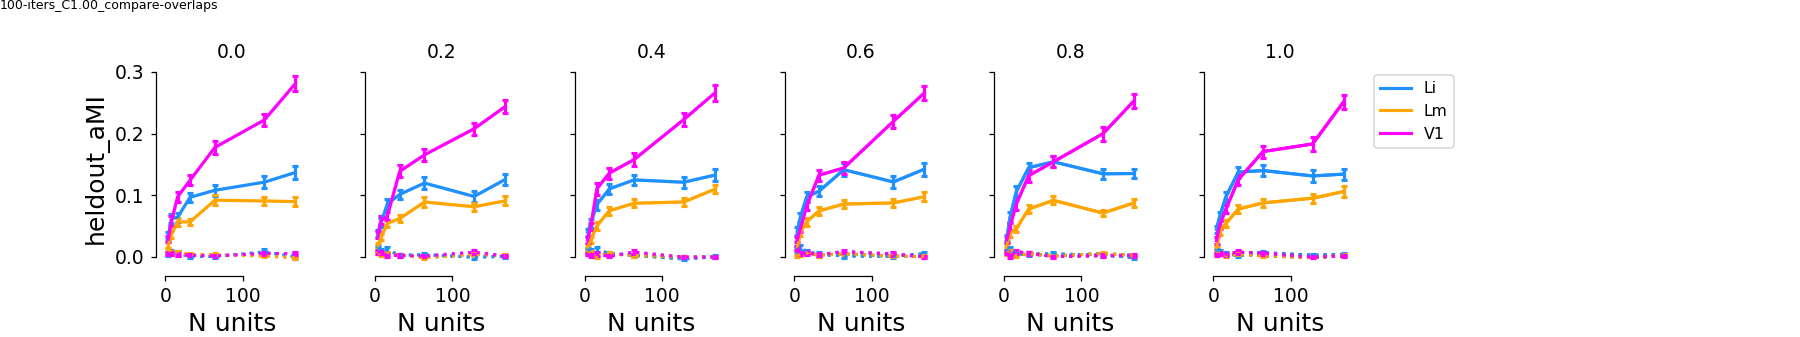

heldout_aMI_perc_overlap_statified-folds_C1.00_niter100__dff_resptest-nstds_respthr-10.00


In [91]:
metric = 'heldout_aMI' #'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))


fig, axn = pl.subplots(1, 6, figsize=(16,3), sharex=True, sharey=True, dpi=dpi)
for ci, (overlap_l, pgroup) in enumerate(pooled.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%s' % (visual_area))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw)
    ax.set_ylabel('')
    if ci==5:
        ax.legend(bbox_to_anchor=(1.8, 1))
    ax.set_title(overlap_l)
    ax.set_xlabel("N units")
    ax.set_ylabel('classifier accuracy')

for ci, (overlap_l, pgroup) in enumerate(pooled_chance.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
                label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
    if metric=='heldout_test_score':
        ax.set_ylim([0.4, 1.0])
    if ci==0:
        ax.set_ylabel(metric)
    else:
        ax.set_ylabel('')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.09, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   

figname = '%s_perc_overlap_statified-folds_C%.2f_niter%i__%s' % (metric, C_value, n_iterations, response_str)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
#pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

print(figname)

In [1002]:
os.path.join(decoding_dir, 'pooled_%i-iter_%iv%i_stratified-folds_perc_overlap__%s.pkl' % (n_iterations, m0, m100, response_str))


'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/linear-separability'

In [92]:
NCELLS


[4, 8, 16, 32, 64, 128, 168]

<IPython.core.display.Javascript object>


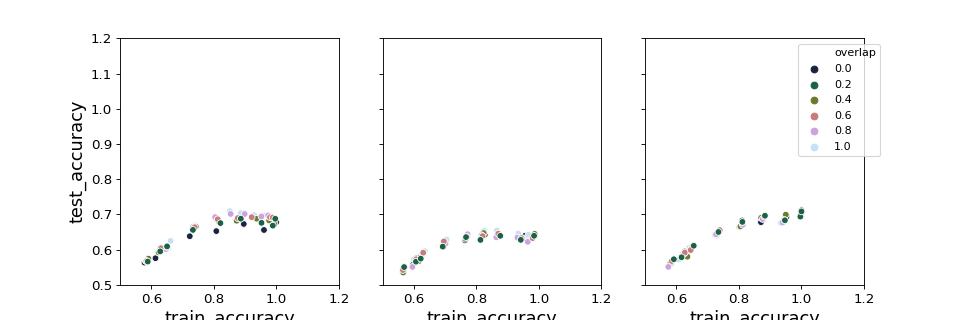

In [1126]:
overlap_palette = sns.color_palette('cubehelix', n_colors=len(overlap_thr_values))

fig, axn = pl.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)

for ai, (ax, (visual_area, g)) in enumerate(zip(axn.flat, pooled.groupby(['visual_area']))):
    
    sns.scatterplot('train_accuracy', 'test_accuracy', hue='overlap', data=g, ax=ax,
                   palette=overlap_palette)
    ax.set_xlim([0.5, 1.2])
    ax.set_ylim([0.5, 1.2])
    #ax.set_aspect('equal')
    
    if ai<2:
        ax.legend_.remove()
        
ax.legend(bbox_to_anchor=(1.1, 1))

<IPython.core.display.Javascript object>


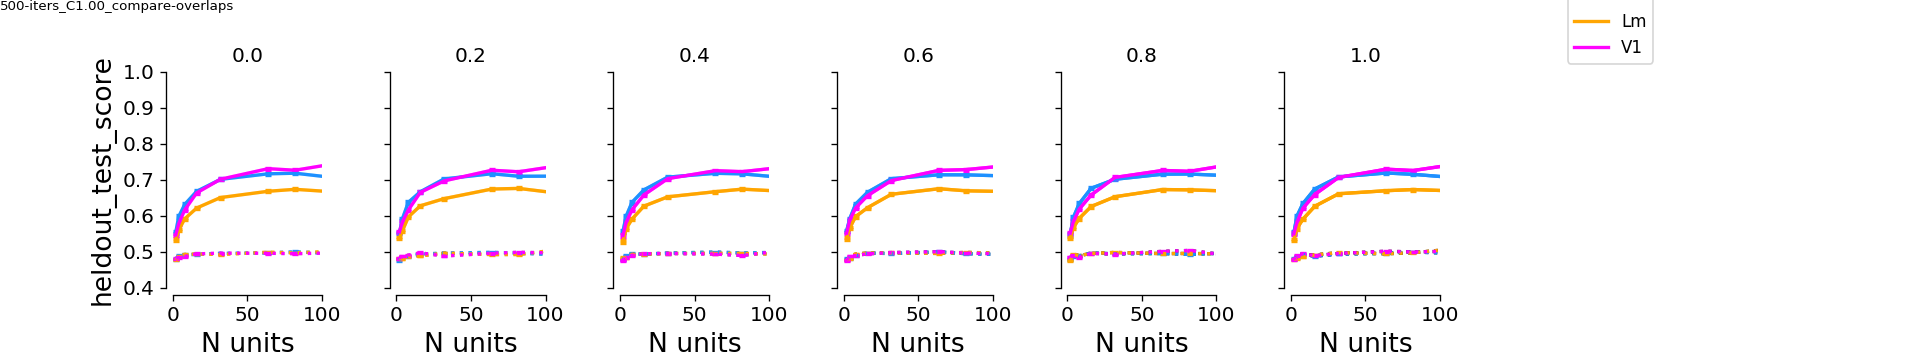

filter-repeat-fovs_heldout_test_score_0vs106_split-test-0.20_5-fold-cv_overlap0.80_C1.00_niter500__dff_resptest-nstds_respthr-10.00


In [130]:
metric = 'heldout_test_score' #'heldout_test_score'
#metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

overlap_levels = sorted(ncells_dict.keys())
overlap_alphas = dict((v, a) for v, a in zip(overlap_levels, np.linspace(0.2, 0.99, len(overlap_levels))))


fig, axn = pl.subplots(1, 6, figsize=(16,3), sharex=True, sharey=True, dpi=dpi)
for ci, (overlap_l, pgroup) in enumerate(pooled.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw,
                label='%s' % (visual_area))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw)
    ax.set_ylabel('')
    if ci==5:
        ax.legend(bbox_to_anchor=(1.8, 1))
    ax.set_title(overlap_l)
    ax.set_xlabel("N units")
    ax.set_ylabel('classifier accuracy')
    ax.set_xlim([0, 100])

for ci, (overlap_l, pgroup) in enumerate(pooled_chance.groupby(['overlap'])):
    for ai, (visual_area, g) in enumerate(pgroup.groupby(['visual_area'])):
        ax = axn[ci]
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
                label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
    if metric=='heldout_test_score':
        ax.set_ylim([0.4, 1.0])
    if ci==0:
        ax.set_ylabel(metric)
    else:
        ax.set_ylabel('')

sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.09, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   

#figname = '%s_perc_overlap_statified-folds_C%.2f_niter%i__%s' % (metric, C_value, n_iterations, response_str)
#pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
#pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

print(figname)

In [ ]:
#zoom=True

#metric = 'heldout_test_score' #'heldout_aMI' #'heldout_test_score'
#metric = 'heldout_aMI' #'heldout_aMI' #'heldout_test_score'

#metric_base = metric #'heldout_test' if metric=='heldout_test_score' else metric
overlap_thr=0.8

res_df = pooled[pooled['overlap_thr']==overlap_thr].copy()
chance_df = pooled_chance[pooled_chance['overlap_thr']==overlap_thr].copy()

lw = 2
capsize=2

for zoom in [True, False]:
    for metric in ['heldout_aMI', 'heldout_log2MI', 'heldout_test_score']:
        metric_base = metric #'heldout_test' if metric=='heldout_test_score' else metric
        
        fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
        for ai, (visual_area, g) in enumerate(res_df.groupby(['visual_area'])):
            mean_scores = g.sort_values(by='n_units')[metric]
            std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
            n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
            ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                    alpha=1, lw=lw,
                    label='%s' % (visual_area))
            ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                        capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                        lw=lw)
        ax.legend(bbox_to_anchor=(1., 1))
        ax.set_title(overlap_thr)
        ax.set_xlabel("N units")
        ax.set_ylabel(metric)

        for ai, (visual_area, g) in enumerate(chance_df.groupby(['visual_area'])):
            mean_scores = g.sort_values(by='n_units')[metric]
            std_scores = g.sort_values(by='n_units')['%s_sem' % metric]
            n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
            ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
                    alpha=1, lw=lw, linestyle=':', 
                    label=None)
            ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                        capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                        lw=lw, linestyle=':')
        if metric=='heldout_test_score':
            ax.set_ylim([0.4, 1.0])
        ax.set_ylabel(metric)

        if zoom:
            ax.set_xlim([0, 100])
            zoom_str = 'zoom_'
        else:
            zoom_str=''

        sns.despine(trim=True, offset=4)
        pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

        analysis_str = '%s|%i-iters_C%.2f_compare-overlaps' % (response_str, n_iterations, C_value)

        putils.label_figure(fig, analysis_str)

        figname = '%s_%s%s_overlap%.2f_%ivs%i_split-test-%.2f_%i-fold-cv_C%.2f_niter%i__%s' % (filter_str, zoom_str, metric, overlap_thr, m0, m100, test_split, cv_nfolds, C_value, n_iterations, response_str)
        pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))

        print(decoding_dir, figname)

# Select 1 overlap_thr and do more fine-grained sampling of NCELLS

In [1141]:
overlap_thr = 0.8
#overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

pdf = has_blobs[has_blobs['perc_overlap']>=overlap_thr].copy()
print("Thr: %.2f --------------" % overlap_thr)
print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

NCELLS = [2, 4, 8, 16, 32, 48, 56, 64, 72, 80, 100]


Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               100   100
Lm               185   185
V1               572   572


In [1142]:
print(overlap_thr, NCELLS)
n_iterations=500

(0.8, [2, 4, 8, 16, 32, 48, 56, 64, 72, 80, 100])


In [1143]:
#if load_popdata:
    popdf = []
popdf_chance = []
overlap_thr=0.8
i = 0

print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 

for curr_ncells in NCELLS:
    for visual_area, gdf in globaldf.groupby(['visual_area']):
        print("... [%s] popn size: %i" % (visual_area, curr_ncells))

        iter_results=[]; iter_test_results=[];
        iter_results_chance=[]; iter_test_results_chance=[];
        for iteration in np.arange(0, n_iterations):
            # Get random selection of NCELLS for current iter (from global ROI list)
            ncells_t = gdf.shape[0]
            curr_rids = np.array(sorted(gdf['roi'].values.copy()))
            # Random w/ replacement
            rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
            curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
            curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy()

            # Make sure equal num trials per condition for all dsets
            # Get fewest total n trials among dsets
            fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
            # Get trial counts per cond for dset w. fewest trials
            min_ntrials = []
            keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
            for k in keys_with_few:
                currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials.append(currd.groupby(['config']).count().min().min())
            # set min N trials per condition
            min_ntrials = min(min_ntrials)

            # Get data samples for these cells
            d_list=[]
            for datakey, dgroup in curr_roidf.groupby(['datakey']):
                currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
                # Get subset of trials per cond to match min N trials
                tmp_d=[]
                for cfg, dmat in currd.groupby(['config']):
                    if dmat.shape[0] == min_ntrials:
                        tmp_d.append(dmat)
                    else:
                        tixs = np.arange(0, dmat.shape[0])
                        np.random.shuffle(tixs)
                        currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                        tmp_d.append(currd_subset)
                d_ = pd.concat(tmp_d, axis=0) 
                config_list = d_['config'].values     # Get configs on selected trials
                currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
                currd = currd.reset_index(drop=True)  # Reset trial indices 
                currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
                d_list.append(currd)
            curr_data = pd.concat(d_list, axis=1)
            curr_data['config'] = config_list 

            #### Select train/test configs for clf A vs B
            object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
            sample_data = curr_data[curr_data['config'].isin(object_configs)]

            #### Equalize df/f across neurons:  Normalize each neuron to have same (zero) mean, (unit) SD across stimuli
            data = sample_data[curr_roi_list]
            zdata = (data - data.mean()) / data.std()

            #### Get labels
            targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
            targets['label'] = [sdf.loc[cfg]['morphlevel'][0] for cfg in targets.values]

            stimdf = sdf[sdf['morphlevel'].isin([m0, m100])]
            sizes = sorted(stimdf['size'].unique())

            #### For each transformation, split trials into 80% and 20%
            train_data=[]; test_data=[]; 
            train_labels=[]; test_labels=[]; 
            train_data_chance=[]; test_data_chance=[]; 
            train_labels_chance=[]; test_labels_chance=[]; 
            for sz in sizes: 
                curr_configs = sdf[sdf['size']==sz].index.tolist()
                curr_trials = np.array(targets[targets['config'].isin(curr_configs)].index.tolist())
                xi = zdata.loc[curr_trials]
                yi = targets.loc[curr_trials]['label'].values

                # Split train/test
                train_x, test_x, train_y, test_y = train_test_split(xi, yi, test_size=0.2)
                train_data.append(train_x)
                test_data.append(test_x)
                train_labels.append(train_y)
                test_labels.append(test_y)

            # Aggregate TRAIN/TEST data        
            train_data = np.vstack(train_data)
            train_labels = np.hstack(train_labels)
            test_data = np.vstack(test_data)
            test_labels = np.hstack(test_labels)

            #### DATA - Fit classifier
            svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores = cross_validate(svc, train_data, train_labels, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict = dict((s, values.mean()) for s, values in scores.items())

            #### DATA - Test with held-out data
            trained_svc = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels)
            test_score = trained_svc.score(test_data, test_labels)
            
            #### DATA - Calculate MI
            predicted_labels = trained_svc.predict(test_data)
            mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
            ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
            log2_mi = computeMI(test_labels, predicted_labels)
            
            iterdict.update({'heldout_test_score': test_score, 
                             'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
            iter_results.append(pd.DataFrame(iterdict, index=[iteration]))
            
            # ------------------------------------------------------------------
            # Shuffle LABELS to calculate chance level
            train_labels_chance = train_labels.copy()
            np.random.shuffle(train_labels_chance)
            test_labels_chance = test_labels.copy()
            np.random.shuffle(test_labels_chance)

            #### CHANCE - Fit classifier
            svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2')
            scores_chance = cross_validate(svc, train_data, train_labels_chance, cv=5,
                                    scoring=('r2', 'neg_mean_squared_error', 'accuracy'),
                                    return_train_score=True)
            iterdict_chance = dict((s, values.mean()) for s, values in scores_chance.items())

            # CHANCE - Test with held-out data
            trained_svc_chance = LinearSVC(multi_class='ovr', C=C_value, penalty='l2').fit(train_data, train_labels_chance)
            test_score_chance = trained_svc_chance.score(test_data, test_labels_chance)  
            
            # Chance - Calculate MI
            predicted_labels = trained_svc_chance.predict(test_data)
            mi = skmetrics.mutual_info_score(test_labels, predicted_labels)
            ami = skmetrics.adjusted_mutual_info_score(test_labels, predicted_labels)
            log2_mi = computeMI(test_labels, predicted_labels)
            
            iterdict_chance.update({'heldout_test_score': test_score_chance, 
                                    'heldout_MI': mi, 'heldout_aMI': ami, 'heldout_log2MI': log2_mi})
            iter_results_chance.append(pd.DataFrame(iterdict_chance, index=[iteration]))

        # DATA - get mean across iters
        iter_results = pd.concat(iter_results, axis=0)
        iterdict = dict(iter_results.mean())
        iterdict.update({'n_units': curr_ncells, 
                         'overlap': overlap_thr,
                         'visual_area': visual_area,
                          'heldout_test_sem': spstats.sem(iter_results['heldout_test_score'].values),
                          'heldout_test_std': float(iter_results['heldout_test_score'].std()),
                          'heldout_MI_sem': spstats.sem(iter_results['heldout_MI'].values),
                          'heldout_MI_std': float(iter_results['heldout_MI'].std()),
                          'heldout_aMI_sem': spstats.sem(iter_results['heldout_aMI'].values),
                          'heldout_aMI_std': float(iter_results['heldout_aMI'].std()),
                          'heldout_log2MI_sem': spstats.sem(iter_results['heldout_log2MI'].values),
                          'heldout_log2MI_std': float(iter_results['heldout_log2MI'].std())})
        popdf.append(pd.DataFrame(iterdict, index=[i]))

        # CHANCE - get mean across iters
        iter_results_chance = pd.concat(iter_results_chance, axis=0)
        iterdict_chance = dict(iter_results_chance.mean())
        iterdict_chance.update({'n_units': curr_ncells, 
                                'overlap': overlap_thr,
                                'visual_area': visual_area,
                              'heldout_test_sem': spstats.sem(iter_results_chance['heldout_test_score'].values),
                              'heldout_test_std': float(iter_results_chance['heldout_test_score'].std()),
                              'heldout_MI_sem': spstats.sem(iter_results_chance['heldout_MI'].values),
                              'heldout_MI_std': float(iter_results_chance['heldout_MI'].std()),
                              'heldout_aMI_sem': spstats.sem(iter_results_chance['heldout_aMI'].values),
                              'heldout_aMI_std': float(iter_results_chance['heldout_aMI'].std()),
                              'heldout_log2MI_sem': spstats.sem(iter_results_chance['heldout_log2MI'].values),
                              'heldout_log2MI_std': float(iter_results_chance['heldout_log2MI'].std())})
        popdf_chance.append(pd.DataFrame(iterdict_chance, index=[i]))
        i += 1
results = pd.concat(popdf, axis=0)
results_chance = pd.concat(popdf_chance, axis=0)
print(results.shape, results_chance.shape)
results.head()

-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)
... [Li] popn size: 2
... [Lm] popn size: 2
... [V1] popn size: 2
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 48
... [Lm] popn size: 48
... [V1] popn size: 48
... [Li] popn size: 56
... [Lm] popn size: 56
... [V1] popn size: 56
... [Li] popn size: 64
... [Lm] popn size: 64
... [V1] popn size: 64
... [Li] popn size: 72
... [Lm] popn size: 72
... [V1] popn size: 72
... [Li] popn size: 80
... [Lm] popn size: 80
... [V1] popn size: 80
... [Li] popn size: 100
... [Lm] popn size: 100
... [V1] popn size: 100
((33, 23), (33, 23))


fit_time  heldout_MI  heldout_MI_sem  heldout_MI_std  heldout_aMI  \
0  0.003650    0.020443        0.001229        0.027485     0.017418   
1  0.004448    0.016920        0.001019        0.022787     0.012203   
2  0.003726    0.021042        0.001225        0.027384     0.018354   
3  0.005080    0.037578        0.001785        0.039924     0.042524   
4  0.005957    0.021228        0.001163        0.026011     0.018572   

   heldout_aMI_sem  heldout_aMI_std  heldout_log2MI  heldout_log2MI_sem  \
0         0.001805         0.040362        0.029493            0.001773   
1         0.001500         0.033538        0.024411            0.001470   
2         0.001798         0.040195        0.030358            0.001767   
3         0.002622         0.058638        0.054213            0.002576   
4         0.001708         0.038181        0.030626            0.001678   

   heldout_log2MI_std     ...       n_units  overlap  score_time  \
0            0.039652     ...             2      0.8    0.000512   
1            0.032875     ...             2      0.8    0.000518   
2            0.039507     ...             2      0.8    0.000524   
3            0.057598     ...             4      0.8    0.000526   
4            0.037526     ...             4      0.8    0.000521   

   test_accuracy  test_neg_mean_squared_error   test_r2  train_accuracy  \
0       0.561056                 -4931.974762 -0.757373        0.581073   
1       0.545976                 -5101.414273 -0.817960        0.568528   
2       0.555620                 -4993.058108 -0.779308        0.578534   
3       0.593985                 -4561.980516 -0.625561        0.626014   
4       0.562647                 -4914.093122 -0.751028        0.599295   

   train_neg_mean_squared_error  train_r2  visual_area  
0                  -4707.069230 -0.677117           Li  
1                  -4848.021922 -0.727540           Lm  
2                  -4735.594290 -0.687442           V1  
3                  -4202.102657 -0.497224           Li  
4                  -4502.316516 -0.604191           Lm  

[5 rows x 23 columns]

#### plot MI - overlap_thr fixed

<IPython.core.display.Javascript object>


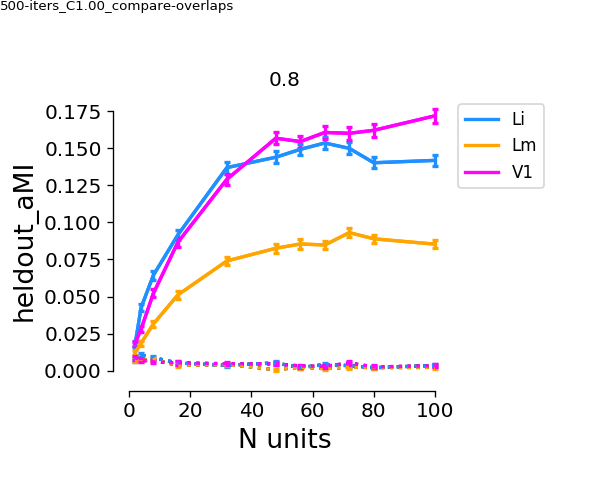

heldout_aMI_lin-sep_overlap0.80_C1.00_niter500__dff_resptest-nstds_respthr-0.05


In [1154]:
metric = 'heldout_aMI' #'heldout_aMI' #'heldout_test_score'
metric_base = 'heldout_test' if metric=='heldout_test_score' else metric

lw = 2
capsize=2

fig, ax = pl.subplots(figsize=(5,4), sharex=True, sharey=True, dpi=dpi)
for ai, (visual_area, g) in enumerate(results.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
            alpha=overlap_alphas[overlap_l], lw=lw,
            label='%s' % (visual_area))
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw)
ax.legend(bbox_to_anchor=(1., 1))
ax.set_title(overlap_thr)
ax.set_xlabel("N units")
ax.set_ylabel(metric)


for ai, (visual_area, g) in enumerate(results_chance.groupby(['visual_area'])):
    mean_scores = g.sort_values(by='n_units')[metric]
    std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
    n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
    ax.plot(n_units_per, mean_scores, color='k', #area_colors[visual_area], 
            alpha=overlap_alphas[overlap_l], lw=lw, linestyle=':', 
            label=None)
    ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                lw=lw, linestyle=':')
if metric=='heldout_test_score':
    ax.set_ylim([0.4, 1.0])
ax.set_ylabel(metric)


sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.2, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   
figname = '%s_lin-sep_overlap%.2f_C%.2f_niter%i__%s' % (metric, overlap_thr, C_value, n_iterations, response_str)
pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
# #pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

print(figname)

In [1098]:
results.head()

fit_time  heldout_MI  heldout_MI_sem  heldout_MI_std  heldout_aMI  \
0  0.003581    0.017625        0.002604        0.018415     0.013306   
1  0.004261    0.019583        0.003882        0.027446     0.015988   
2  0.003904    0.016860        0.003525        0.024925     0.012421   
3  0.005282    0.034933        0.005187        0.036678     0.038543   
4  0.006122    0.023208        0.003956        0.027977     0.021617   

   heldout_aMI_sem  heldout_aMI_std  heldout_log2MI  heldout_log2MI_sem  \
0         0.003855         0.027258        0.025427            0.003757   
1         0.005720         0.040450        0.028252            0.005600   
2         0.005144         0.036373        0.024323            0.005085   
3         0.007593         0.053692        0.050398            0.007483   
4         0.005797         0.040994        0.033482            0.005708   

   heldout_log2MI_std     ...       n_units  overlap  score_time  \
0            0.026568     ...             2      0.8    0.000538   
1            0.039597     ...             2      0.8    0.000520   
2            0.035960     ...             2      0.8    0.000546   
3            0.052915     ...             4      0.8    0.000534   
4            0.040362     ...             4      0.8    0.000522   

   test_accuracy  test_neg_mean_squared_error   test_r2  train_accuracy  \
0       0.570314                 -4827.954641 -0.720135        0.589152   
1       0.549545                 -5061.317730 -0.803790        0.573573   
2       0.561047                 -4932.073987 -0.757595        0.583879   
3       0.596552                 -4533.147140 -0.615229        0.627538   
4       0.574038                 -4786.113244 -0.705895        0.606195   

   train_neg_mean_squared_error  train_r2  visual_area  
0                  -4616.292795 -0.644598           Li  
1                  -4791.333748 -0.707420           Lm  
2                  -4675.531498 -0.666071           V1  
3                  -4184.987095 -0.491034           Li  
4                  -4424.792566 -0.576986           Lm  

[5 rows x 23 columns]

## Compare information metrics

<IPython.core.display.Javascript object>


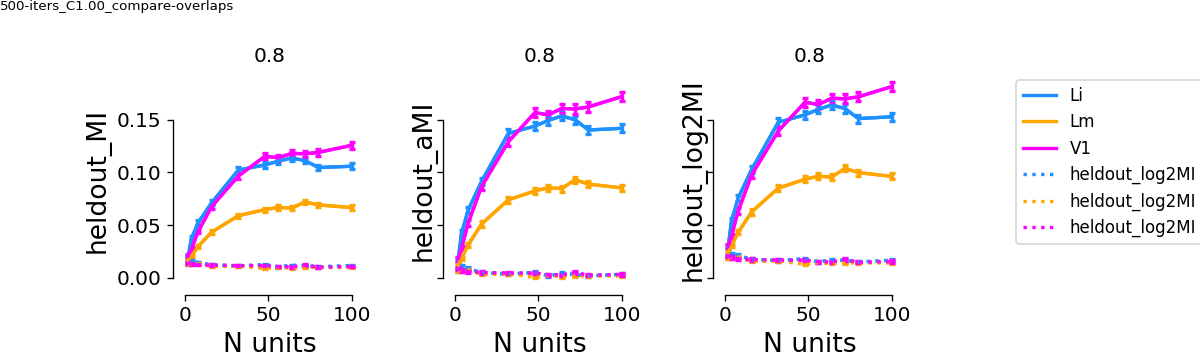

In [1155]:

lw = 2
capsize=2

fig, axn = pl.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True, dpi=dpi)

metric = 'heldout_MI'
for ax, metric in zip(axn.flat, ['heldout_MI', 'heldout_aMI', 'heldout_log2MI']):
    metric_base = 'heldout_test' if metric=='heldout_test_score' else metric
    #ax = axn[0]
    for ai, (visual_area, g) in enumerate(results.groupby(['visual_area'])):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=1, lw=lw, label='%s' % (visual_area))
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, lw=lw, label=None, alpha=1) #overlap_alphas[overlap_l], 
    ax.set_title(overlap_thr)
    ax.set_xlabel("N units")
    ax.set_ylabel(metric)
    
    for ai, (visual_area, g) in enumerate(results_chance.groupby(['visual_area'])):
        mean_scores = g.sort_values(by='n_units')[metric]
        std_scores = g.sort_values(by='n_units')['%s_sem' % metric_base]
        n_units_per = g.groupby(['n_units'])[metric].mean().index.tolist()
        ax.plot(n_units_per, mean_scores, color=area_colors[visual_area], 
                alpha=1, lw=lw, linestyle=':', label=None)
        ax.errorbar(n_units_per, mean_scores, yerr=std_scores, color=area_colors[visual_area], 
                    capthick=lw, capsize=capsize, label=None, alpha=1, #overlap_alphas[overlap_l], 
                    lw=lw, linestyle=':')
    #ax.set_ylim([0.4, 1.0])
    ax.set_ylabel(metric)

axn[-1].legend(bbox_to_anchor=(1.6, 1))
sns.despine(trim=True, offset=4)
pl.subplots_adjust(right=0.75, left=0.15, wspace=0.5, bottom=0.2, top=0.8)

analysis_str = '%i-iters_C%.2f_compare-overlaps' % (n_iterations, C_value)
putils.label_figure(fig, analysis_str)
   
# figname = 'lin-sep_overlap%.2f_C%.2f_niter%i__%s' % (overlap_thrC_value, n_iterations, response_str)
# pl.savefig(os.path.join(decoding_dir, '%s.svg' % figname))
# #pl.savefig(os.path.join(decoding_dir, '%s.png' % figname))

# print(figname)

In [1102]:
results.groupby(['visual_area', 'n_units']).mean()

fit_time  heldout_MI  heldout_MI_sem  heldout_MI_std  \
visual_area n_units                                                         
Li          2        0.003581    0.017625        0.002604        0.018415   
            4        0.005282    0.034933        0.005187        0.036678   
            8        0.007254    0.044066        0.006300        0.044550   
            16       0.011590    0.083034        0.006016        0.042542   
            32       0.012882    0.105491        0.010048        0.071051   
            64       0.013936    0.116153        0.009318        0.065889   
            100      0.019367    0.115751        0.009491        0.067110   
Lm          2        0.004261    0.019583        0.003882        0.027446   
            4        0.006122    0.023208        0.003956        0.027977   
            8        0.008209    0.037167        0.005817        0.041135   
            16       0.012848    0.043340        0.005782        0.040885   
            32       0.016152    0.050928        0.005101        0.036069   
            64       0.030028    0.062859        0.005239        0.037045   
            100      0.028118    0.062521        0.007075        0.050027   
V1          2        0.003904    0.016860        0.003525        0.024925   
            4        0.005333    0.024025        0.004958        0.035058   
            8        0.007542    0.045131        0.005278        0.037323   
            16       0.012314    0.060493        0.007342        0.051913   
            32       0.014866    0.087766        0.008008        0.056628   
            64       0.023610    0.140245        0.009934        0.070245   
            100      0.017323    0.118047        0.009299        0.065755   

                     heldout_aMI  heldout_aMI_sem  heldout_aMI_std  \
visual_area n_units                                                  
Li          2           0.013306         0.003855         0.027258   
            4           0.038543         0.007593         0.053692   
            8           0.051870         0.009241         0.065340   
            16          0.108867         0.008813         0.062314   
            32          0.141849         0.014744         0.104258   
            64          0.157240         0.013708         0.096933   
            100         0.156581         0.013931         0.098509   
Lm          2           0.015988         0.005720         0.040450   
            4           0.021617         0.005797         0.040994   
            8           0.041846         0.008507         0.060156   
            16          0.051264         0.008584         0.060695   
            32          0.062215         0.007501         0.053043   
            64          0.079610         0.007660         0.054168   
            100         0.079048         0.010369         0.073323   
V1          2           0.012421         0.005144         0.036373   
            4           0.022685         0.007271         0.051414   
            8           0.053557         0.007724         0.054617   
            16          0.076196         0.010770         0.076158   
            32          0.116140         0.011715         0.082836   
            64          0.193196         0.014560         0.102956   
            100         0.160508         0.013622         0.096325   

                     heldout_log2MI  heldout_log2MI_sem  heldout_log2MI_std  \
visual_area n_units                                                           
Li          2              0.025427            0.003757            0.026568   
            4              0.050398            0.007483            0.052915   
            8              0.063574            0.009089            0.064271   
            16             0.119792            0.008680            0.061375   
            32             0.152191            0.014496            0.102505   
            64             0.167573            0.013443            0.095057   
      

In [ ]:
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')

overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)



# Test generalization

In [ ]:
exp = util.Objects(animalid, session, fov, traceid=traceid, rootdir=rootdir)
# Get stimulus conditions
sdf = exp.get_stimuli()
sdf = reformat_morph_values(sdf)
sizes = np.array(sorted(sdf['size'].unique()))
morphs = np.array(sorted(sdf['morphlevel'].unique()))

In [1156]:
overlap_thr=0.8
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 


-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)


In [1230]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler


In [1372]:
overlap_thr = 0.8
#overlap_thr_values = np.arange(0, 1+overlap_int, overlap_int)

pdf = has_blobs[has_blobs['perc_overlap']>=overlap_thr].copy()
print("Thr: %.2f --------------" % overlap_thr)
print(pdf[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())

#NCELLS = [2, 4, 8, 16, 32, 48, 56, 64, 72, 80, 100]
NCELLS = [2, 4, 8, 16, 32, 64, 82, 100]

print(overlap_thr, NCELLS)
n_iterations=500

Thr: 0.80 --------------
             datakey  cell
visual_area               
Li               100   100
Lm               185   185
V1               572   572
(0.8, [2, 4, 8, 16, 32, 64, 82, 100])


In [1373]:
#if load_popdata:
    
res_list=[]
i = 0
print("-------- Overlap: %.2f --------" % overlap_thr)
# Get list of eligible cells from all FOVs
globaldf = filter_rois(has_blobs[has_blobs['datakey'].isin(stim_datakeys)], overlap_thr=overlap_thr) 

for curr_ncells in NCELLS:
    for visual_area, gdf in globaldf.groupby(['visual_area']):
        print("... [%s] popn size: %i" % (visual_area, curr_ncells))
        r_list=[]
        for iteration in np.arange(0, n_iterations):
            # Get random selection of NCELLS for current iter (from global ROI list)
            ncells_t = gdf.shape[0]
            curr_rids = np.array(sorted(gdf['roi'].values.copy()))

            # Random w/ replacement
            rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
            curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
            curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy() # Get rois/datasets that correspond to these global rids

            # Make sure equal num trials per condition for all dsets
            if not exact_trials:
                # Get fewest total n trials among dsets
                fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
                # Get trial counts per cond for dset w. fewest trials
                min_ntrials = []
                keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
                for k in keys_with_few:
                    currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
                    min_ntrials.append(currd.groupby(['config']).count().min().min())
                # set min N trials per condition
                min_ntrials = min(min_ntrials)

            # For each cell, get is particular trials by loading the dataset it came from
            d_list=[]
            for datakey, dgroup in curr_roidf.groupby(['datakey']):
                currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
                min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
                if exact_trials:
                    tmp_d = currd.copy()
                else:
                    # get subset of trials per cond to match min N trials
                    tmp_d=[]
                    for cfg, dmat in currd.groupby(['config']):
                        if dmat.shape[0] == min_ntrials:
                            tmp_d.append(dmat)
                        else:
                            tixs = np.arange(0, dmat.shape[0])
                            np.random.shuffle(tixs)
                            currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                            tmp_d.append(currd_subset)
                    d_ = pd.concat(tmp_d, axis=0)     # Get current cell's trials
                config_list = d_['config'].values     # Get configs on selected trials
                currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
                currd = currd.reset_index(drop=True)  # Reset trial indices 
                currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
                d_list.append(currd)
            #curr_data = pd.concat(d_list, axis=1)
            #curr_data['config'] = config_list 
            sample_data = pd.concat(d_list, axis=1)
            sample_labels = config_list

            #### Select train/test configs for clf A vs B
            # object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
            curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
            #sample_data = curr_data[curr_data['config'].isin(object_configs)]

            #-----------------
            stimdf = sdf.copy()
            tested_sizes = sorted(sdf['size'].unique())
            tested_morphs = sorted(sdf['morphlevel'].unique())

            #% Specify train/test conditions:     
            class_name = 'morphlevel'
            class_types = [0, 106]
            restrict_transform = True
            constant_transform = 'size'

            # C = 1e3
            m0 = 0
            m100 = 106

            # Go thru all training sizes, then test on non-trained sizes
            for train_transform in tested_sizes:
                # Get train configs
                train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                        & (stimdf[constant_transform]==train_transform))].index.tolist()

                # Get corresponding indices into data array
                train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

                # Get data and labels
                X = sample_data.iloc[train_ixs].values #[train_configs]
                y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])

                train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

                
                # Select generalization-test set
                untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
                test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                                       & (stimdf[class_name].isin(class_types)) )].index.tolist()
                test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
                X_test = sample_data.iloc[test_ixs].values
                y_test_labels = sample_labels[test_ixs]
                test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()

                #% Train/validation split
                n_splits = 5 #len(X)
                kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0) #KFold(n_splits=n_splits)
                kf.get_n_splits(train_x) #(X)

                # Do K-fold CV for current stimulus configs
                scores=[]
                test_scores = dict((tv, []) for tv in tested_sizes)
                for train_index, validate_index in kf.split(train_x, train_y): #(X, y): #kf.split(X):

                    # Get current train/validate split data
#                     X_train, X_validate = X[train_index], X[validate_index]
#                     y_train, y_validate = y[train_index], y[validate_index]
                    X_train, X_validate = train_x[train_index], train_x[validate_index]
                    y_train, y_validate = train_y[train_index], train_y[validate_index]
        
                    scaler = preprocessing.StandardScaler().fit(X_train)
                    X_train_transformed = scaler.transform(X_train)

                    # Fit SVM
                    trained_svc = LinearSVC(multi_class='ovr', C=C_value).fit(X_train_transformed, y_train)

                    # Validate with held-out data
                    X_validate_transformed = scaler.transform(X_validate)
                    curr_score = trained_svc.score(X_validate_transformed, y_validate)  
                    y_pred = trained_svc.predict(X_validate_transformed)

                    # Add current fold score
                    test_scores[train_transform].append(curr_score)

                    # Test (generalization) to each size and update test scores
                    for test_transform in sorted(test_transforms):
                        curr_test_ixs = [i for i, tl in enumerate(y_test_labels)\
                                         if stimdf[constant_transform][tl]==test_transform]

                        X_test_transformed = scaler.transform(X_test[curr_test_ixs, :])
                        y_test_curr_labels = [stimdf['morphlevel'][tc] for tc in y_test_labels[curr_test_ixs]]
                        curr_score_test = trained_svc.score(X_test_transformed, y_test_curr_labels)
                        test_scores[test_transform].append( curr_score_test )

                test_df = pd.DataFrame(dict((k, np.mean(v)) for k, v in test_scores.items()), index=[train_transform])
                test_df['iteration'] = iteration
                test_df['train_cond'] = train_transform
                r_list.append(test_df)
        iter_res = pd.concat(r_list, axis=0)
        #iter_res = res.groupby(['train_cond', 'iteration']).mean().reset_index()
        iter_res['visual_area'] = [visual_area for _ in np.arange(0, len(iter_res))]
        iter_res['n_cells'] = [curr_ncells for _ in np.arange(0, len(iter_res))]
        res_list.append(iter_res)
        

print(len(res_list))

res = pd.concat(res_list)
print(res.shape)

-------- Overlap: 0.80 --------
('V1', 572)
('Lm', 185)
('Li', 100)
... [Li] popn size: 2
... [Lm] popn size: 2
... [V1] popn size: 2
... [Li] popn size: 4
... [Lm] popn size: 4
... [V1] popn size: 4
... [Li] popn size: 8
... [Lm] popn size: 8
... [V1] popn size: 8
... [Li] popn size: 16
... [Lm] popn size: 16
... [V1] popn size: 16
... [Li] popn size: 32
... [Lm] popn size: 32
... [V1] popn size: 32
... [Li] popn size: 64
... [Lm] popn size: 64
... [V1] popn size: 64
... [Li] popn size: 82
... [Lm] popn size: 82
... [V1] popn size: 82
... [Li] popn size: 100
... [Lm] popn size: 100
... [V1] popn size: 100


In [1456]:
n_iterations = 3

In [1460]:
i=0
r_list=[]
for iteration in np.arange(0, n_iterations):
    # Get random selection of NCELLS for current iter (from global ROI list)
    ncells_t = gdf.shape[0]
    curr_rids = np.array(sorted(gdf['roi'].values.copy()))

    # Random w/ replacement
    rand_ixs = np.array([random.randint(0, ncells_t-1) for x in range(curr_ncells)]) #np.random.shuffle(curr_rids)
    curr_roi_list = curr_rids[rand_ixs] #curr_rids[0:curr_ncells]
    curr_roidf = gdf[gdf['roi'].isin(curr_roi_list)].copy() # Get rois/datasets that correspond to these global rids

    # Make sure equal num trials per condition for all dsets
    # if not exact_trials:
    # Get fewest total n trials among dsets
    fewest_ntrials = np.min([MEANS[k].shape[0] for k in curr_roidf['datakey'].unique()])
    # Get trial counts per cond for dset w. fewest trials
    min_ntrials = []
    keys_with_few = [k for k in curr_roidf['datakey'].unique() if MEANS[k].shape[0]==fewest_ntrials]
    for k in keys_with_few:
        currd = MEANS[k].sort_values(by='config') #[dgroup['dset_roi']]
        min_ntrials.append(currd.groupby(['config']).count().min().min())
    # set min N trials per condition
    min_ntrials = min(min_ntrials)

    # For each cell, get is particular trials by loading the dataset it came from
    d_list=[]
    for datakey, dgroup in curr_roidf.groupby(['datakey']):
        currd = MEANS[datakey].sort_values(by='config') #[dgroup['dset_roi']]
        min_ntrials = min([min_ntrials, currd.groupby(['config']).count().min().min()])
        #if exact_trials:
        #    tmp_d = currd.copy()
        #else:
        # Get subset of trials per cond to match min N trials
        tmp_d=[]
        for cfg, dmat in currd.groupby(['config']):
            if dmat.shape[0] == min_ntrials:
                tmp_d.append(dmat)
            else:
                tixs = np.arange(0, dmat.shape[0])
                np.random.shuffle(tixs)
                currd_subset = dmat.iloc[tixs[0:min_ntrials]].copy()
                tmp_d.append(currd_subset)
        d_ = pd.concat(tmp_d, axis=0)     # Get current cell's trials
        config_list = d_['config'].values     # Get configs on selected trials
        currd = d_[dgroup['dset_roi']].copy() # Data should only include ROI columns
        currd = currd.reset_index(drop=True)  # Reset trial indices 
        currd.columns = dgroup['roi'].values  # Rename ROI columns to global-rois
        d_list.append(currd)
    #curr_data = pd.concat(d_list, axis=1)
    #curr_data['config'] = config_list 
    sample_data = pd.concat(d_list, axis=1)
    sample_labels = config_list

    #### Select train/test configs for clf A vs B
    # object_configs = sdf[sdf['morphlevel'].isin([m0, m100])].index.tolist() 
    curr_roi_list = [int(c) for c in curr_data.columns if c != 'config']
    #sample_data = curr_data[curr_data['config'].isin(object_configs)]

    #-----------------
    stimdf = sdf.copy()
    tested_sizes = sorted(sdf['size'].unique())
    tested_morphs = sorted(sdf['morphlevel'].unique())

    #% Specify train/test conditions:     
    class_name = 'morphlevel'
    class_types = [0, 106]
    restrict_transform = True
    constant_transform = 'size'

    # C = 1e3
    m0 = 0
    m100 = 106

    # Go thru all training sizes, then test on non-trained sizes
    for train_transform in tested_sizes:
        # Get train configs
        train_configs = stimdf[((stimdf[class_name].isin(class_types))\
                                & (stimdf[constant_transform]==train_transform))].index.tolist()

        # Get corresponding indices into data array
        train_ixs = [i for i, l in enumerate(sample_labels) if l in train_configs]

        # Get data and labels
        X = sample_data.iloc[train_ixs].values #[train_configs]
        y = np.array([stimdf[class_name][c] for c in sample_labels[train_ixs]])
        
        # Save test set for train transform
        train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

        # Select generalization-test set
        untrained_class_types = [c for c in stimdf[class_name].unique() if c not in class_types]
        test_configs = stimdf[( (stimdf[constant_transform]!=train_transform)\
                               & (stimdf[class_name].isin(class_types)) )].index.tolist()
        test_ixs = [i for i, l in enumerate(sample_labels) if l in test_configs]
        X_test = sample_data.iloc[test_ixs].values
        y_test_labels = sample_labels[test_ixs]
        test_transforms = stimdf[stimdf[constant_transform]!=train_transform][constant_transform].unique()

        #% Train/validation split
        n_splits = 3 #len(X)
        kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0) #KFold(n_splits=n_splits)
        kf.get_n_splits(train_x) #(X)

        test_scores = dict((tv, []) for tv in tested_sizes)
        
        # Do K-fold CV for current stimulus configs
        cv_scores=[]
        for train_index, validate_index in kf.split(train_x, train_y): #(X, y): #kf.split(X):
            # Get current train/validate split data
#                     X_train, X_validate = X[train_index], X[validate_index]
#                     y_train, y_validate = y[train_index], y[validate_index]
            X_train, X_validate = train_x[train_index], train_x[validate_index]
            y_train, y_validate = train_y[train_index], train_y[validate_index]

            scaler = preprocessing.StandardScaler().fit(X_train)
            X_train_transformed = scaler.transform(X_train)

            # Fit SVM
            trained_svc = LinearSVC(multi_class='ovr', C=C_value).fit(X_train_transformed, y_train)

            # Validate with held-out data
            X_validate_transformed = scaler.transform(X_validate)
            cv_score = trained_svc.score(X_validate_transformed, y_validate)  
            #y_pred = trained_svc.predict(X_validate_transformed)
            cv_scores.append(cv_score)

        # Save CV and test scores
        mean_cv_score = np.mean(cv_scores)
        
        # Train clf on all (train) data
        trained_svc = LinearSVC(multi_class='ovr', C=C_value).fit(train_x, train_y)
        heldout_train_score = trained_svc.score(test_x, test_y)  
        
        # test_scores[train_transform].append(curr_score)

        # Test (generalization) to each size and update test scores
        for test_transform in sorted(test_transforms):
            curr_test_ixs = [i for i, tl in enumerate(y_test_labels)\
                             if stimdf[constant_transform][tl]==test_transform]

            X_test_transformed = scaler.transform(X_test[curr_test_ixs, :])
            y_test_curr_labels = [stimdf['morphlevel'][tc] for tc in y_test_labels[curr_test_ixs]]
            curr_score_test = trained_svc.score(X_test_transformed, y_test_curr_labels)
            test_scores[test_transform].append( curr_score_test )


        test_scores[train_transform] = heldout_train_score
        tdf = pd.concat([pd.DataFrame({'test_cond': k, 'test_score': np.mean(v)}, index=[i]) \
                   for k, v in test_scores.items()], axis=0)
        tdf['cv_score'] = [mean_cv_score for _ in np.arange(0, len(tdf))]
        tdf['iteration'] = [iteration for _ in np.arange(0, len(tdf))]
        tdf['train_cond'] = [train_transform for _ in np.arange(0, len(tdf))]
        i+=1

        #test_df = pd.DataFrame(dict((k, np.mean(v)) for k, v in test_scores.items()), index=[train_transform])
        #test_df['iteration'] = iteration
        #test_df['train_cond'] = train_transform
        r_list.append(tdf.reset_index(drop=True))

In [1461]:
print(len(r))
r = pd.concat(r_list)
print(r.shape)
r.head()

75
(75, 5)


test_cond  test_score  cv_score  iteration  train_cond
0       40.0    0.448276  0.476389          0        10.0
1       10.0    0.833333  0.476389          0        10.0
2       20.0    0.517241  0.476389          0        10.0
3       50.0    0.517241  0.476389          0        10.0
4       30.0    0.431034  0.476389          0        10.0

In [1464]:
r.groupby(['train_cond', 'test_cond']).mean()

test_score  cv_score  iteration
train_cond test_cond                                 
10.0       10.0         0.583333  0.702579          1
           20.0         0.557471  0.702579          1
           30.0         0.419540  0.702579          1
           40.0         0.500000  0.702579          1
           50.0         0.534483  0.702579          1
20.0       10.0         0.551724  0.686177          1
           20.0         0.777778  0.686177          1
           30.0         0.839080  0.686177          1
           40.0         0.752874  0.686177          1
           50.0         0.775862  0.686177          1
30.0       10.0         0.471264  0.870370          1
           20.0         0.758621  0.870370          1
           30.0         0.944444  0.870370          1
           40.0         0.752874  0.870370          1
           50.0         0.718391  0.870370          1
40.0       10.0         0.511494  0.796759          1
           20.0         0.683908  0.796759          1
           30.0         0.804598  0.796759          1
           40.0         0.861111  0.796759          1
           50.0         0.908046  0.796759          1
50.0       10.0         0.459770  0.812500          1
           20.0         0.666667  0.812500          1
           30.0         0.793103  0.812500          1
           40.0         0.816092  0.812500          1
           50.0         0.916667  0.812500          1

In [1385]:
res.groupby(['train_cond']).count()

10.0   20.0   30.0   40.0   50.0  iteration  visual_area  n_cells
train_cond                                                                    
10.0        12000  12000  12000  12000  12000      12000        12000    12000
20.0        12000  12000  12000  12000  12000      12000        12000    12000
30.0        12000  12000  12000  12000  12000      12000        12000    12000
40.0        12000  12000  12000  12000  12000      12000        12000    12000
50.0        12000  12000  12000  12000  12000      12000        12000    12000

In [1386]:
res.groupby(['visual_area', 'train_cond', 'iteration', 'n_cells']).mean()

10.0      20.0      30.0  \
visual_area train_cond iteration n_cells                                 
Li          10.0       0         2        0.566667  0.606897  0.513793   
                                 4        0.556667  0.548276  0.610345   
                                 8        0.620000  0.644828  0.582759   
                                 16       0.593333  0.557692  0.584615   
                                 32       0.530000  0.589655  0.620690   
                                 64       0.573333  0.582759  0.510345   
                                 82       0.653333  0.615385  0.576923   
                                 100      0.623333  0.657692  0.634615   
                       1         2        0.703333  0.603448  0.693103   
                                 4        0.643333  0.520690  0.517241   
                                 8        0.673333  0.668966  0.662069   
                                 16       0.540000  0.538462  0.538462   
                                 32       0.640000  0.655172  0.658621   
                                 64       0.560000  0.592308  0.626923   
                                 82       0.520000  0.469231  0.588462   
                                 100      0.640000  0.630769  0.600000   
                       2         2        0.526667  0.562069  0.627586   
                                 4        0.606667  0.551724  0.579310   
                                 8        0.643333  0.600000  0.613793   
                                 16       0.533333  0.548276  0.572414   
                                 32       0.600000  0.565517  0.710345   
                                 64       0.580000  0.615385  0.561538   
                                 82       0.683333  0.615385  0.692308   
                                 100      0.803333  0.657692  0.573077   
                       3         2        0.650000  0.631034  0.620690   
                                 4        0.483333  0.586207  0.496552   
                                 8        0.623333  0.662069  0.603448   
                                 16       0.556667  0.557692  0.546154   
                                 32       0.640000  0.576923  0.623077   
                                 64       0.556667  0.561538  0.534615   
...                                            ...       ...       ...   
V1          50.0       496       8        0.486667  0.600000  0.666667   
                                 16       0.541379  0.610345  0.613793   
                                 32       0.496552  0.610345  0.668966   
                                 64       0.489655  0.555172  0.655172   
                                 82       0.537931  0.586207  0.624138   
                                 100      0.513793  0.527586  0.686207   
                       497       2        0.530000  0.496667  0.556667   
                                 4        0.493333  0.486667  0.680000   
                                 8        0.516667  0.530000  0.630000   
                                 16       0.562069  0.620690  0.644828   
                                 32       0.586207  0.548276  0.668966   
                                 64       0.362069  0.710345  0.796552   
                                 82       0.420690  0.565517  0.644828   
                                 100      0.479310  0.579310  0.675862   
                       498       2        0.520000  0.613333  0.683333   
                                 4        0.531034  0.448276  0.679310   
                                 8        0.558621  0.572414  0.644828   
                                 16       0.493103  0.586207  0.600000   
                                 32       0.500000  0.610345  0.675862   
                                 64       0.448276  0.682759  0.782759   
                                 82       0.531034  0.700000  0.737931   
                                 100      0.475862

In [1387]:
meandf = res.groupby(['visual_area', 'n_cells', 'train_cond']).mean().reset_index()

meandf[meandf['n_cells']==100]

visual_area  n_cells  train_cond      10.0      20.0      30.0      40.0  \
35           Li      100        10.0  0.622267  0.597957  0.619528  0.578224   
36           Li      100        20.0  0.618292  0.670720  0.685196  0.652398   
37           Li      100        30.0  0.612711  0.666957  0.751507  0.740051   
38           Li      100        40.0  0.603901  0.634257  0.739493  0.768947   
39           Li      100        50.0  0.557340  0.626703  0.679067  0.737358   
75           Lm      100        10.0  0.522480  0.536097  0.556034  0.547131   
76           Lm      100        20.0  0.525862  0.569893  0.643297  0.572766   
77           Lm      100        30.0  0.537034  0.629359  0.704220  0.669138   
78           Lm      100        40.0  0.509145  0.575434  0.673779  0.707907   
79           Lm      100        50.0  0.518759  0.576069  0.627724  0.695966   
115          V1      100        10.0  0.608800  0.567269  0.480186  0.518359   
116          V1      100        20.0  0.565462  0.716193  0.680324  0.639566   
117          V1      100        30.0  0.513572  0.664710  0.813947  0.765607   
118          V1      100        40.0  0.530469  0.621179  0.775255  0.830533   
119          V1      100        50.0  0.497559  0.596938  0.729876  0.832759   

         50.0  iteration  
35   0.520182      249.5  
36   0.638937      249.5  
37   0.669888      249.5  
38   0.745054      249.5  
39   0.701400      249.5  
75   0.569414      249.5  
76   0.528366      249.5  
77   0.644103      249.5  
78   0.750166      249.5  
79   0.813753      249.5  
115  0.490745      249.5  
116  0.650897      249.5  
117  0.755648      249.5  
118  0.864641      249.5  
119  0.876147      249.5

<IPython.core.display.Javascript object>


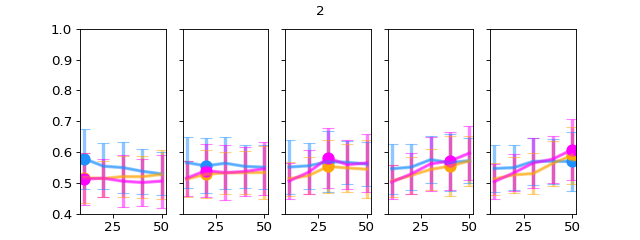

<IPython.core.display.Javascript object>


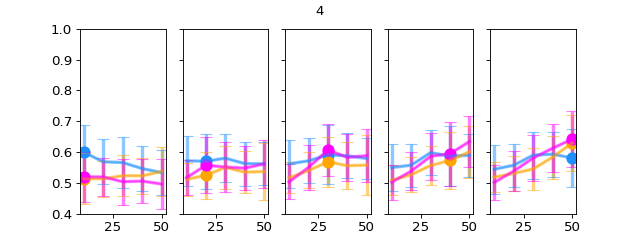

<IPython.core.display.Javascript object>


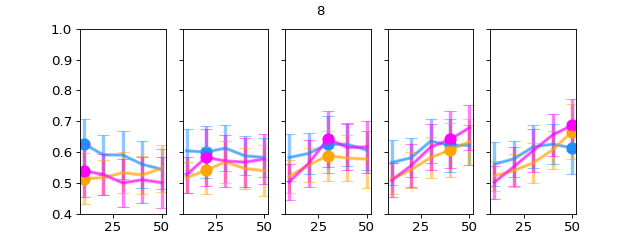

<IPython.core.display.Javascript object>


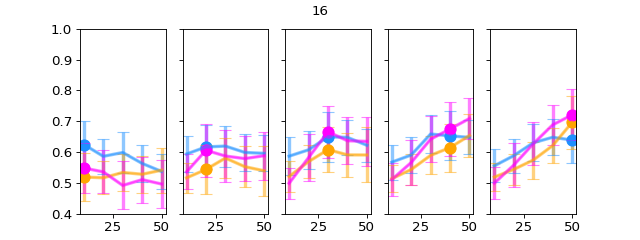

<IPython.core.display.Javascript object>


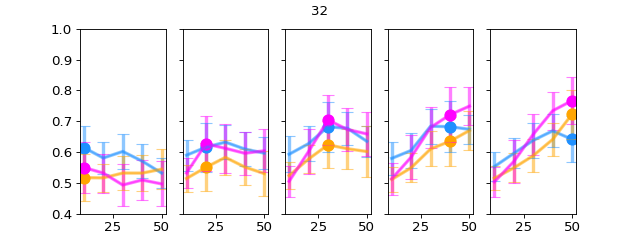

<IPython.core.display.Javascript object>


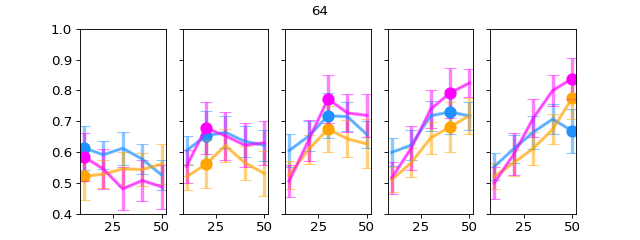

<IPython.core.display.Javascript object>


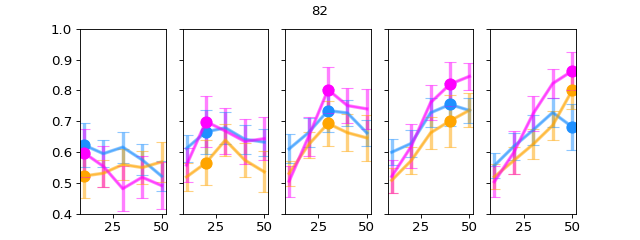

<IPython.core.display.Javascript object>


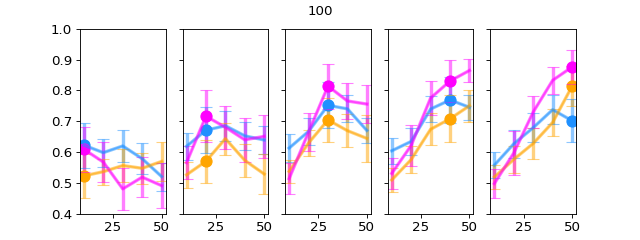

In [1424]:
for ncells in NCELLS:

    fig, axn = pl.subplots(1, 5, figsize=(8,3), sharey=True, sharex=True)

    for ax, (tcond, traindf) in zip(axn.flat, (res[res['n_cells']==ncells].groupby(['train_cond']))):
        for visual_area, v_df in traindf.groupby(['visual_area']):
            means = v_df.mean()[tested_sizes]
            # print(means.values)
            ax.plot(tested_sizes, means.values, 
                   color=area_colors[visual_area], alpha=0.5)

            ax.errorbar(tested_sizes, means.values, yerr=v_df[tested_sizes].std(), capsize=5, lw=3,
                   color=area_colors[visual_area], alpha=0.5)
            ax.set_ylim([0.4, 1])

            ax.plot(tcond, means[tcond], 'o', color=area_colors[visual_area], markersize=10)
    fig.suptitle(ncells)

In [1407]:
spstats.sem(v_df[tested_sizes])

array([ 0.00213105,  0.00313161,  0.00237023,  0.00194066,  0.00244481])

In [1422]:
fig, axn = pl.subplots(1, 5, figsize=(8,3), sharey=True, sharex=True)

    for ax, (tcond, traindf) in zip(axn.flat, (res[res['n_cells']==ncells].groupby(['train_cond']))):
        for visual_area, v_df in traindf.groupby(['visual_area']):
            means = v_df.mean()[tested_sizes]
            # print(means.values)
            ax.plot(tested_sizes, means.values, 
                   color=area_colors[visual_area], alpha=0.5)

            ax.errorbar(tested_sizes, means.values, yerr=v_df[tested_sizes].std(), capsize=5, lw=3,
                   color=area_colors[visual_area], alpha=0.5)
            ax.set_ylim([0.4, 1])

            ax.plot(tcond, means[tcond], 'o', color=area_colors[visual_area], markersize=10)
    fig.suptitle(ncells)

10.0    0.002131
20.0    0.003132
30.0    0.002370
40.0    0.001941
50.0    0.002445
dtype: float64

In [1429]:
res[res['train_cond']==50].groupby(['n_cells', 'visual_area']).mean()

10.0      20.0      30.0      40.0      50.0  \
n_cells visual_area                                                     
2       Li           0.546525  0.549205  0.569532  0.569921  0.569234   
        Lm           0.512468  0.525767  0.530065  0.563154  0.589091   
        V1           0.503806  0.532294  0.564314  0.576856  0.607513   
4       Li           0.544108  0.557034  0.589919  0.592929  0.580822   
        Lm           0.518287  0.530510  0.544892  0.583309  0.629044   
        V1           0.501355  0.538276  0.580536  0.612316  0.641693   
8       Li           0.560511  0.577638  0.616656  0.625477  0.613333   
        Lm           0.522712  0.539898  0.564462  0.607050  0.666387   
        V1           0.501614  0.552315  0.604851  0.655354  0.686720   
16      Li           0.555031  0.588138  0.629946  0.647784  0.638853   
        Lm           0.518510  0.543662  0.573759  0.620745  0.696120   
        V1           0.498886  0.557640  0.626551  0.688114  0.720453   
32      Li           0.552726  0.595707  0.637820  0.668612  0.641007   
        Lm           0.514724  0.548366  0.588152  0.640848  0.723000   
        V1           0.503020  0.569164  0.657378  0.733877  0.766887   
64      Li           0.553211  0.610473  0.664343  0.706896  0.668220   
        Lm           0.520903  0.565297  0.611552  0.673848  0.775020   
        V1           0.499428  0.593021  0.709510  0.799683  0.837853   
82      Li           0.555919  0.618285  0.671734  0.728216  0.681753   
        Lm           0.519379  0.572359  0.625434  0.686593  0.799753   
        V1           0.503545  0.598600  0.725131  0.822317  0.862940   
100     Li           0.557340  0.626703  0.679067  0.737358  0.701400   
        Lm           0.518759  0.576069  0.627724  0.695966  0.813753   
        V1           0.497559  0.596938  0.729876  0.832759  0.876147   

                     iteration  train_cond  
n_cells visual_area                         
2       Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
4       Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
8       Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
16      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
32      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
64      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
82      Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0  
100     Li               249.5        50.0  
        Lm               249.5        50.0  
        V1               249.5        50.0

In [1431]:
curr_mean = res[res['train_cond']==50].groupby(['n_cells', 'visual_area']).mean().reset_index()
curr_mean

n_cells visual_area      10.0      20.0      30.0      40.0      50.0  \
0         2          Li  0.546525  0.549205  0.569532  0.569921  0.569234   
1         2          Lm  0.512468  0.525767  0.530065  0.563154  0.589091   
2         2          V1  0.503806  0.532294  0.564314  0.576856  0.607513   
3         4          Li  0.544108  0.557034  0.589919  0.592929  0.580822   
4         4          Lm  0.518287  0.530510  0.544892  0.583309  0.629044   
5         4          V1  0.501355  0.538276  0.580536  0.612316  0.641693   
6         8          Li  0.560511  0.577638  0.616656  0.625477  0.613333   
7         8          Lm  0.522712  0.539898  0.564462  0.607050  0.666387   
8         8          V1  0.501614  0.552315  0.604851  0.655354  0.686720   
9        16          Li  0.555031  0.588138  0.629946  0.647784  0.638853   
10       16          Lm  0.518510  0.543662  0.573759  0.620745  0.696120   
11       16          V1  0.498886  0.557640  0.626551  0.688114  0.720453   
12       32          Li  0.552726  0.595707  0.637820  0.668612  0.641007   
13       32          Lm  0.514724  0.548366  0.588152  0.640848  0.723000   
14       32          V1  0.503020  0.569164  0.657378  0.733877  0.766887   
15       64          Li  0.553211  0.610473  0.664343  0.706896  0.668220   
16       64          Lm  0.520903  0.565297  0.611552  0.673848  0.775020   
17       64          V1  0.499428  0.593021  0.709510  0.799683  0.837853   
18       82          Li  0.555919  0.618285  0.671734  0.728216  0.681753   
19       82          Lm  0.519379  0.572359  0.625434  0.686593  0.799753   
20       82          V1  0.503545  0.598600  0.725131  0.822317  0.862940   
21      100          Li  0.557340  0.626703  0.679067  0.737358  0.701400   
22      100          Lm  0.518759  0.576069  0.627724  0.695966  0.813753   
23      100          V1  0.497559  0.596938  0.729876  0.832759  0.876147   

    iteration  train_cond  
0       249.5        50.0  
1       249.5        50.0  
2       249.5        50.0  
3       249.5        50.0  
4       249.5        50.0  
5       249.5        50.0  
6       249.5        50.0  
7       249.5        50.0  
8       249.5        50.0  
9       249.5        50.0  
10      249.5        50.0  
11      249.5        50.0  
12      249.5        50.0  
13      249.5        50.0  
14      249.5        50.0  
15      249.5        50.0  
16      249.5        50.0  
17      249.5        50.0  
18      249.5        50.0  
19      249.5        50.0  
20      249.5        50.0  
21      249.5        50.0  
22      249.5        50.0  
23      249.5        50.0

In [1433]:
for visual_area, v_df in curr_mean.groupby(['visual_area']):
    v_df

n_cells visual_area      10.0      20.0      30.0      40.0      50.0  \
2         2          V1  0.503806  0.532294  0.564314  0.576856  0.607513   
5         4          V1  0.501355  0.538276  0.580536  0.612316  0.641693   
8         8          V1  0.501614  0.552315  0.604851  0.655354  0.686720   
11       16          V1  0.498886  0.557640  0.626551  0.688114  0.720453   
14       32          V1  0.503020  0.569164  0.657378  0.733877  0.766887   
17       64          V1  0.499428  0.593021  0.709510  0.799683  0.837853   
20       82          V1  0.503545  0.598600  0.725131  0.822317  0.862940   
23      100          V1  0.497559  0.596938  0.729876  0.832759  0.876147   

    iteration  train_cond  
2       249.5        50.0  
5       249.5        50.0  
8       249.5        50.0  
11      249.5        50.0  
14      249.5        50.0  
17      249.5        50.0  
20      249.5        50.0  
23      249.5        50.0

In [ ]:
fig, axn = pl.subplots(1,5)
sns.pointplot(x='n_cells', y=1)